# Network regularisation and preprocessing

In this tutorial we'll build directly on top of what we did in the amplitude regression task in the previous tutorial.  The first goal is to learn about the issue of over-training, and how to overcome it with network regularisation and early stopping. The second goal is to learn more about the different types of preprocessing that can be used in machine learning.

#### Outline / tasks:
 - Imports \& plotting set-up
 - Loading the data
     - limit the training data to just 1000 events, keeping 30k for validation and testing
     - this is unrealistic, but a good way to understand over-fitting and how to fix it
 - Visualising the data
 - Preprocessing the data
 - Datasets and dataloaders
     - choose a sensible batch size, say 64
 - Building the neural network
     - use a larger network, say 3 layers with hidden dimensions of 50
 - Optimising (training) the neural network
     - train for a long time, 1000-1500 epochs
 - Plot the train and validation losses as a function of the epochs
     - now you should clearly see the over-training problem
 - Network regularisation
     - Dropout
         - implement a new network, amp_net_dr, which has a pytorch dropout layer after the input layer and each hidden layer
         - re-train the network and check if dropout has fixed the over-fitting
     - L1 / L2 regularisation
     - Early stopping
     - Batch normalisation
 - Exploring preprocessing options
     - check what happens if you don't preprocess your data at all..
     - Look at the scikit-learn package a try out a few different data preprocessing functions, e.g. StandardScaler
     - See how these affect the data visualisations
     - Find preprocessing functions that are suitable for the 4-momentum inputs, and some that are suitable for the amplitudes
     
Please download the training data `tutorial-2-data.zip` and extract it to the folder `data/tutorial-2-data/`.

If you want to run this tutorial in google colab, you can open a new colab and then upload this file. 

The data can be downloaded using

```
NEEDS TO BE CHANGED!
!wget -O tutorial-2-data.zip https://www.dropbox.com/s/n5e66w91rgmbqz2/dlpp-data.zip?dl=0&file_subpath=%2Fdlpp-data%2Ftutorial-2-data
!unzip "tutorial-2-data.zip"
!mkdir tutorial-2-data
!mv dlpp-data/tutorial-2-data/* tutorial-2-data/.
!rm -r __MACOSX/
!rm -r dlpp-data/
!ls
```

Make sure you switch to a GPU runtime to fully utilize the colab. 

### Imports

In [1]:
import os
import sys
import random
import time
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

#### Plotting set-up

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
import colorsys

#labelfont = FontProperties()
#labelfont.set_family('serif')
#labelfont.set_name('Times New Roman')
#labelfont.set_size(14)

#axislabelfont = FontProperties()
#axislabelfont.set_family('serif')
#axislabelfont.set_name('Times New Roman')
#axislabelfont.set_size(22)

#tickfont = FontProperties()
#tickfont.set_family('serif')
#tickfont.set_name('Times New Roman')
#tickfont.set_size(16)

#axisfontsize = 16
#labelfontsize = 16

#plt.rcParams["font.family"] = "Times New Roman"
#plt.rcParams["mathtext.default"] = "rm"
#plt.rcParams['text.usetex'] = False # this had to be disabled to work on colab!

## Loading the data

In [3]:
trn_dat = np.load("data/tutorial-2-data/trn_dat.npy")
trn_amp = np.load("data/tutorial-2-data/trn_amp.npy")

val_dat = np.load("data/tutorial-2-data/val_dat.npy")
val_amp = np.load("data/tutorial-2-data/val_amp.npy")

tst_dat = np.load("data/tutorial-2-data/tst_dat.npy")
tst_amp = np.load("data/tutorial-2-data/tst_amp.npy")

In [4]:
print(f"train data shape: {trn_dat.shape}")
print(f"train amp  shape: {trn_amp.shape}")
print(f"test  data shape: {tst_dat.shape}")
print(f"test  amp  shape: {tst_amp.shape}")
print(f"val   data shape: {val_dat.shape}")
print(f"val   amp  shape: {val_amp.shape}")

train data shape: (30000, 5, 4)
train amp  shape: (30000,)
test  data shape: (30000, 5, 4)
test  amp  shape: (30000,)
val   data shape: (30000, 5, 4)
val   amp  shape: (30000,)


Let's say we have much less data:

In [5]:
trn_dat = trn_dat[0:1000]
trn_amp = trn_amp[0:1000]
print(f"train data shape: {trn_dat.shape}")
print(f"train amp  shape: {trn_amp.shape}")

train data shape: (1000, 5, 4)
train amp  shape: (1000,)


This is slightly unrealistic, but useful for demonstration purposes.  In practice we might use much larger networks than we use here, and so the number of parameters can be of the same order of magnitude as the number of training events.  This is when we encounter the problem of over-training.

## Visualising the data

Below we will make some kinematic plots of the events in the training sample.  Note however that these are not the physical distributions we would measure at the LHC!  In our training data each of these events is associated with an amplitude, which tells us the probability that the event will be produced in the gluon-gluon interaction.  So to get the physical distributions these events would need to be 'weighted' by their amplitude.  However, right now we just want to visualise our training dataset to see what preprocessing we should do.

In [6]:
def get_init_pz(ev):
    """ sums z component of incoming particle's momenta"""
    return ev[:, 0, 3] + ev[:, 1, 3]

def get_mass(fv):
    """ gets invariant mass of four vector """
    msq = np.round(fv[:, 0]**2 - fv[:, 1]**2 - fv[:, 2]**2 - fv[:, 3]**2, 5)
    if (msq < 0.).any():
        raise Exception("mass squared is less than zero")
    return np.sqrt(msq)

def get_pt(fv):
    """ returns p_T of given four vector """
    ptsq = np.round(fv[:, 1]**2 + fv[:, 2]**2, 5)
    return np.sqrt(ptsq)

def get_met(fv):
    """ returns MET of the event"""
    return np.abs(np.sum(fv[:, :, 1]+fv[:, :, 2], axis=1))

We can plot a histogram of the amplitudes for the training data.

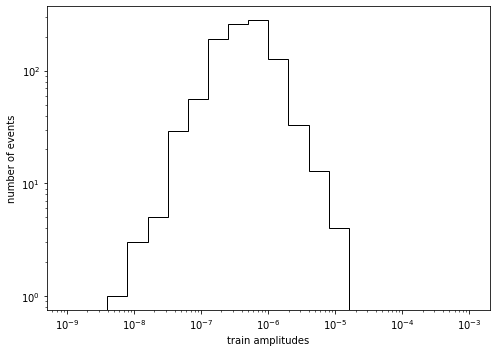

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

bins=np.logspace(-9, -3, 21)

axs.hist(trn_amp, histtype='stepfilled', fill=None, bins=bins)

axs.set_yscale('log')
axs.set_xscale('log')

axs.set_xlabel("train amplitudes")#, fontproperties=axislabelfont)
axs.set_ylabel("number of events")#, fontproperties=axislabelfont)

#xticks = axs.get_xticks()
#axs.set_xticklabels(xticks, fontproperties=tickfont)

#yticks = axs.get_yticks()
#axs.set_yticklabels(yticks, fontproperties=tickfont)

fig.tight_layout()

The amplitudes span about 4 orders of magnitude...

### Plotting the leading photon $p_T$.

In [8]:
trn_dat_leading_photon_pt = get_pt(trn_dat[:, 2])

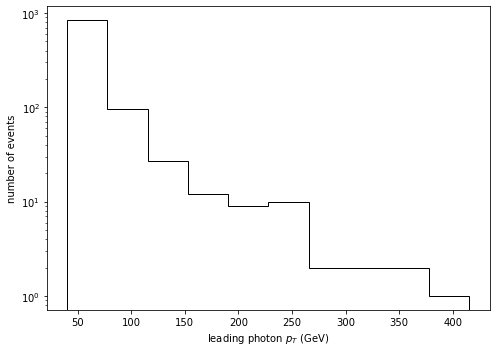

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

axs.hist(trn_dat_leading_photon_pt, histtype='stepfilled', fill=None)

axs.set_yscale('log')

axs.set_xlabel("leading photon $p_T$ (GeV)")#, fontproperties=axislabelfont)
axs.set_ylabel("number of events")#, fontproperties=axislabelfont)

#xticks = axs.get_xticks()
#axs.set_xticklabels(xticks, fontproperties=tickfont)

#yticks = axs.get_yticks()
#axs.set_yticklabels(yticks, fontproperties=tickfont)

fig.tight_layout()

### Plot the final state gluon $p_T$.

In [10]:
trn_dat_gluon_pt = get_pt(trn_dat[:, 4])

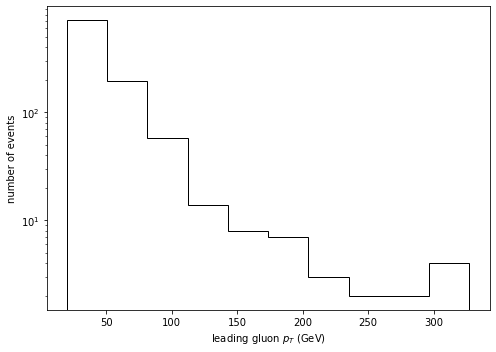

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

axs.hist(trn_dat_gluon_pt, histtype='stepfilled', fill=None)

axs.set_yscale('log')

axs.set_xlabel("leading gluon $p_T$ (GeV)")#, fontproperties=axislabelfont)
axs.set_ylabel("number of events")#, fontproperties=axislabelfont)

#xticks = axs.get_xticks()
#axs.set_xticklabels(xticks, fontproperties=tickfont)

#yticks = axs.get_yticks()
#axs.set_yticklabels(yticks, fontproperties=tickfont)

fig.tight_layout()

## Preprocessing the data

We will be using a dense network, so the data needs to be in vector format.  We will collapse the data for each event to a single vector of dimension $5\times4=20$.  The fact that the data is ordered here is important.  To predict the amplitude given the kinematics, the network needs to know which entries correspond to which particles in the process.

In [12]:
trn_nev = trn_dat.shape[0]
val_nev = val_dat.shape[0]
tst_nev = tst_dat.shape[0]
trn_datf = np.reshape(trn_dat, (trn_nev, -1))
val_datf = np.reshape(val_dat, (val_nev, -1))
tst_datf = np.reshape(tst_dat, (tst_nev, -1))

Check the shape:

In [13]:
trn_datf.shape

(1000, 20)

There are further preprocessing steps we can take.  For example, the inputs are numerically very large $\mathcal{O}(100)$ and span a large range.  So we could re-scale the inputs by a constant number, or even take the logarithm of the inputs.

For now, we'll just re-scale by a constant number, the average final state gluon $p_T$, assuming that this is a natural scale for the problem.  And we should be careful to preprocess the train, validation, and test data in the exact same way.

In [14]:
gpt = np.mean(trn_dat_gluon_pt)
trn_datf = trn_datf / gpt
val_datf = val_datf / gpt
tst_datf = tst_datf / gpt

Now convert them to pytorch tensors.

In [15]:
trn_datfp = torch.Tensor(trn_datf)
val_datfp = torch.Tensor(val_datf)
tst_datfp = torch.Tensor(tst_datf)

We should also preprocess the amplitude data.  As we seen in a plot above, the amplitudes span about 4 orders of magnitude.  This could be difficult for the network to interpolate.  We can aleviate the problem with preprocessing, taking the logarithm of the amplitudes.

In [16]:
trn_ampl = np.log(trn_amp)
val_ampl = np.log(val_amp)
tst_ampl = np.log(tst_amp)

In [17]:
trn_amplp = torch.Tensor(trn_ampl)
val_amplp = torch.Tensor(val_ampl)
tst_amplp = torch.Tensor(tst_ampl)

The new distribution looks nicer:

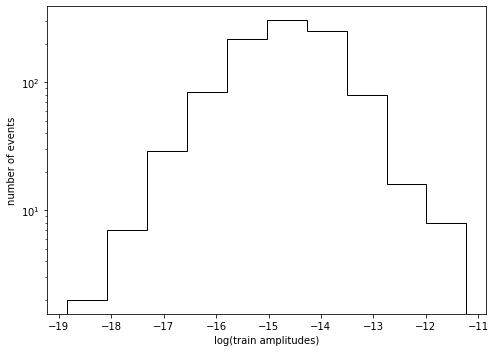

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

axs.hist(trn_ampl, histtype='stepfilled', fill=None)

axs.set_yscale('log')

axs.set_xlabel("log(train amplitudes)")
axs.set_ylabel("number of events",)

fig.tight_layout()

## Datasets and dataloaders

First define a class for the datasets.

In [19]:
class amp_dataset(Dataset):

    def __init__(self, data, amp):
        self.data = data
        self.amp = amp

    def __len__(self):
        return len(self.amp)

    def __getitem__(self, idx):
        return self.data[idx], self.amp[idx]

Then initialise them with the data and amplitudes.  We use unsqueeze here so that the shape of the amplitudes matches the shape output from the neural network.

In [20]:
trn_dataset = amp_dataset(trn_datfp, trn_amplp.unsqueeze(-1))
val_dataset = amp_dataset(val_datfp, val_amplp.unsqueeze(-1))
tst_dataset = amp_dataset(tst_datfp, tst_amplp.unsqueeze(-1))

Now we can define a dataloader for each of these datasets.

In [21]:
trn_dataloader = DataLoader(trn_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
tst_dataloader = DataLoader(tst_dataset, batch_size=64, shuffle=True)

And we can check that the shape for the kinematic data and amplitudes come out correct.

## Building the neural network

Now we build a very simple class for our neural network, which we call amp_net.

In [22]:
class amp_net(nn.Module):
    
    # default hdn_dim is 30, but can be changed upon initialisation
    def __init__(self, hdn_dim=3):
        
        super(amp_net, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(ipt_dim, hdn_dim),
            nn.ReLU(),
            nn.Linear(hdn_dim, hdn_dim),
            nn.ReLU(),
            nn.Linear(hdn_dim, hdn_dim),
            nn.ReLU(),
            nn.Linear(hdn_dim, hdn_dim),
            nn.ReLU(),
            nn.Linear(hdn_dim, opt_dim),
        )

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out

Check if we have a GPU.

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Optimising (training) the neural network

We need to decide what function we want the neural network to optimise, i.e. the loss function.  There are a number of choices to decide from, the key point is that the loss function should be minimised when the neural network correctly predicts the amplitude given the kinematical information on the event.  For this we'll use the MSE, the mean squared error.

$\text{MSE} = ( \text{pred_amp} - \text{true_amp} )^2 $

In [24]:
loss_fn = nn.MSELoss()

PyTorch will compute gradients of this loss function with respect to the trainable parameters of the network.  The network is optimised by updating the parameters using the gradients.  The exact scheme to do this is defined by our choice of optimiser.  A standard choice is the Adam optimiser, which we will use here with it's default hyper-parameters.

You can read more about this optimiser here:
 - https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
 - https://arxiv.org/abs/1412.6980

We've already set the batch size when defining the dataloaders.  Below we set the number of epochs, i.e. the number of times we will iterate through the training data to optimise the network.  This means that the total number of updates to the network parameters will be $\simeq\text{size of dataset}\times \text{epochs} / \text{batch size}$.

Now we can write a training loop for a single epoch.

In [25]:
def train_epoch(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)

    loss_during_opt = 0.
    
    for batch, (X, y) in enumerate(dataloader):

        # pass data through network
        pred = model(X)
        
        # compute loss
        loss = loss_fn(pred, y)
        loss_during_opt += loss.item()

        # reset gradients in optimizer
        optimizer.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # update weights with optimizer
        optimizer.step()
        
        # print the training loss every 100 updates
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print( f"current batch loss: {loss:>7f}  [{current:>5d}/{size:>5d}]" )
    
    loss_live = loss_during_opt/len(dataloader)
    print(f"avg train loss per batch in training: {loss_live:>8f}")        
    return loss_live

To monitor the performance of the network on the regression task we want to calculate the loss of both the training data and the validation data on the same network, so we have the following functions:

In [26]:
def val_pass(dataloader, model, loss_fn):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    vl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            vl += loss_fn(pred, y).item()

    vl /= num_batches
    print(f"avg val loss per batch: {vl:>8f}")
    
    return vl

def trn_pass(dataloader, model, loss_fn):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    tl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            tl += loss_fn(pred, y).item()

    tl /= num_batches
    print( f"avg trn loss per batch: {tl:>8f}" )
    
    return tl

Now we can train the model!

In [27]:
# a useful function to present things clearer
def seperator():
    print( "-----------------------------------------------" )

# define parameters
ipt_dim = 20
opt_dim = 1
hdn_dim = 50
batch_size = 64

trn_dataset = amp_dataset(trn_datfp.to(device), trn_amplp.unsqueeze(-1).to(device))
val_dataset = amp_dataset(val_datfp.to(device), val_amplp.unsqueeze(-1).to(device))
tst_dataset = amp_dataset(tst_datfp.to(device), tst_amplp.unsqueeze(-1).to(device))

trn_dataloader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
tst_dataloader = DataLoader(tst_dataset, batch_size=batch_size, shuffle=True)
epochs = 1500

# re-initialise the model and the optimizer
hdn_dim = 50
model = amp_net(hdn_dim=hdn_dim).to(device)
learning_rate = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
seperator()
print("model architecture ")
seperator()
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")


# track train and val losses
trn_losses_live = []
trn_losses = []
val_losses = []

for t in range(epochs):
    seperator()
    print(f"Epoch {t+1}")
    seperator()
    trn_loss_live = train_epoch(trn_dataloader, model, loss_fn, optimizer)
    trn_losses_live.append(trn_loss_live)
    seperator()
    trn_loss = trn_pass(trn_dataloader, model, loss_fn)
    trn_losses.append(trn_loss)
    seperator()
    val_loss = val_pass(val_dataloader, model, loss_fn)
    val_losses.append(val_loss)
    seperator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture 
-----------------------------------------------
amp_net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)
Model has 8751 trainable parameters
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 209.814240  [    0/ 1000]
avg train loss per batch in training: 208.334886
-----------------------------------------------
avg trn loss per batch: 204.623249
-----------------------------------------------
avg val loss per batch: 206.239863
-----------------------------------------------
|
--------------------

avg val loss per batch: 9.801438
-----------------------------------------------
|
-----------------------------------------------
Epoch 20
-----------------------------------------------
current batch loss: 8.219115  [    0/ 1000]
avg train loss per batch in training: 7.474255
-----------------------------------------------
avg trn loss per batch: 6.400927
-----------------------------------------------
avg val loss per batch: 7.526695
-----------------------------------------------
|
-----------------------------------------------
Epoch 21
-----------------------------------------------
current batch loss: 5.969715  [    0/ 1000]
avg train loss per batch in training: 5.625302
-----------------------------------------------
avg trn loss per batch: 4.721328
-----------------------------------------------
avg val loss per batch: 5.724062
-----------------------------------------------
|
-----------------------------------------------
Epoch 22
--------------------------------------------

avg val loss per batch: 0.791712
-----------------------------------------------
|
-----------------------------------------------
Epoch 41
-----------------------------------------------
current batch loss: 0.626506  [    0/ 1000]
avg train loss per batch in training: 0.495455
-----------------------------------------------
avg trn loss per batch: 0.478361
-----------------------------------------------
avg val loss per batch: 0.800569
-----------------------------------------------
|
-----------------------------------------------
Epoch 42
-----------------------------------------------
current batch loss: 0.523643  [    0/ 1000]
avg train loss per batch in training: 0.479311
-----------------------------------------------
avg trn loss per batch: 0.462220
-----------------------------------------------
avg val loss per batch: 0.774748
-----------------------------------------------
|
-----------------------------------------------
Epoch 43
--------------------------------------------

avg val loss per batch: 0.595987
-----------------------------------------------
|
-----------------------------------------------
Epoch 62
-----------------------------------------------
current batch loss: 0.256488  [    0/ 1000]
avg train loss per batch in training: 0.312738
-----------------------------------------------
avg trn loss per batch: 0.302029
-----------------------------------------------
avg val loss per batch: 0.579469
-----------------------------------------------
|
-----------------------------------------------
Epoch 63
-----------------------------------------------
current batch loss: 0.310441  [    0/ 1000]
avg train loss per batch in training: 0.302144
-----------------------------------------------
avg trn loss per batch: 0.293263
-----------------------------------------------
avg val loss per batch: 0.583808
-----------------------------------------------
|
-----------------------------------------------
Epoch 64
--------------------------------------------

avg val loss per batch: 0.476618
-----------------------------------------------
|
-----------------------------------------------
Epoch 83
-----------------------------------------------
current batch loss: 0.282469  [    0/ 1000]
avg train loss per batch in training: 0.262127
-----------------------------------------------
avg trn loss per batch: 0.225016
-----------------------------------------------
avg val loss per batch: 0.503273
-----------------------------------------------
|
-----------------------------------------------
Epoch 84
-----------------------------------------------
current batch loss: 0.248178  [    0/ 1000]
avg train loss per batch in training: 0.231240
-----------------------------------------------
avg trn loss per batch: 0.220097
-----------------------------------------------
avg val loss per batch: 0.468068
-----------------------------------------------
|
-----------------------------------------------
Epoch 85
--------------------------------------------

avg val loss per batch: 0.450193
-----------------------------------------------
|
-----------------------------------------------
Epoch 104
-----------------------------------------------
current batch loss: 0.181630  [    0/ 1000]
avg train loss per batch in training: 0.183522
-----------------------------------------------
avg trn loss per batch: 0.200639
-----------------------------------------------
avg val loss per batch: 0.421758
-----------------------------------------------
|
-----------------------------------------------
Epoch 105
-----------------------------------------------
current batch loss: 0.218766  [    0/ 1000]
avg train loss per batch in training: 0.190272
-----------------------------------------------
avg trn loss per batch: 0.191628
-----------------------------------------------
avg val loss per batch: 0.459678
-----------------------------------------------
|
-----------------------------------------------
Epoch 106
-----------------------------------------

avg val loss per batch: 0.384371
-----------------------------------------------
|
-----------------------------------------------
Epoch 125
-----------------------------------------------
current batch loss: 0.152966  [    0/ 1000]
avg train loss per batch in training: 0.158388
-----------------------------------------------
avg trn loss per batch: 0.153531
-----------------------------------------------
avg val loss per batch: 0.397756
-----------------------------------------------
|
-----------------------------------------------
Epoch 126
-----------------------------------------------
current batch loss: 0.196001  [    0/ 1000]
avg train loss per batch in training: 0.163460
-----------------------------------------------
avg trn loss per batch: 0.167125
-----------------------------------------------
avg val loss per batch: 0.393734
-----------------------------------------------
|
-----------------------------------------------
Epoch 127
-----------------------------------------

avg val loss per batch: 0.372893
-----------------------------------------------
|
-----------------------------------------------
Epoch 146
-----------------------------------------------
current batch loss: 0.177558  [    0/ 1000]
avg train loss per batch in training: 0.142999
-----------------------------------------------
avg trn loss per batch: 0.142093
-----------------------------------------------
avg val loss per batch: 0.389144
-----------------------------------------------
|
-----------------------------------------------
Epoch 147
-----------------------------------------------
current batch loss: 0.101977  [    0/ 1000]
avg train loss per batch in training: 0.138923
-----------------------------------------------
avg trn loss per batch: 0.152770
-----------------------------------------------
avg val loss per batch: 0.411715
-----------------------------------------------
|
-----------------------------------------------
Epoch 148
-----------------------------------------

avg val loss per batch: 0.351058
-----------------------------------------------
|
-----------------------------------------------
Epoch 167
-----------------------------------------------
current batch loss: 0.100451  [    0/ 1000]
avg train loss per batch in training: 0.129092
-----------------------------------------------
avg trn loss per batch: 0.122638
-----------------------------------------------
avg val loss per batch: 0.360272
-----------------------------------------------
|
-----------------------------------------------
Epoch 168
-----------------------------------------------
current batch loss: 0.122438  [    0/ 1000]
avg train loss per batch in training: 0.129095
-----------------------------------------------
avg trn loss per batch: 0.126190
-----------------------------------------------
avg val loss per batch: 0.352753
-----------------------------------------------
|
-----------------------------------------------
Epoch 169
-----------------------------------------

avg val loss per batch: 0.341459
-----------------------------------------------
|
-----------------------------------------------
Epoch 188
-----------------------------------------------
current batch loss: 0.093268  [    0/ 1000]
avg train loss per batch in training: 0.121171
-----------------------------------------------
avg trn loss per batch: 0.117163
-----------------------------------------------
avg val loss per batch: 0.347271
-----------------------------------------------
|
-----------------------------------------------
Epoch 189
-----------------------------------------------
current batch loss: 0.103445  [    0/ 1000]
avg train loss per batch in training: 0.120100
-----------------------------------------------
avg trn loss per batch: 0.123041
-----------------------------------------------
avg val loss per batch: 0.370784
-----------------------------------------------
|
-----------------------------------------------
Epoch 190
-----------------------------------------

avg val loss per batch: 0.324666
-----------------------------------------------
|
-----------------------------------------------
Epoch 209
-----------------------------------------------
current batch loss: 0.080091  [    0/ 1000]
avg train loss per batch in training: 0.111376
-----------------------------------------------
avg trn loss per batch: 0.110340
-----------------------------------------------
avg val loss per batch: 0.329324
-----------------------------------------------
|
-----------------------------------------------
Epoch 210
-----------------------------------------------
current batch loss: 0.115334  [    0/ 1000]
avg train loss per batch in training: 0.119651
-----------------------------------------------
avg trn loss per batch: 0.105327
-----------------------------------------------
avg val loss per batch: 0.332141
-----------------------------------------------
|
-----------------------------------------------
Epoch 211
-----------------------------------------

avg val loss per batch: 0.360653
-----------------------------------------------
|
-----------------------------------------------
Epoch 230
-----------------------------------------------
current batch loss: 0.124197  [    0/ 1000]
avg train loss per batch in training: 0.107490
-----------------------------------------------
avg trn loss per batch: 0.101714
-----------------------------------------------
avg val loss per batch: 0.332496
-----------------------------------------------
|
-----------------------------------------------
Epoch 231
-----------------------------------------------
current batch loss: 0.105330  [    0/ 1000]
avg train loss per batch in training: 0.107258
-----------------------------------------------
avg trn loss per batch: 0.101898
-----------------------------------------------
avg val loss per batch: 0.320300
-----------------------------------------------
|
-----------------------------------------------
Epoch 232
-----------------------------------------

avg val loss per batch: 0.316117
-----------------------------------------------
|
-----------------------------------------------
Epoch 251
-----------------------------------------------
current batch loss: 0.092300  [    0/ 1000]
avg train loss per batch in training: 0.104661
-----------------------------------------------
avg trn loss per batch: 0.119695
-----------------------------------------------
avg val loss per batch: 0.319360
-----------------------------------------------
|
-----------------------------------------------
Epoch 252
-----------------------------------------------
current batch loss: 0.118948  [    0/ 1000]
avg train loss per batch in training: 0.108506
-----------------------------------------------
avg trn loss per batch: 0.095185
-----------------------------------------------
avg val loss per batch: 0.315348
-----------------------------------------------
|
-----------------------------------------------
Epoch 253
-----------------------------------------

avg val loss per batch: 0.307277
-----------------------------------------------
|
-----------------------------------------------
Epoch 272
-----------------------------------------------
current batch loss: 0.087381  [    0/ 1000]
avg train loss per batch in training: 0.096219
-----------------------------------------------
avg trn loss per batch: 0.094978
-----------------------------------------------
avg val loss per batch: 0.298094
-----------------------------------------------
|
-----------------------------------------------
Epoch 273
-----------------------------------------------
current batch loss: 0.063144  [    0/ 1000]
avg train loss per batch in training: 0.094661
-----------------------------------------------
avg trn loss per batch: 0.093033
-----------------------------------------------
avg val loss per batch: 0.317033
-----------------------------------------------
|
-----------------------------------------------
Epoch 274
-----------------------------------------

avg val loss per batch: 0.296443
-----------------------------------------------
|
-----------------------------------------------
Epoch 293
-----------------------------------------------
current batch loss: 0.102415  [    0/ 1000]
avg train loss per batch in training: 0.092885
-----------------------------------------------
avg trn loss per batch: 0.096081
-----------------------------------------------
avg val loss per batch: 0.293743
-----------------------------------------------
|
-----------------------------------------------
Epoch 294
-----------------------------------------------
current batch loss: 0.087548  [    0/ 1000]
avg train loss per batch in training: 0.092937
-----------------------------------------------
avg trn loss per batch: 0.088803
-----------------------------------------------
avg val loss per batch: 0.299506
-----------------------------------------------
|
-----------------------------------------------
Epoch 295
-----------------------------------------

avg val loss per batch: 0.291290
-----------------------------------------------
|
-----------------------------------------------
Epoch 314
-----------------------------------------------
current batch loss: 0.089926  [    0/ 1000]
avg train loss per batch in training: 0.094592
-----------------------------------------------
avg trn loss per batch: 0.102298
-----------------------------------------------
avg val loss per batch: 0.343007
-----------------------------------------------
|
-----------------------------------------------
Epoch 315
-----------------------------------------------
current batch loss: 0.096258  [    0/ 1000]
avg train loss per batch in training: 0.105583
-----------------------------------------------
avg trn loss per batch: 0.087619
-----------------------------------------------
avg val loss per batch: 0.288424
-----------------------------------------------
|
-----------------------------------------------
Epoch 316
-----------------------------------------

avg val loss per batch: 0.328209
-----------------------------------------------
|
-----------------------------------------------
Epoch 335
-----------------------------------------------
current batch loss: 0.109905  [    0/ 1000]
avg train loss per batch in training: 0.086076
-----------------------------------------------
avg trn loss per batch: 0.083477
-----------------------------------------------
avg val loss per batch: 0.303076
-----------------------------------------------
|
-----------------------------------------------
Epoch 336
-----------------------------------------------
current batch loss: 0.082285  [    0/ 1000]
avg train loss per batch in training: 0.104205
-----------------------------------------------
avg trn loss per batch: 0.103718
-----------------------------------------------
avg val loss per batch: 0.284084
-----------------------------------------------
|
-----------------------------------------------
Epoch 337
-----------------------------------------

avg val loss per batch: 0.274633
-----------------------------------------------
|
-----------------------------------------------
Epoch 356
-----------------------------------------------
current batch loss: 0.085770  [    0/ 1000]
avg train loss per batch in training: 0.083520
-----------------------------------------------
avg trn loss per batch: 0.079513
-----------------------------------------------
avg val loss per batch: 0.293987
-----------------------------------------------
|
-----------------------------------------------
Epoch 357
-----------------------------------------------
current batch loss: 0.055173  [    0/ 1000]
avg train loss per batch in training: 0.094416
-----------------------------------------------
avg trn loss per batch: 0.076439
-----------------------------------------------
avg val loss per batch: 0.283802
-----------------------------------------------
|
-----------------------------------------------
Epoch 358
-----------------------------------------

avg val loss per batch: 0.278067
-----------------------------------------------
|
-----------------------------------------------
Epoch 377
-----------------------------------------------
current batch loss: 0.051164  [    0/ 1000]
avg train loss per batch in training: 0.075621
-----------------------------------------------
avg trn loss per batch: 0.072439
-----------------------------------------------
avg val loss per batch: 0.270589
-----------------------------------------------
|
-----------------------------------------------
Epoch 378
-----------------------------------------------
current batch loss: 0.067357  [    0/ 1000]
avg train loss per batch in training: 0.074935
-----------------------------------------------
avg trn loss per batch: 0.076565
-----------------------------------------------
avg val loss per batch: 0.281694
-----------------------------------------------
|
-----------------------------------------------
Epoch 379
-----------------------------------------

avg val loss per batch: 0.307474
-----------------------------------------------
|
-----------------------------------------------
Epoch 398
-----------------------------------------------
current batch loss: 0.129896  [    0/ 1000]
avg train loss per batch in training: 0.106531
-----------------------------------------------
avg trn loss per batch: 0.074936
-----------------------------------------------
avg val loss per batch: 0.273517
-----------------------------------------------
|
-----------------------------------------------
Epoch 399
-----------------------------------------------
current batch loss: 0.058585  [    0/ 1000]
avg train loss per batch in training: 0.087634
-----------------------------------------------
avg trn loss per batch: 0.081107
-----------------------------------------------
avg val loss per batch: 0.260637
-----------------------------------------------
|
-----------------------------------------------
Epoch 400
-----------------------------------------

avg val loss per batch: 0.263857
-----------------------------------------------
|
-----------------------------------------------
Epoch 419
-----------------------------------------------
current batch loss: 0.047779  [    0/ 1000]
avg train loss per batch in training: 0.067079
-----------------------------------------------
avg trn loss per batch: 0.065952
-----------------------------------------------
avg val loss per batch: 0.266928
-----------------------------------------------
|
-----------------------------------------------
Epoch 420
-----------------------------------------------
current batch loss: 0.065892  [    0/ 1000]
avg train loss per batch in training: 0.069792
-----------------------------------------------
avg trn loss per batch: 0.066279
-----------------------------------------------
avg val loss per batch: 0.259291
-----------------------------------------------
|
-----------------------------------------------
Epoch 421
-----------------------------------------

avg val loss per batch: 0.249204
-----------------------------------------------
|
-----------------------------------------------
Epoch 440
-----------------------------------------------
current batch loss: 0.080639  [    0/ 1000]
avg train loss per batch in training: 0.067828
-----------------------------------------------
avg trn loss per batch: 0.064419
-----------------------------------------------
avg val loss per batch: 0.272288
-----------------------------------------------
|
-----------------------------------------------
Epoch 441
-----------------------------------------------
current batch loss: 0.073223  [    0/ 1000]
avg train loss per batch in training: 0.067318
-----------------------------------------------
avg trn loss per batch: 0.061384
-----------------------------------------------
avg val loss per batch: 0.248842
-----------------------------------------------
|
-----------------------------------------------
Epoch 442
-----------------------------------------

avg val loss per batch: 0.260048
-----------------------------------------------
|
-----------------------------------------------
Epoch 461
-----------------------------------------------
current batch loss: 0.067123  [    0/ 1000]
avg train loss per batch in training: 0.064281
-----------------------------------------------
avg trn loss per batch: 0.059967
-----------------------------------------------
avg val loss per batch: 0.252517
-----------------------------------------------
|
-----------------------------------------------
Epoch 462
-----------------------------------------------
current batch loss: 0.052011  [    0/ 1000]
avg train loss per batch in training: 0.064690
-----------------------------------------------
avg trn loss per batch: 0.064666
-----------------------------------------------
avg val loss per batch: 0.249468
-----------------------------------------------
|
-----------------------------------------------
Epoch 463
-----------------------------------------

avg val loss per batch: 0.259943
-----------------------------------------------
|
-----------------------------------------------
Epoch 482
-----------------------------------------------
current batch loss: 0.066545  [    0/ 1000]
avg train loss per batch in training: 0.061672
-----------------------------------------------
avg trn loss per batch: 0.061989
-----------------------------------------------
avg val loss per batch: 0.261356
-----------------------------------------------
|
-----------------------------------------------
Epoch 483
-----------------------------------------------
current batch loss: 0.074992  [    0/ 1000]
avg train loss per batch in training: 0.065872
-----------------------------------------------
avg trn loss per batch: 0.068187
-----------------------------------------------
avg val loss per batch: 0.247698
-----------------------------------------------
|
-----------------------------------------------
Epoch 484
-----------------------------------------

avg val loss per batch: 0.243612
-----------------------------------------------
|
-----------------------------------------------
Epoch 503
-----------------------------------------------
current batch loss: 0.050610  [    0/ 1000]
avg train loss per batch in training: 0.060657
-----------------------------------------------
avg trn loss per batch: 0.053259
-----------------------------------------------
avg val loss per batch: 0.250289
-----------------------------------------------
|
-----------------------------------------------
Epoch 504
-----------------------------------------------
current batch loss: 0.064358  [    0/ 1000]
avg train loss per batch in training: 0.056590
-----------------------------------------------
avg trn loss per batch: 0.058429
-----------------------------------------------
avg val loss per batch: 0.238990
-----------------------------------------------
|
-----------------------------------------------
Epoch 505
-----------------------------------------

avg val loss per batch: 0.245023
-----------------------------------------------
|
-----------------------------------------------
Epoch 524
-----------------------------------------------
current batch loss: 0.051542  [    0/ 1000]
avg train loss per batch in training: 0.060078
-----------------------------------------------
avg trn loss per batch: 0.056280
-----------------------------------------------
avg val loss per batch: 0.265482
-----------------------------------------------
|
-----------------------------------------------
Epoch 525
-----------------------------------------------
current batch loss: 0.046556  [    0/ 1000]
avg train loss per batch in training: 0.058267
-----------------------------------------------
avg trn loss per batch: 0.060090
-----------------------------------------------
avg val loss per batch: 0.271687
-----------------------------------------------
|
-----------------------------------------------
Epoch 526
-----------------------------------------

avg val loss per batch: 0.294909
-----------------------------------------------
|
-----------------------------------------------
Epoch 545
-----------------------------------------------
current batch loss: 0.075512  [    0/ 1000]
avg train loss per batch in training: 0.060153
-----------------------------------------------
avg trn loss per batch: 0.051539
-----------------------------------------------
avg val loss per batch: 0.230104
-----------------------------------------------
|
-----------------------------------------------
Epoch 546
-----------------------------------------------
current batch loss: 0.064394  [    0/ 1000]
avg train loss per batch in training: 0.052854
-----------------------------------------------
avg trn loss per batch: 0.050954
-----------------------------------------------
avg val loss per batch: 0.252850
-----------------------------------------------
|
-----------------------------------------------
Epoch 547
-----------------------------------------

avg val loss per batch: 0.236004
-----------------------------------------------
|
-----------------------------------------------
Epoch 566
-----------------------------------------------
current batch loss: 0.067950  [    0/ 1000]
avg train loss per batch in training: 0.050057
-----------------------------------------------
avg trn loss per batch: 0.053070
-----------------------------------------------
avg val loss per batch: 0.238312
-----------------------------------------------
|
-----------------------------------------------
Epoch 567
-----------------------------------------------
current batch loss: 0.051505  [    0/ 1000]
avg train loss per batch in training: 0.053391
-----------------------------------------------
avg trn loss per batch: 0.047317
-----------------------------------------------
avg val loss per batch: 0.242742
-----------------------------------------------
|
-----------------------------------------------
Epoch 568
-----------------------------------------

avg val loss per batch: 0.229065
-----------------------------------------------
|
-----------------------------------------------
Epoch 587
-----------------------------------------------
current batch loss: 0.071830  [    0/ 1000]
avg train loss per batch in training: 0.061253
-----------------------------------------------
avg trn loss per batch: 0.052245
-----------------------------------------------
avg val loss per batch: 0.252559
-----------------------------------------------
|
-----------------------------------------------
Epoch 588
-----------------------------------------------
current batch loss: 0.048043  [    0/ 1000]
avg train loss per batch in training: 0.068759
-----------------------------------------------
avg trn loss per batch: 0.058685
-----------------------------------------------
avg val loss per batch: 0.268641
-----------------------------------------------
|
-----------------------------------------------
Epoch 589
-----------------------------------------

avg val loss per batch: 0.243517
-----------------------------------------------
|
-----------------------------------------------
Epoch 608
-----------------------------------------------
current batch loss: 0.045028  [    0/ 1000]
avg train loss per batch in training: 0.047882
-----------------------------------------------
avg trn loss per batch: 0.042711
-----------------------------------------------
avg val loss per batch: 0.236039
-----------------------------------------------
|
-----------------------------------------------
Epoch 609
-----------------------------------------------
current batch loss: 0.040146  [    0/ 1000]
avg train loss per batch in training: 0.045477
-----------------------------------------------
avg trn loss per batch: 0.046551
-----------------------------------------------
avg val loss per batch: 0.260006
-----------------------------------------------
|
-----------------------------------------------
Epoch 610
-----------------------------------------

avg val loss per batch: 0.258236
-----------------------------------------------
|
-----------------------------------------------
Epoch 629
-----------------------------------------------
current batch loss: 0.047823  [    0/ 1000]
avg train loss per batch in training: 0.045484
-----------------------------------------------
avg trn loss per batch: 0.049417
-----------------------------------------------
avg val loss per batch: 0.229881
-----------------------------------------------
|
-----------------------------------------------
Epoch 630
-----------------------------------------------
current batch loss: 0.043444  [    0/ 1000]
avg train loss per batch in training: 0.046506
-----------------------------------------------
avg trn loss per batch: 0.039927
-----------------------------------------------
avg val loss per batch: 0.235567
-----------------------------------------------
|
-----------------------------------------------
Epoch 631
-----------------------------------------

avg val loss per batch: 0.235448
-----------------------------------------------
|
-----------------------------------------------
Epoch 650
-----------------------------------------------
current batch loss: 0.038034  [    0/ 1000]
avg train loss per batch in training: 0.043036
-----------------------------------------------
avg trn loss per batch: 0.039003
-----------------------------------------------
avg val loss per batch: 0.228940
-----------------------------------------------
|
-----------------------------------------------
Epoch 651
-----------------------------------------------
current batch loss: 0.029604  [    0/ 1000]
avg train loss per batch in training: 0.048312
-----------------------------------------------
avg trn loss per batch: 0.041872
-----------------------------------------------
avg val loss per batch: 0.252766
-----------------------------------------------
|
-----------------------------------------------
Epoch 652
-----------------------------------------

avg val loss per batch: 0.290226
-----------------------------------------------
|
-----------------------------------------------
Epoch 671
-----------------------------------------------
current batch loss: 0.072080  [    0/ 1000]
avg train loss per batch in training: 0.054188
-----------------------------------------------
avg trn loss per batch: 0.048781
-----------------------------------------------
avg val loss per batch: 0.236248
-----------------------------------------------
|
-----------------------------------------------
Epoch 672
-----------------------------------------------
current batch loss: 0.044368  [    0/ 1000]
avg train loss per batch in training: 0.041387
-----------------------------------------------
avg trn loss per batch: 0.040172
-----------------------------------------------
avg val loss per batch: 0.228521
-----------------------------------------------
|
-----------------------------------------------
Epoch 673
-----------------------------------------

avg val loss per batch: 0.233940
-----------------------------------------------
|
-----------------------------------------------
Epoch 692
-----------------------------------------------
current batch loss: 0.029252  [    0/ 1000]
avg train loss per batch in training: 0.037682
-----------------------------------------------
avg trn loss per batch: 0.035443
-----------------------------------------------
avg val loss per batch: 0.234805
-----------------------------------------------
|
-----------------------------------------------
Epoch 693
-----------------------------------------------
current batch loss: 0.025576  [    0/ 1000]
avg train loss per batch in training: 0.038318
-----------------------------------------------
avg trn loss per batch: 0.036854
-----------------------------------------------
avg val loss per batch: 0.239138
-----------------------------------------------
|
-----------------------------------------------
Epoch 694
-----------------------------------------

avg val loss per batch: 0.224398
-----------------------------------------------
|
-----------------------------------------------
Epoch 713
-----------------------------------------------
current batch loss: 0.034419  [    0/ 1000]
avg train loss per batch in training: 0.037184
-----------------------------------------------
avg trn loss per batch: 0.040249
-----------------------------------------------
avg val loss per batch: 0.242030
-----------------------------------------------
|
-----------------------------------------------
Epoch 714
-----------------------------------------------
current batch loss: 0.048438  [    0/ 1000]
avg train loss per batch in training: 0.042070
-----------------------------------------------
avg trn loss per batch: 0.036527
-----------------------------------------------
avg val loss per batch: 0.221377
-----------------------------------------------
|
-----------------------------------------------
Epoch 715
-----------------------------------------

avg val loss per batch: 0.254508
-----------------------------------------------
|
-----------------------------------------------
Epoch 734
-----------------------------------------------
current batch loss: 0.059795  [    0/ 1000]
avg train loss per batch in training: 0.039326
-----------------------------------------------
avg trn loss per batch: 0.042887
-----------------------------------------------
avg val loss per batch: 0.221305
-----------------------------------------------
|
-----------------------------------------------
Epoch 735
-----------------------------------------------
current batch loss: 0.043225  [    0/ 1000]
avg train loss per batch in training: 0.036129
-----------------------------------------------
avg trn loss per batch: 0.035814
-----------------------------------------------
avg val loss per batch: 0.215161
-----------------------------------------------
|
-----------------------------------------------
Epoch 736
-----------------------------------------

avg val loss per batch: 0.217222
-----------------------------------------------
|
-----------------------------------------------
Epoch 755
-----------------------------------------------
current batch loss: 0.035928  [    0/ 1000]
avg train loss per batch in training: 0.036426
-----------------------------------------------
avg trn loss per batch: 0.039122
-----------------------------------------------
avg val loss per batch: 0.212065
-----------------------------------------------
|
-----------------------------------------------
Epoch 756
-----------------------------------------------
current batch loss: 0.051195  [    0/ 1000]
avg train loss per batch in training: 0.039213
-----------------------------------------------
avg trn loss per batch: 0.043126
-----------------------------------------------
avg val loss per batch: 0.237694
-----------------------------------------------
|
-----------------------------------------------
Epoch 757
-----------------------------------------

avg val loss per batch: 0.234471
-----------------------------------------------
|
-----------------------------------------------
Epoch 776
-----------------------------------------------
current batch loss: 0.031567  [    0/ 1000]
avg train loss per batch in training: 0.037874
-----------------------------------------------
avg trn loss per batch: 0.072053
-----------------------------------------------
avg val loss per batch: 0.294982
-----------------------------------------------
|
-----------------------------------------------
Epoch 777
-----------------------------------------------
current batch loss: 0.080791  [    0/ 1000]
avg train loss per batch in training: 0.057809
-----------------------------------------------
avg trn loss per batch: 0.039012
-----------------------------------------------
avg val loss per batch: 0.238139
-----------------------------------------------
|
-----------------------------------------------
Epoch 778
-----------------------------------------

avg val loss per batch: 0.212413
-----------------------------------------------
|
-----------------------------------------------
Epoch 797
-----------------------------------------------
current batch loss: 0.031682  [    0/ 1000]
avg train loss per batch in training: 0.030422
-----------------------------------------------
avg trn loss per batch: 0.031309
-----------------------------------------------
avg val loss per batch: 0.222869
-----------------------------------------------
|
-----------------------------------------------
Epoch 798
-----------------------------------------------
current batch loss: 0.026055  [    0/ 1000]
avg train loss per batch in training: 0.032609
-----------------------------------------------
avg trn loss per batch: 0.035083
-----------------------------------------------
avg val loss per batch: 0.237218
-----------------------------------------------
|
-----------------------------------------------
Epoch 799
-----------------------------------------

avg val loss per batch: 0.216392
-----------------------------------------------
|
-----------------------------------------------
Epoch 818
-----------------------------------------------
current batch loss: 0.039878  [    0/ 1000]
avg train loss per batch in training: 0.039565
-----------------------------------------------
avg trn loss per batch: 0.060126
-----------------------------------------------
avg val loss per batch: 0.241735
-----------------------------------------------
|
-----------------------------------------------
Epoch 819
-----------------------------------------------
current batch loss: 0.050616  [    0/ 1000]
avg train loss per batch in training: 0.046919
-----------------------------------------------
avg trn loss per batch: 0.032016
-----------------------------------------------
avg val loss per batch: 0.215364
-----------------------------------------------
|
-----------------------------------------------
Epoch 820
-----------------------------------------

avg val loss per batch: 0.218842
-----------------------------------------------
|
-----------------------------------------------
Epoch 839
-----------------------------------------------
current batch loss: 0.030148  [    0/ 1000]
avg train loss per batch in training: 0.029283
-----------------------------------------------
avg trn loss per batch: 0.028099
-----------------------------------------------
avg val loss per batch: 0.235494
-----------------------------------------------
|
-----------------------------------------------
Epoch 840
-----------------------------------------------
current batch loss: 0.032259  [    0/ 1000]
avg train loss per batch in training: 0.033231
-----------------------------------------------
avg trn loss per batch: 0.033637
-----------------------------------------------
avg val loss per batch: 0.255416
-----------------------------------------------
|
-----------------------------------------------
Epoch 841
-----------------------------------------

avg val loss per batch: 0.247216
-----------------------------------------------
|
-----------------------------------------------
Epoch 860
-----------------------------------------------
current batch loss: 0.025547  [    0/ 1000]
avg train loss per batch in training: 0.027170
-----------------------------------------------
avg trn loss per batch: 0.025348
-----------------------------------------------
avg val loss per batch: 0.225437
-----------------------------------------------
|
-----------------------------------------------
Epoch 861
-----------------------------------------------
current batch loss: 0.031599  [    0/ 1000]
avg train loss per batch in training: 0.029457
-----------------------------------------------
avg trn loss per batch: 0.038949
-----------------------------------------------
avg val loss per batch: 0.247463
-----------------------------------------------
|
-----------------------------------------------
Epoch 862
-----------------------------------------

avg val loss per batch: 0.231459
-----------------------------------------------
|
-----------------------------------------------
Epoch 881
-----------------------------------------------
current batch loss: 0.030245  [    0/ 1000]
avg train loss per batch in training: 0.031937
-----------------------------------------------
avg trn loss per batch: 0.036243
-----------------------------------------------
avg val loss per batch: 0.223314
-----------------------------------------------
|
-----------------------------------------------
Epoch 882
-----------------------------------------------
current batch loss: 0.043876  [    0/ 1000]
avg train loss per batch in training: 0.036443
-----------------------------------------------
avg trn loss per batch: 0.032208
-----------------------------------------------
avg val loss per batch: 0.247197
-----------------------------------------------
|
-----------------------------------------------
Epoch 883
-----------------------------------------

avg val loss per batch: 0.236932
-----------------------------------------------
|
-----------------------------------------------
Epoch 902
-----------------------------------------------
current batch loss: 0.020091  [    0/ 1000]
avg train loss per batch in training: 0.027359
-----------------------------------------------
avg trn loss per batch: 0.024975
-----------------------------------------------
avg val loss per batch: 0.222899
-----------------------------------------------
|
-----------------------------------------------
Epoch 903
-----------------------------------------------
current batch loss: 0.020827  [    0/ 1000]
avg train loss per batch in training: 0.027548
-----------------------------------------------
avg trn loss per batch: 0.024745
-----------------------------------------------
avg val loss per batch: 0.229776
-----------------------------------------------
|
-----------------------------------------------
Epoch 904
-----------------------------------------

avg val loss per batch: 0.231348
-----------------------------------------------
|
-----------------------------------------------
Epoch 923
-----------------------------------------------
current batch loss: 0.027384  [    0/ 1000]
avg train loss per batch in training: 0.031637
-----------------------------------------------
avg trn loss per batch: 0.035969
-----------------------------------------------
avg val loss per batch: 0.225748
-----------------------------------------------
|
-----------------------------------------------
Epoch 924
-----------------------------------------------
current batch loss: 0.020851  [    0/ 1000]
avg train loss per batch in training: 0.034409
-----------------------------------------------
avg trn loss per batch: 0.023695
-----------------------------------------------
avg val loss per batch: 0.233376
-----------------------------------------------
|
-----------------------------------------------
Epoch 925
-----------------------------------------

avg val loss per batch: 0.243244
-----------------------------------------------
|
-----------------------------------------------
Epoch 944
-----------------------------------------------
current batch loss: 0.017816  [    0/ 1000]
avg train loss per batch in training: 0.025094
-----------------------------------------------
avg trn loss per batch: 0.022553
-----------------------------------------------
avg val loss per batch: 0.221463
-----------------------------------------------
|
-----------------------------------------------
Epoch 945
-----------------------------------------------
current batch loss: 0.024702  [    0/ 1000]
avg train loss per batch in training: 0.023239
-----------------------------------------------
avg trn loss per batch: 0.023083
-----------------------------------------------
avg val loss per batch: 0.222848
-----------------------------------------------
|
-----------------------------------------------
Epoch 946
-----------------------------------------

avg val loss per batch: 0.244405
-----------------------------------------------
|
-----------------------------------------------
Epoch 965
-----------------------------------------------
current batch loss: 0.023186  [    0/ 1000]
avg train loss per batch in training: 0.025985
-----------------------------------------------
avg trn loss per batch: 0.022783
-----------------------------------------------
avg val loss per batch: 0.239711
-----------------------------------------------
|
-----------------------------------------------
Epoch 966
-----------------------------------------------
current batch loss: 0.017890  [    0/ 1000]
avg train loss per batch in training: 0.022941
-----------------------------------------------
avg trn loss per batch: 0.022156
-----------------------------------------------
avg val loss per batch: 0.229515
-----------------------------------------------
|
-----------------------------------------------
Epoch 967
-----------------------------------------

avg val loss per batch: 0.233786
-----------------------------------------------
|
-----------------------------------------------
Epoch 986
-----------------------------------------------
current batch loss: 0.021619  [    0/ 1000]
avg train loss per batch in training: 0.022804
-----------------------------------------------
avg trn loss per batch: 0.021962
-----------------------------------------------
avg val loss per batch: 0.226038
-----------------------------------------------
|
-----------------------------------------------
Epoch 987
-----------------------------------------------
current batch loss: 0.023854  [    0/ 1000]
avg train loss per batch in training: 0.025373
-----------------------------------------------
avg trn loss per batch: 0.020616
-----------------------------------------------
avg val loss per batch: 0.223561
-----------------------------------------------
|
-----------------------------------------------
Epoch 988
-----------------------------------------

avg val loss per batch: 0.244568
-----------------------------------------------
|
-----------------------------------------------
Epoch 1007
-----------------------------------------------
current batch loss: 0.025593  [    0/ 1000]
avg train loss per batch in training: 0.023042
-----------------------------------------------
avg trn loss per batch: 0.022675
-----------------------------------------------
avg val loss per batch: 0.227642
-----------------------------------------------
|
-----------------------------------------------
Epoch 1008
-----------------------------------------------
current batch loss: 0.023262  [    0/ 1000]
avg train loss per batch in training: 0.025558
-----------------------------------------------
avg trn loss per batch: 0.020287
-----------------------------------------------
avg val loss per batch: 0.228170
-----------------------------------------------
|
-----------------------------------------------
Epoch 1009
--------------------------------------

avg val loss per batch: 0.248063
-----------------------------------------------
|
-----------------------------------------------
Epoch 1027
-----------------------------------------------
current batch loss: 0.025382  [    0/ 1000]
avg train loss per batch in training: 0.028376
-----------------------------------------------
avg trn loss per batch: 0.033554
-----------------------------------------------
avg val loss per batch: 0.253646
-----------------------------------------------
|
-----------------------------------------------
Epoch 1028
-----------------------------------------------
current batch loss: 0.031691  [    0/ 1000]
avg train loss per batch in training: 0.028341
-----------------------------------------------
avg trn loss per batch: 0.021938
-----------------------------------------------
avg val loss per batch: 0.235392
-----------------------------------------------
|
-----------------------------------------------
Epoch 1029
--------------------------------------

avg val loss per batch: 0.228712
-----------------------------------------------
|
-----------------------------------------------
Epoch 1047
-----------------------------------------------
current batch loss: 0.024706  [    0/ 1000]
avg train loss per batch in training: 0.024178
-----------------------------------------------
avg trn loss per batch: 0.028917
-----------------------------------------------
avg val loss per batch: 0.244704
-----------------------------------------------
|
-----------------------------------------------
Epoch 1048
-----------------------------------------------
current batch loss: 0.018477  [    0/ 1000]
avg train loss per batch in training: 0.029845
-----------------------------------------------
avg trn loss per batch: 0.027032
-----------------------------------------------
avg val loss per batch: 0.240416
-----------------------------------------------
|
-----------------------------------------------
Epoch 1049
--------------------------------------

avg val loss per batch: 0.227866
-----------------------------------------------
|
-----------------------------------------------
Epoch 1067
-----------------------------------------------
current batch loss: 0.016012  [    0/ 1000]
avg train loss per batch in training: 0.023882
-----------------------------------------------
avg trn loss per batch: 0.023275
-----------------------------------------------
avg val loss per batch: 0.250274
-----------------------------------------------
|
-----------------------------------------------
Epoch 1068
-----------------------------------------------
current batch loss: 0.029458  [    0/ 1000]
avg train loss per batch in training: 0.022159
-----------------------------------------------
avg trn loss per batch: 0.021598
-----------------------------------------------
avg val loss per batch: 0.254490
-----------------------------------------------
|
-----------------------------------------------
Epoch 1069
--------------------------------------

avg val loss per batch: 0.229199
-----------------------------------------------
|
-----------------------------------------------
Epoch 1087
-----------------------------------------------
current batch loss: 0.031260  [    0/ 1000]
avg train loss per batch in training: 0.022309
-----------------------------------------------
avg trn loss per batch: 0.025505
-----------------------------------------------
avg val loss per batch: 0.219740
-----------------------------------------------
|
-----------------------------------------------
Epoch 1088
-----------------------------------------------
current batch loss: 0.019226  [    0/ 1000]
avg train loss per batch in training: 0.029627
-----------------------------------------------
avg trn loss per batch: 0.033614
-----------------------------------------------
avg val loss per batch: 0.234278
-----------------------------------------------
|
-----------------------------------------------
Epoch 1089
--------------------------------------

avg val loss per batch: 0.220944
-----------------------------------------------
|
-----------------------------------------------
Epoch 1107
-----------------------------------------------
current batch loss: 0.024585  [    0/ 1000]
avg train loss per batch in training: 0.019263
-----------------------------------------------
avg trn loss per batch: 0.019791
-----------------------------------------------
avg val loss per batch: 0.244372
-----------------------------------------------
|
-----------------------------------------------
Epoch 1108
-----------------------------------------------
current batch loss: 0.020778  [    0/ 1000]
avg train loss per batch in training: 0.021815
-----------------------------------------------
avg trn loss per batch: 0.026051
-----------------------------------------------
avg val loss per batch: 0.219729
-----------------------------------------------
|
-----------------------------------------------
Epoch 1109
--------------------------------------

avg val loss per batch: 0.221836
-----------------------------------------------
|
-----------------------------------------------
Epoch 1127
-----------------------------------------------
current batch loss: 0.021533  [    0/ 1000]
avg train loss per batch in training: 0.024964
-----------------------------------------------
avg trn loss per batch: 0.019084
-----------------------------------------------
avg val loss per batch: 0.226505
-----------------------------------------------
|
-----------------------------------------------
Epoch 1128
-----------------------------------------------
current batch loss: 0.019477  [    0/ 1000]
avg train loss per batch in training: 0.019454
-----------------------------------------------
avg trn loss per batch: 0.018621
-----------------------------------------------
avg val loss per batch: 0.237927
-----------------------------------------------
|
-----------------------------------------------
Epoch 1129
--------------------------------------

avg val loss per batch: 0.233002
-----------------------------------------------
|
-----------------------------------------------
Epoch 1147
-----------------------------------------------
current batch loss: 0.016924  [    0/ 1000]
avg train loss per batch in training: 0.018581
-----------------------------------------------
avg trn loss per batch: 0.017701
-----------------------------------------------
avg val loss per batch: 0.224645
-----------------------------------------------
|
-----------------------------------------------
Epoch 1148
-----------------------------------------------
current batch loss: 0.021411  [    0/ 1000]
avg train loss per batch in training: 0.019203
-----------------------------------------------
avg trn loss per batch: 0.025107
-----------------------------------------------
avg val loss per batch: 0.257464
-----------------------------------------------
|
-----------------------------------------------
Epoch 1149
--------------------------------------

avg val loss per batch: 0.240104
-----------------------------------------------
|
-----------------------------------------------
Epoch 1167
-----------------------------------------------
current batch loss: 0.019908  [    0/ 1000]
avg train loss per batch in training: 0.020892
-----------------------------------------------
avg trn loss per batch: 0.018784
-----------------------------------------------
avg val loss per batch: 0.236194
-----------------------------------------------
|
-----------------------------------------------
Epoch 1168
-----------------------------------------------
current batch loss: 0.018597  [    0/ 1000]
avg train loss per batch in training: 0.023119
-----------------------------------------------
avg trn loss per batch: 0.019282
-----------------------------------------------
avg val loss per batch: 0.235289
-----------------------------------------------
|
-----------------------------------------------
Epoch 1169
--------------------------------------

avg val loss per batch: 0.286787
-----------------------------------------------
|
-----------------------------------------------
Epoch 1187
-----------------------------------------------
current batch loss: 0.050604  [    0/ 1000]
avg train loss per batch in training: 0.031990
-----------------------------------------------
avg trn loss per batch: 0.026396
-----------------------------------------------
avg val loss per batch: 0.262072
-----------------------------------------------
|
-----------------------------------------------
Epoch 1188
-----------------------------------------------
current batch loss: 0.029539  [    0/ 1000]
avg train loss per batch in training: 0.023006
-----------------------------------------------
avg trn loss per batch: 0.017603
-----------------------------------------------
avg val loss per batch: 0.225803
-----------------------------------------------
|
-----------------------------------------------
Epoch 1189
--------------------------------------

avg val loss per batch: 0.231403
-----------------------------------------------
|
-----------------------------------------------
Epoch 1207
-----------------------------------------------
current batch loss: 0.013797  [    0/ 1000]
avg train loss per batch in training: 0.022738
-----------------------------------------------
avg trn loss per batch: 0.021351
-----------------------------------------------
avg val loss per batch: 0.224804
-----------------------------------------------
|
-----------------------------------------------
Epoch 1208
-----------------------------------------------
current batch loss: 0.018236  [    0/ 1000]
avg train loss per batch in training: 0.024852
-----------------------------------------------
avg trn loss per batch: 0.018628
-----------------------------------------------
avg val loss per batch: 0.237588
-----------------------------------------------
|
-----------------------------------------------
Epoch 1209
--------------------------------------

avg val loss per batch: 0.271400
-----------------------------------------------
|
-----------------------------------------------
Epoch 1227
-----------------------------------------------
current batch loss: 0.030341  [    0/ 1000]
avg train loss per batch in training: 0.023792
-----------------------------------------------
avg trn loss per batch: 0.020106
-----------------------------------------------
avg val loss per batch: 0.237308
-----------------------------------------------
|
-----------------------------------------------
Epoch 1228
-----------------------------------------------
current batch loss: 0.020137  [    0/ 1000]
avg train loss per batch in training: 0.021219
-----------------------------------------------
avg trn loss per batch: 0.045471
-----------------------------------------------
avg val loss per batch: 0.292673
-----------------------------------------------
|
-----------------------------------------------
Epoch 1229
--------------------------------------

avg val loss per batch: 0.226418
-----------------------------------------------
|
-----------------------------------------------
Epoch 1247
-----------------------------------------------
current batch loss: 0.020965  [    0/ 1000]
avg train loss per batch in training: 0.022065
-----------------------------------------------
avg trn loss per batch: 0.019583
-----------------------------------------------
avg val loss per batch: 0.257998
-----------------------------------------------
|
-----------------------------------------------
Epoch 1248
-----------------------------------------------
current batch loss: 0.012225  [    0/ 1000]
avg train loss per batch in training: 0.023599
-----------------------------------------------
avg trn loss per batch: 0.021761
-----------------------------------------------
avg val loss per batch: 0.238099
-----------------------------------------------
|
-----------------------------------------------
Epoch 1249
--------------------------------------

avg val loss per batch: 0.232537
-----------------------------------------------
|
-----------------------------------------------
Epoch 1267
-----------------------------------------------
current batch loss: 0.018886  [    0/ 1000]
avg train loss per batch in training: 0.018617
-----------------------------------------------
avg trn loss per batch: 0.017067
-----------------------------------------------
avg val loss per batch: 0.228048
-----------------------------------------------
|
-----------------------------------------------
Epoch 1268
-----------------------------------------------
current batch loss: 0.021217  [    0/ 1000]
avg train loss per batch in training: 0.018584
-----------------------------------------------
avg trn loss per batch: 0.015947
-----------------------------------------------
avg val loss per batch: 0.236332
-----------------------------------------------
|
-----------------------------------------------
Epoch 1269
--------------------------------------

avg val loss per batch: 0.239292
-----------------------------------------------
|
-----------------------------------------------
Epoch 1287
-----------------------------------------------
current batch loss: 0.019925  [    0/ 1000]
avg train loss per batch in training: 0.019492
-----------------------------------------------
avg trn loss per batch: 0.023143
-----------------------------------------------
avg val loss per batch: 0.231787
-----------------------------------------------
|
-----------------------------------------------
Epoch 1288
-----------------------------------------------
current batch loss: 0.024407  [    0/ 1000]
avg train loss per batch in training: 0.023264
-----------------------------------------------
avg trn loss per batch: 0.029055
-----------------------------------------------
avg val loss per batch: 0.217366
-----------------------------------------------
|
-----------------------------------------------
Epoch 1289
--------------------------------------

avg val loss per batch: 0.243571
-----------------------------------------------
|
-----------------------------------------------
Epoch 1307
-----------------------------------------------
current batch loss: 0.015725  [    0/ 1000]
avg train loss per batch in training: 0.018883
-----------------------------------------------
avg trn loss per batch: 0.015512
-----------------------------------------------
avg val loss per batch: 0.243201
-----------------------------------------------
|
-----------------------------------------------
Epoch 1308
-----------------------------------------------
current batch loss: 0.019347  [    0/ 1000]
avg train loss per batch in training: 0.017953
-----------------------------------------------
avg trn loss per batch: 0.024564
-----------------------------------------------
avg val loss per batch: 0.237236
-----------------------------------------------
|
-----------------------------------------------
Epoch 1309
--------------------------------------

avg val loss per batch: 0.230655
-----------------------------------------------
|
-----------------------------------------------
Epoch 1327
-----------------------------------------------
current batch loss: 0.016649  [    0/ 1000]
avg train loss per batch in training: 0.017324
-----------------------------------------------
avg trn loss per batch: 0.017163
-----------------------------------------------
avg val loss per batch: 0.250236
-----------------------------------------------
|
-----------------------------------------------
Epoch 1328
-----------------------------------------------
current batch loss: 0.022137  [    0/ 1000]
avg train loss per batch in training: 0.017153
-----------------------------------------------
avg trn loss per batch: 0.016471
-----------------------------------------------
avg val loss per batch: 0.225917
-----------------------------------------------
|
-----------------------------------------------
Epoch 1329
--------------------------------------

avg val loss per batch: 0.251032
-----------------------------------------------
|
-----------------------------------------------
Epoch 1347
-----------------------------------------------
current batch loss: 0.023343  [    0/ 1000]
avg train loss per batch in training: 0.017950
-----------------------------------------------
avg trn loss per batch: 0.016823
-----------------------------------------------
avg val loss per batch: 0.237610
-----------------------------------------------
|
-----------------------------------------------
Epoch 1348
-----------------------------------------------
current batch loss: 0.017088  [    0/ 1000]
avg train loss per batch in training: 0.017200
-----------------------------------------------
avg trn loss per batch: 0.019474
-----------------------------------------------
avg val loss per batch: 0.233403
-----------------------------------------------
|
-----------------------------------------------
Epoch 1349
--------------------------------------

avg val loss per batch: 0.239911
-----------------------------------------------
|
-----------------------------------------------
Epoch 1367
-----------------------------------------------
current batch loss: 0.010709  [    0/ 1000]
avg train loss per batch in training: 0.017789
-----------------------------------------------
avg trn loss per batch: 0.019222
-----------------------------------------------
avg val loss per batch: 0.228215
-----------------------------------------------
|
-----------------------------------------------
Epoch 1368
-----------------------------------------------
current batch loss: 0.018295  [    0/ 1000]
avg train loss per batch in training: 0.017424
-----------------------------------------------
avg trn loss per batch: 0.017586
-----------------------------------------------
avg val loss per batch: 0.248119
-----------------------------------------------
|
-----------------------------------------------
Epoch 1369
--------------------------------------

avg val loss per batch: 0.244145
-----------------------------------------------
|
-----------------------------------------------
Epoch 1387
-----------------------------------------------
current batch loss: 0.018573  [    0/ 1000]
avg train loss per batch in training: 0.016944
-----------------------------------------------
avg trn loss per batch: 0.018243
-----------------------------------------------
avg val loss per batch: 0.250398
-----------------------------------------------
|
-----------------------------------------------
Epoch 1388
-----------------------------------------------
current batch loss: 0.016260  [    0/ 1000]
avg train loss per batch in training: 0.018702
-----------------------------------------------
avg trn loss per batch: 0.014764
-----------------------------------------------
avg val loss per batch: 0.229876
-----------------------------------------------
|
-----------------------------------------------
Epoch 1389
--------------------------------------

avg val loss per batch: 0.218809
-----------------------------------------------
|
-----------------------------------------------
Epoch 1407
-----------------------------------------------
current batch loss: 0.011639  [    0/ 1000]
avg train loss per batch in training: 0.019997
-----------------------------------------------
avg trn loss per batch: 0.017818
-----------------------------------------------
avg val loss per batch: 0.229597
-----------------------------------------------
|
-----------------------------------------------
Epoch 1408
-----------------------------------------------
current batch loss: 0.026285  [    0/ 1000]
avg train loss per batch in training: 0.020757
-----------------------------------------------
avg trn loss per batch: 0.015511
-----------------------------------------------
avg val loss per batch: 0.226181
-----------------------------------------------
|
-----------------------------------------------
Epoch 1409
--------------------------------------

avg val loss per batch: 0.223837
-----------------------------------------------
|
-----------------------------------------------
Epoch 1427
-----------------------------------------------
current batch loss: 0.017917  [    0/ 1000]
avg train loss per batch in training: 0.019749
-----------------------------------------------
avg trn loss per batch: 0.017084
-----------------------------------------------
avg val loss per batch: 0.247970
-----------------------------------------------
|
-----------------------------------------------
Epoch 1428
-----------------------------------------------
current batch loss: 0.017729  [    0/ 1000]
avg train loss per batch in training: 0.018122
-----------------------------------------------
avg trn loss per batch: 0.014816
-----------------------------------------------
avg val loss per batch: 0.243141
-----------------------------------------------
|
-----------------------------------------------
Epoch 1429
--------------------------------------

avg val loss per batch: 0.234265
-----------------------------------------------
|
-----------------------------------------------
Epoch 1447
-----------------------------------------------
current batch loss: 0.029047  [    0/ 1000]
avg train loss per batch in training: 0.018486
-----------------------------------------------
avg trn loss per batch: 0.014486
-----------------------------------------------
avg val loss per batch: 0.228548
-----------------------------------------------
|
-----------------------------------------------
Epoch 1448
-----------------------------------------------
current batch loss: 0.012540  [    0/ 1000]
avg train loss per batch in training: 0.015502
-----------------------------------------------
avg trn loss per batch: 0.016550
-----------------------------------------------
avg val loss per batch: 0.226295
-----------------------------------------------
|
-----------------------------------------------
Epoch 1449
--------------------------------------

avg val loss per batch: 0.225783
-----------------------------------------------
|
-----------------------------------------------
Epoch 1467
-----------------------------------------------
current batch loss: 0.014804  [    0/ 1000]
avg train loss per batch in training: 0.019231
-----------------------------------------------
avg trn loss per batch: 0.035088
-----------------------------------------------
avg val loss per batch: 0.281865
-----------------------------------------------
|
-----------------------------------------------
Epoch 1468
-----------------------------------------------
current batch loss: 0.046094  [    0/ 1000]
avg train loss per batch in training: 0.032509
-----------------------------------------------
avg trn loss per batch: 0.015696
-----------------------------------------------
avg val loss per batch: 0.230594
-----------------------------------------------
|
-----------------------------------------------
Epoch 1469
--------------------------------------

avg val loss per batch: 0.230334
-----------------------------------------------
|
-----------------------------------------------
Epoch 1487
-----------------------------------------------
current batch loss: 0.016719  [    0/ 1000]
avg train loss per batch in training: 0.020939
-----------------------------------------------
avg trn loss per batch: 0.025017
-----------------------------------------------
avg val loss per batch: 0.230975
-----------------------------------------------
|
-----------------------------------------------
Epoch 1488
-----------------------------------------------
current batch loss: 0.022992  [    0/ 1000]
avg train loss per batch in training: 0.027525
-----------------------------------------------
avg trn loss per batch: 0.020046
-----------------------------------------------
avg val loss per batch: 0.228479
-----------------------------------------------
|
-----------------------------------------------
Epoch 1489
--------------------------------------

## Plot the train and validation losses as a function of the epochs

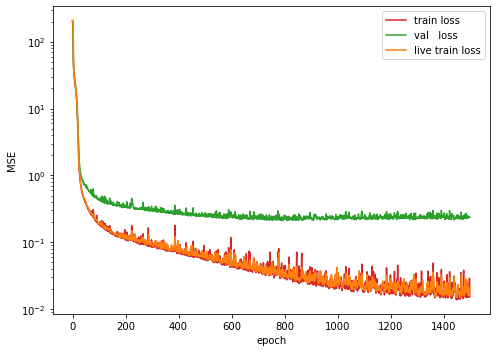

In [28]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

c1 = 'tab:red'
c2 = 'tab:green'
c3 = 'tab:orange'

axs.plot(trn_losses, label="train loss", color=c1)
axs.plot(val_losses, label="val   loss", color=c2)
axs.plot(trn_losses_live, label="live train loss", color=c3)

axs.set_yscale('log')

axs.set_xlabel("epoch")
axs.set_ylabel("MSE")

axs.legend(loc='best')

fig.tight_layout()


This is a good example of a network over-training.  At some point, the loss evaluated on the training data continues to improve, while the loss on the validation data converges to a lower limit.  In practice, it often happens that the validation loss actually gets worse when the network over-trains, so the problem can be worse than shown here.

## Network regularisation

### Dropout

Dropout is a mechanism to reduce over-fitting effects in neural network optimisation.  It was proposed in this paper (I think):

------------------

**Improving neural networks by preventing co-adaptation of feature detectors**

https://arxiv.org/abs/1207.0580

When a large feedforward neural network is trained on a small training set, it typically performs poorly on held-out test data. This "overfitting" is greatly reduced by randomly omitting half of the feature detectors on each training case. This prevents complex co-adaptations in which a feature detector is only helpful in the context of several other specific feature detectors. Instead, each neuron learns to detect a feature that is generally helpful for producing the correct answer given the combinatorially large variety of internal contexts in which it must operate. Random "dropout" gives big improvements on many benchmark tasks and sets new records for speech and object recognition. 

------------------

Dropout is implemented as a layer in pytorch.

The description given in the pytorch documentation is:

------------------

https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

During training, randomly zeroes some of the elements of the input tensor with probability $p$ using samples from a Bernoulli distribution. Each channel will be zeroed out independently on every forward call.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons as described in the paper Improving neural networks by preventing co-adaptation of feature detectors .

Furthermore, the outputs are scaled by a factor of $\frac{1}{1-p}$ during training. This means that during evaluation the module simply computes an identity function.

------------------

So let's build the same model, but with dropout:

In [29]:
class amp_net_dr(nn.Module):
    
    # default hdn_dim is 30, but can be changed upon initialisation
    def __init__(self, hdn_dim=30):
        
        super(amp_net_dr, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(ipt_dim, hdn_dim),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(hdn_dim, hdn_dim),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(hdn_dim, hdn_dim),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(hdn_dim, hdn_dim),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(hdn_dim, opt_dim),
        )

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out

When re-training the model we need to be careful.  When we evaluate the network on data to monitor performance, we don't want dropout to affect the results.  To do this we need to temporarily switch the model from `train` mode to `eval` mode.

In [30]:
# a useful function to present things clearer
def seperator():
    print( "-----------------------------------------------" )

# define parameters
ipt_dim = 20
opt_dim = 1
hdn_dim = 50
batch_size = 64

trn_dataset = amp_dataset(trn_datfp.to(device), trn_amplp.unsqueeze(-1).to(device))
val_dataset = amp_dataset(val_datfp.to(device), val_amplp.unsqueeze(-1).to(device))
tst_dataset = amp_dataset(tst_datfp.to(device), tst_amplp.unsqueeze(-1).to(device))

trn_dataloader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
tst_dataloader = DataLoader(tst_dataset, batch_size=batch_size, shuffle=True)
epochs = 1500

# re-initialise the model and the optimizer
hdn_dim = 50
model_dr = amp_net_dr(hdn_dim=hdn_dim).to(device)
learning_rate = 5e-4
optimizer = torch.optim.Adam(model_dr.parameters(), lr=learning_rate)
seperator()
print("model architecture")
seperator()
print(model_dr)
total_parameters = sum(p.numel() for p in model_dr.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

# track train and val losses
trn_losses_live_dr = []
trn_losses_dr = []
val_losses_dr = []

for t in range(epochs):
    seperator()
    print(f"Epoch {t+1}")
    seperator()
    trn_loss_live = train_epoch(trn_dataloader, model_dr, loss_fn, optimizer)
    trn_losses_live_dr.append(trn_loss_live)
    seperator()
    model_dr.eval()
    trn_loss = trn_pass(trn_dataloader, model_dr, loss_fn)
    trn_losses_dr.append(trn_loss)
    seperator()
    val_loss = val_pass(val_dataloader, model_dr, loss_fn)
    val_losses_dr.append(val_loss)
    model_dr.train()
    seperator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture
-----------------------------------------------
amp_net_dr(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=50, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=50, out_features=50, bias=True)
    (10): Dropout(p=0.5, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=1, bias=True)
  )
)
Model has 8751 trainable parameters
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 209.000443  [    0/ 1000]
avg train loss per batch in training: 213.992787
-----------------------------------------------
avg trn loss per batch: 212

avg val loss per batch: 17.394488
-----------------------------------------------
|
-----------------------------------------------
Epoch 20
-----------------------------------------------
current batch loss: 31.792543  [    0/ 1000]
avg train loss per batch in training: 35.684562
-----------------------------------------------
avg trn loss per batch: 17.562100
-----------------------------------------------
avg val loss per batch: 17.662065
-----------------------------------------------
|
-----------------------------------------------
Epoch 21
-----------------------------------------------
current batch loss: 30.899265  [    0/ 1000]
avg train loss per batch in training: 31.558309
-----------------------------------------------
avg trn loss per batch: 13.720727
-----------------------------------------------
avg val loss per batch: 13.988484
-----------------------------------------------
|
-----------------------------------------------
Epoch 22
-----------------------------------

avg val loss per batch: 4.261180
-----------------------------------------------
|
-----------------------------------------------
Epoch 40
-----------------------------------------------
current batch loss: 17.831154  [    0/ 1000]
avg train loss per batch in training: 18.418710
-----------------------------------------------
avg trn loss per batch: 3.967148
-----------------------------------------------
avg val loss per batch: 3.980464
-----------------------------------------------
|
-----------------------------------------------
Epoch 41
-----------------------------------------------
current batch loss: 15.423285  [    0/ 1000]
avg train loss per batch in training: 19.071350
-----------------------------------------------
avg trn loss per batch: 4.873137
-----------------------------------------------
avg val loss per batch: 4.887721
-----------------------------------------------
|
-----------------------------------------------
Epoch 42
----------------------------------------

avg val loss per batch: 2.461545
-----------------------------------------------
|
-----------------------------------------------
Epoch 60
-----------------------------------------------
current batch loss: 12.866863  [    0/ 1000]
avg train loss per batch in training: 14.295191
-----------------------------------------------
avg trn loss per batch: 2.325634
-----------------------------------------------
avg val loss per batch: 2.423669
-----------------------------------------------
|
-----------------------------------------------
Epoch 61
-----------------------------------------------
current batch loss: 14.586535  [    0/ 1000]
avg train loss per batch in training: 14.549507
-----------------------------------------------
avg trn loss per batch: 3.663612
-----------------------------------------------
avg val loss per batch: 3.812615
-----------------------------------------------
|
-----------------------------------------------
Epoch 62
----------------------------------------

avg val loss per batch: 1.546720
-----------------------------------------------
|
-----------------------------------------------
Epoch 80
-----------------------------------------------
current batch loss: 11.193313  [    0/ 1000]
avg train loss per batch in training: 11.732638
-----------------------------------------------
avg trn loss per batch: 1.511426
-----------------------------------------------
avg val loss per batch: 1.620665
-----------------------------------------------
|
-----------------------------------------------
Epoch 81
-----------------------------------------------
current batch loss: 8.767344  [    0/ 1000]
avg train loss per batch in training: 11.323817
-----------------------------------------------
avg trn loss per batch: 1.466842
-----------------------------------------------
avg val loss per batch: 1.567752
-----------------------------------------------
|
-----------------------------------------------
Epoch 82
-----------------------------------------

avg val loss per batch: 1.532087
-----------------------------------------------
|
-----------------------------------------------
Epoch 100
-----------------------------------------------
current batch loss: 9.752535  [    0/ 1000]
avg train loss per batch in training: 10.815687
-----------------------------------------------
avg trn loss per batch: 1.531273
-----------------------------------------------
avg val loss per batch: 1.639000
-----------------------------------------------
|
-----------------------------------------------
Epoch 101
-----------------------------------------------
current batch loss: 9.831873  [    0/ 1000]
avg train loss per batch in training: 10.241180
-----------------------------------------------
avg trn loss per batch: 1.296786
-----------------------------------------------
avg val loss per batch: 1.383042
-----------------------------------------------
|
-----------------------------------------------
Epoch 102
---------------------------------------

avg val loss per batch: 1.302571
-----------------------------------------------
|
-----------------------------------------------
Epoch 120
-----------------------------------------------
current batch loss: 11.720769  [    0/ 1000]
avg train loss per batch in training: 9.601674
-----------------------------------------------
avg trn loss per batch: 1.357333
-----------------------------------------------
avg val loss per batch: 1.470692
-----------------------------------------------
|
-----------------------------------------------
Epoch 121
-----------------------------------------------
current batch loss: 10.515251  [    0/ 1000]
avg train loss per batch in training: 9.848045
-----------------------------------------------
avg trn loss per batch: 1.266083
-----------------------------------------------
avg val loss per batch: 1.374662
-----------------------------------------------
|
-----------------------------------------------
Epoch 122
---------------------------------------

avg val loss per batch: 1.206034
-----------------------------------------------
|
-----------------------------------------------
Epoch 141
-----------------------------------------------
current batch loss: 9.423684  [    0/ 1000]
avg train loss per batch in training: 8.280481
-----------------------------------------------
avg trn loss per batch: 1.226698
-----------------------------------------------
avg val loss per batch: 1.329693
-----------------------------------------------
|
-----------------------------------------------
Epoch 142
-----------------------------------------------
current batch loss: 7.204494  [    0/ 1000]
avg train loss per batch in training: 9.145120
-----------------------------------------------
avg trn loss per batch: 1.334953
-----------------------------------------------
avg val loss per batch: 1.451394
-----------------------------------------------
|
-----------------------------------------------
Epoch 143
-----------------------------------------

avg val loss per batch: 0.946800
-----------------------------------------------
|
-----------------------------------------------
Epoch 162
-----------------------------------------------
current batch loss: 6.846202  [    0/ 1000]
avg train loss per batch in training: 8.817164
-----------------------------------------------
avg trn loss per batch: 1.252272
-----------------------------------------------
avg val loss per batch: 1.376868
-----------------------------------------------
|
-----------------------------------------------
Epoch 163
-----------------------------------------------
current batch loss: 8.130552  [    0/ 1000]
avg train loss per batch in training: 8.198132
-----------------------------------------------
avg trn loss per batch: 1.366576
-----------------------------------------------
avg val loss per batch: 1.476257
-----------------------------------------------
|
-----------------------------------------------
Epoch 164
-----------------------------------------

avg val loss per batch: 1.232165
-----------------------------------------------
|
-----------------------------------------------
Epoch 183
-----------------------------------------------
current batch loss: 5.590795  [    0/ 1000]
avg train loss per batch in training: 8.709616
-----------------------------------------------
avg trn loss per batch: 1.154944
-----------------------------------------------
avg val loss per batch: 1.252289
-----------------------------------------------
|
-----------------------------------------------
Epoch 184
-----------------------------------------------
current batch loss: 9.262102  [    0/ 1000]
avg train loss per batch in training: 8.368776
-----------------------------------------------
avg trn loss per batch: 1.319570
-----------------------------------------------
avg val loss per batch: 1.433622
-----------------------------------------------
|
-----------------------------------------------
Epoch 185
-----------------------------------------

avg val loss per batch: 0.895381
-----------------------------------------------
|
-----------------------------------------------
Epoch 204
-----------------------------------------------
current batch loss: 8.733505  [    0/ 1000]
avg train loss per batch in training: 8.368489
-----------------------------------------------
avg trn loss per batch: 1.233238
-----------------------------------------------
avg val loss per batch: 1.323742
-----------------------------------------------
|
-----------------------------------------------
Epoch 205
-----------------------------------------------
current batch loss: 6.939410  [    0/ 1000]
avg train loss per batch in training: 7.711230
-----------------------------------------------
avg trn loss per batch: 1.028876
-----------------------------------------------
avg val loss per batch: 1.112246
-----------------------------------------------
|
-----------------------------------------------
Epoch 206
-----------------------------------------

avg val loss per batch: 1.209873
-----------------------------------------------
|
-----------------------------------------------
Epoch 225
-----------------------------------------------
current batch loss: 6.459906  [    0/ 1000]
avg train loss per batch in training: 7.761903
-----------------------------------------------
avg trn loss per batch: 0.976607
-----------------------------------------------
avg val loss per batch: 1.049467
-----------------------------------------------
|
-----------------------------------------------
Epoch 226
-----------------------------------------------
current batch loss: 6.363456  [    0/ 1000]
avg train loss per batch in training: 7.310665
-----------------------------------------------
avg trn loss per batch: 0.937158
-----------------------------------------------
avg val loss per batch: 1.013781
-----------------------------------------------
|
-----------------------------------------------
Epoch 227
-----------------------------------------

avg val loss per batch: 0.907266
-----------------------------------------------
|
-----------------------------------------------
Epoch 246
-----------------------------------------------
current batch loss: 8.880892  [    0/ 1000]
avg train loss per batch in training: 7.352581
-----------------------------------------------
avg trn loss per batch: 0.964885
-----------------------------------------------
avg val loss per batch: 1.036686
-----------------------------------------------
|
-----------------------------------------------
Epoch 247
-----------------------------------------------
current batch loss: 5.837865  [    0/ 1000]
avg train loss per batch in training: 7.346849
-----------------------------------------------
avg trn loss per batch: 0.918786
-----------------------------------------------
avg val loss per batch: 0.985454
-----------------------------------------------
|
-----------------------------------------------
Epoch 248
-----------------------------------------

avg val loss per batch: 0.863545
-----------------------------------------------
|
-----------------------------------------------
Epoch 267
-----------------------------------------------
current batch loss: 5.560836  [    0/ 1000]
avg train loss per batch in training: 6.885537
-----------------------------------------------
avg trn loss per batch: 0.974482
-----------------------------------------------
avg val loss per batch: 1.043280
-----------------------------------------------
|
-----------------------------------------------
Epoch 268
-----------------------------------------------
current batch loss: 6.793053  [    0/ 1000]
avg train loss per batch in training: 7.185597
-----------------------------------------------
avg trn loss per batch: 1.028926
-----------------------------------------------
avg val loss per batch: 1.101750
-----------------------------------------------
|
-----------------------------------------------
Epoch 269
-----------------------------------------

avg val loss per batch: 0.818284
-----------------------------------------------
|
-----------------------------------------------
Epoch 288
-----------------------------------------------
current batch loss: 5.074807  [    0/ 1000]
avg train loss per batch in training: 6.770893
-----------------------------------------------
avg trn loss per batch: 0.902614
-----------------------------------------------
avg val loss per batch: 0.949844
-----------------------------------------------
|
-----------------------------------------------
Epoch 289
-----------------------------------------------
current batch loss: 5.188336  [    0/ 1000]
avg train loss per batch in training: 6.267419
-----------------------------------------------
avg trn loss per batch: 0.996733
-----------------------------------------------
avg val loss per batch: 1.049617
-----------------------------------------------
|
-----------------------------------------------
Epoch 290
-----------------------------------------

avg val loss per batch: 0.875871
-----------------------------------------------
|
-----------------------------------------------
Epoch 309
-----------------------------------------------
current batch loss: 4.741837  [    0/ 1000]
avg train loss per batch in training: 6.265307
-----------------------------------------------
avg trn loss per batch: 0.773416
-----------------------------------------------
avg val loss per batch: 0.827194
-----------------------------------------------
|
-----------------------------------------------
Epoch 310
-----------------------------------------------
current batch loss: 6.358337  [    0/ 1000]
avg train loss per batch in training: 6.346836
-----------------------------------------------
avg trn loss per batch: 0.685507
-----------------------------------------------
avg val loss per batch: 0.727940
-----------------------------------------------
|
-----------------------------------------------
Epoch 311
-----------------------------------------

avg val loss per batch: 0.789049
-----------------------------------------------
|
-----------------------------------------------
Epoch 330
-----------------------------------------------
current batch loss: 6.898437  [    0/ 1000]
avg train loss per batch in training: 6.111423
-----------------------------------------------
avg trn loss per batch: 0.875743
-----------------------------------------------
avg val loss per batch: 0.932691
-----------------------------------------------
|
-----------------------------------------------
Epoch 331
-----------------------------------------------
current batch loss: 4.753538  [    0/ 1000]
avg train loss per batch in training: 5.493664
-----------------------------------------------
avg trn loss per batch: 0.684993
-----------------------------------------------
avg val loss per batch: 0.729644
-----------------------------------------------
|
-----------------------------------------------
Epoch 332
-----------------------------------------

avg val loss per batch: 0.814375
-----------------------------------------------
|
-----------------------------------------------
Epoch 351
-----------------------------------------------
current batch loss: 6.483427  [    0/ 1000]
avg train loss per batch in training: 5.682452
-----------------------------------------------
avg trn loss per batch: 0.586735
-----------------------------------------------
avg val loss per batch: 0.607592
-----------------------------------------------
|
-----------------------------------------------
Epoch 352
-----------------------------------------------
current batch loss: 6.233427  [    0/ 1000]
avg train loss per batch in training: 5.668181
-----------------------------------------------
avg trn loss per batch: 0.803052
-----------------------------------------------
avg val loss per batch: 0.843937
-----------------------------------------------
|
-----------------------------------------------
Epoch 353
-----------------------------------------

avg val loss per batch: 0.752597
-----------------------------------------------
|
-----------------------------------------------
Epoch 372
-----------------------------------------------
current batch loss: 6.512459  [    0/ 1000]
avg train loss per batch in training: 5.406644
-----------------------------------------------
avg trn loss per batch: 0.604270
-----------------------------------------------
avg val loss per batch: 0.647345
-----------------------------------------------
|
-----------------------------------------------
Epoch 373
-----------------------------------------------
current batch loss: 4.566686  [    0/ 1000]
avg train loss per batch in training: 5.601929
-----------------------------------------------
avg trn loss per batch: 0.734816
-----------------------------------------------
avg val loss per batch: 0.781172
-----------------------------------------------
|
-----------------------------------------------
Epoch 374
-----------------------------------------

avg val loss per batch: 0.854378
-----------------------------------------------
|
-----------------------------------------------
Epoch 393
-----------------------------------------------
current batch loss: 5.082448  [    0/ 1000]
avg train loss per batch in training: 5.212723
-----------------------------------------------
avg trn loss per batch: 0.675079
-----------------------------------------------
avg val loss per batch: 0.717775
-----------------------------------------------
|
-----------------------------------------------
Epoch 394
-----------------------------------------------
current batch loss: 4.960745  [    0/ 1000]
avg train loss per batch in training: 5.266345
-----------------------------------------------
avg trn loss per batch: 0.735831
-----------------------------------------------
avg val loss per batch: 0.786058
-----------------------------------------------
|
-----------------------------------------------
Epoch 395
-----------------------------------------

avg val loss per batch: 0.480366
-----------------------------------------------
|
-----------------------------------------------
Epoch 414
-----------------------------------------------
current batch loss: 4.908317  [    0/ 1000]
avg train loss per batch in training: 5.423534
-----------------------------------------------
avg trn loss per batch: 0.790887
-----------------------------------------------
avg val loss per batch: 0.851999
-----------------------------------------------
|
-----------------------------------------------
Epoch 415
-----------------------------------------------
current batch loss: 5.727215  [    0/ 1000]
avg train loss per batch in training: 5.547023
-----------------------------------------------
avg trn loss per batch: 0.628291
-----------------------------------------------
avg val loss per batch: 0.673215
-----------------------------------------------
|
-----------------------------------------------
Epoch 416
-----------------------------------------

avg val loss per batch: 0.488782
-----------------------------------------------
|
-----------------------------------------------
Epoch 435
-----------------------------------------------
current batch loss: 4.413272  [    0/ 1000]
avg train loss per batch in training: 4.926647
-----------------------------------------------
avg trn loss per batch: 0.569736
-----------------------------------------------
avg val loss per batch: 0.606624
-----------------------------------------------
|
-----------------------------------------------
Epoch 436
-----------------------------------------------
current batch loss: 4.630381  [    0/ 1000]
avg train loss per batch in training: 4.557084
-----------------------------------------------
avg trn loss per batch: 0.580297
-----------------------------------------------
avg val loss per batch: 0.621955
-----------------------------------------------
|
-----------------------------------------------
Epoch 437
-----------------------------------------

avg val loss per batch: 0.590208
-----------------------------------------------
|
-----------------------------------------------
Epoch 456
-----------------------------------------------
current batch loss: 5.718687  [    0/ 1000]
avg train loss per batch in training: 5.183490
-----------------------------------------------
avg trn loss per batch: 0.531498
-----------------------------------------------
avg val loss per batch: 0.576057
-----------------------------------------------
|
-----------------------------------------------
Epoch 457
-----------------------------------------------
current batch loss: 4.589828  [    0/ 1000]
avg train loss per batch in training: 4.884890
-----------------------------------------------
avg trn loss per batch: 0.369210
-----------------------------------------------
avg val loss per batch: 0.398356
-----------------------------------------------
|
-----------------------------------------------
Epoch 458
-----------------------------------------

avg val loss per batch: 0.453233
-----------------------------------------------
|
-----------------------------------------------
Epoch 477
-----------------------------------------------
current batch loss: 4.196422  [    0/ 1000]
avg train loss per batch in training: 4.772956
-----------------------------------------------
avg trn loss per batch: 0.330815
-----------------------------------------------
avg val loss per batch: 0.371641
-----------------------------------------------
|
-----------------------------------------------
Epoch 478
-----------------------------------------------
current batch loss: 5.357956  [    0/ 1000]
avg train loss per batch in training: 4.387092
-----------------------------------------------
avg trn loss per batch: 0.445989
-----------------------------------------------
avg val loss per batch: 0.491504
-----------------------------------------------
|
-----------------------------------------------
Epoch 479
-----------------------------------------

avg val loss per batch: 0.528609
-----------------------------------------------
|
-----------------------------------------------
Epoch 498
-----------------------------------------------
current batch loss: 5.203076  [    0/ 1000]
avg train loss per batch in training: 4.742909
-----------------------------------------------
avg trn loss per batch: 0.576150
-----------------------------------------------
avg val loss per batch: 0.635475
-----------------------------------------------
|
-----------------------------------------------
Epoch 499
-----------------------------------------------
current batch loss: 3.766069  [    0/ 1000]
avg train loss per batch in training: 4.060262
-----------------------------------------------
avg trn loss per batch: 0.388072
-----------------------------------------------
avg val loss per batch: 0.436022
-----------------------------------------------
|
-----------------------------------------------
Epoch 500
-----------------------------------------

avg val loss per batch: 0.687353
-----------------------------------------------
|
-----------------------------------------------
Epoch 519
-----------------------------------------------
current batch loss: 4.709743  [    0/ 1000]
avg train loss per batch in training: 4.589301
-----------------------------------------------
avg trn loss per batch: 0.444421
-----------------------------------------------
avg val loss per batch: 0.488358
-----------------------------------------------
|
-----------------------------------------------
Epoch 520
-----------------------------------------------
current batch loss: 4.509191  [    0/ 1000]
avg train loss per batch in training: 4.119797
-----------------------------------------------
avg trn loss per batch: 0.486736
-----------------------------------------------
avg val loss per batch: 0.534505
-----------------------------------------------
|
-----------------------------------------------
Epoch 521
-----------------------------------------

avg val loss per batch: 0.595275
-----------------------------------------------
|
-----------------------------------------------
Epoch 540
-----------------------------------------------
current batch loss: 5.909943  [    0/ 1000]
avg train loss per batch in training: 4.600789
-----------------------------------------------
avg trn loss per batch: 0.304939
-----------------------------------------------
avg val loss per batch: 0.351832
-----------------------------------------------
|
-----------------------------------------------
Epoch 541
-----------------------------------------------
current batch loss: 5.066278  [    0/ 1000]
avg train loss per batch in training: 4.401275
-----------------------------------------------
avg trn loss per batch: 0.335477
-----------------------------------------------
avg val loss per batch: 0.380959
-----------------------------------------------
|
-----------------------------------------------
Epoch 542
-----------------------------------------

avg val loss per batch: 0.411062
-----------------------------------------------
|
-----------------------------------------------
Epoch 561
-----------------------------------------------
current batch loss: 4.533112  [    0/ 1000]
avg train loss per batch in training: 4.257039
-----------------------------------------------
avg trn loss per batch: 0.347284
-----------------------------------------------
avg val loss per batch: 0.391931
-----------------------------------------------
|
-----------------------------------------------
Epoch 562
-----------------------------------------------
current batch loss: 3.220689  [    0/ 1000]
avg train loss per batch in training: 4.681268
-----------------------------------------------
avg trn loss per batch: 0.429048
-----------------------------------------------
avg val loss per batch: 0.482062
-----------------------------------------------
|
-----------------------------------------------
Epoch 563
-----------------------------------------

avg val loss per batch: 0.440797
-----------------------------------------------
|
-----------------------------------------------
Epoch 582
-----------------------------------------------
current batch loss: 5.336685  [    0/ 1000]
avg train loss per batch in training: 4.375449
-----------------------------------------------
avg trn loss per batch: 0.395861
-----------------------------------------------
avg val loss per batch: 0.448265
-----------------------------------------------
|
-----------------------------------------------
Epoch 583
-----------------------------------------------
current batch loss: 4.537233  [    0/ 1000]
avg train loss per batch in training: 4.179530
-----------------------------------------------
avg trn loss per batch: 0.368510
-----------------------------------------------
avg val loss per batch: 0.417515
-----------------------------------------------
|
-----------------------------------------------
Epoch 584
-----------------------------------------

avg val loss per batch: 0.420302
-----------------------------------------------
|
-----------------------------------------------
Epoch 603
-----------------------------------------------
current batch loss: 4.030769  [    0/ 1000]
avg train loss per batch in training: 3.765037
-----------------------------------------------
avg trn loss per batch: 0.364664
-----------------------------------------------
avg val loss per batch: 0.419334
-----------------------------------------------
|
-----------------------------------------------
Epoch 604
-----------------------------------------------
current batch loss: 4.592351  [    0/ 1000]
avg train loss per batch in training: 4.144627
-----------------------------------------------
avg trn loss per batch: 0.410549
-----------------------------------------------
avg val loss per batch: 0.467537
-----------------------------------------------
|
-----------------------------------------------
Epoch 605
-----------------------------------------

avg val loss per batch: 0.476601
-----------------------------------------------
|
-----------------------------------------------
Epoch 624
-----------------------------------------------
current batch loss: 3.666242  [    0/ 1000]
avg train loss per batch in training: 3.959298
-----------------------------------------------
avg trn loss per batch: 0.311702
-----------------------------------------------
avg val loss per batch: 0.355720
-----------------------------------------------
|
-----------------------------------------------
Epoch 625
-----------------------------------------------
current batch loss: 4.255669  [    0/ 1000]
avg train loss per batch in training: 3.996350
-----------------------------------------------
avg trn loss per batch: 0.363906
-----------------------------------------------
avg val loss per batch: 0.416863
-----------------------------------------------
|
-----------------------------------------------
Epoch 626
-----------------------------------------

avg val loss per batch: 0.488881
-----------------------------------------------
|
-----------------------------------------------
Epoch 645
-----------------------------------------------
current batch loss: 4.967847  [    0/ 1000]
avg train loss per batch in training: 3.986285
-----------------------------------------------
avg trn loss per batch: 0.478471
-----------------------------------------------
avg val loss per batch: 0.538018
-----------------------------------------------
|
-----------------------------------------------
Epoch 646
-----------------------------------------------
current batch loss: 3.568016  [    0/ 1000]
avg train loss per batch in training: 3.831779
-----------------------------------------------
avg trn loss per batch: 0.363481
-----------------------------------------------
avg val loss per batch: 0.414920
-----------------------------------------------
|
-----------------------------------------------
Epoch 647
-----------------------------------------

avg val loss per batch: 0.334168
-----------------------------------------------
|
-----------------------------------------------
Epoch 666
-----------------------------------------------
current batch loss: 3.478460  [    0/ 1000]
avg train loss per batch in training: 4.045888
-----------------------------------------------
avg trn loss per batch: 0.328489
-----------------------------------------------
avg val loss per batch: 0.375017
-----------------------------------------------
|
-----------------------------------------------
Epoch 667
-----------------------------------------------
current batch loss: 4.163082  [    0/ 1000]
avg train loss per batch in training: 3.808573
-----------------------------------------------
avg trn loss per batch: 0.328009
-----------------------------------------------
avg val loss per batch: 0.377365
-----------------------------------------------
|
-----------------------------------------------
Epoch 668
-----------------------------------------

avg val loss per batch: 0.420686
-----------------------------------------------
|
-----------------------------------------------
Epoch 687
-----------------------------------------------
current batch loss: 3.755551  [    0/ 1000]
avg train loss per batch in training: 3.745522
-----------------------------------------------
avg trn loss per batch: 0.445546
-----------------------------------------------
avg val loss per batch: 0.505925
-----------------------------------------------
|
-----------------------------------------------
Epoch 688
-----------------------------------------------
current batch loss: 3.574211  [    0/ 1000]
avg train loss per batch in training: 3.789193
-----------------------------------------------
avg trn loss per batch: 0.402061
-----------------------------------------------
avg val loss per batch: 0.456241
-----------------------------------------------
|
-----------------------------------------------
Epoch 689
-----------------------------------------

avg val loss per batch: 0.327616
-----------------------------------------------
|
-----------------------------------------------
Epoch 708
-----------------------------------------------
current batch loss: 3.963921  [    0/ 1000]
avg train loss per batch in training: 3.809713
-----------------------------------------------
avg trn loss per batch: 0.376532
-----------------------------------------------
avg val loss per batch: 0.434363
-----------------------------------------------
|
-----------------------------------------------
Epoch 709
-----------------------------------------------
current batch loss: 4.857142  [    0/ 1000]
avg train loss per batch in training: 3.506813
-----------------------------------------------
avg trn loss per batch: 0.288417
-----------------------------------------------
avg val loss per batch: 0.335862
-----------------------------------------------
|
-----------------------------------------------
Epoch 710
-----------------------------------------

avg val loss per batch: 0.474929
-----------------------------------------------
|
-----------------------------------------------
Epoch 729
-----------------------------------------------
current batch loss: 3.932278  [    0/ 1000]
avg train loss per batch in training: 3.609549
-----------------------------------------------
avg trn loss per batch: 0.373625
-----------------------------------------------
avg val loss per batch: 0.425972
-----------------------------------------------
|
-----------------------------------------------
Epoch 730
-----------------------------------------------
current batch loss: 4.282456  [    0/ 1000]
avg train loss per batch in training: 3.738641
-----------------------------------------------
avg trn loss per batch: 0.259334
-----------------------------------------------
avg val loss per batch: 0.309214
-----------------------------------------------
|
-----------------------------------------------
Epoch 731
-----------------------------------------

avg val loss per batch: 0.411462
-----------------------------------------------
|
-----------------------------------------------
Epoch 750
-----------------------------------------------
current batch loss: 3.476874  [    0/ 1000]
avg train loss per batch in training: 3.697875
-----------------------------------------------
avg trn loss per batch: 0.324031
-----------------------------------------------
avg val loss per batch: 0.385287
-----------------------------------------------
|
-----------------------------------------------
Epoch 751
-----------------------------------------------
current batch loss: 5.263016  [    0/ 1000]
avg train loss per batch in training: 3.311845
-----------------------------------------------
avg trn loss per batch: 0.300815
-----------------------------------------------
avg val loss per batch: 0.356250
-----------------------------------------------
|
-----------------------------------------------
Epoch 752
-----------------------------------------

avg val loss per batch: 0.374501
-----------------------------------------------
|
-----------------------------------------------
Epoch 771
-----------------------------------------------
current batch loss: 3.247899  [    0/ 1000]
avg train loss per batch in training: 3.443652
-----------------------------------------------
avg trn loss per batch: 0.270930
-----------------------------------------------
avg val loss per batch: 0.327301
-----------------------------------------------
|
-----------------------------------------------
Epoch 772
-----------------------------------------------
current batch loss: 4.327672  [    0/ 1000]
avg train loss per batch in training: 3.354949
-----------------------------------------------
avg trn loss per batch: 0.369202
-----------------------------------------------
avg val loss per batch: 0.427590
-----------------------------------------------
|
-----------------------------------------------
Epoch 773
-----------------------------------------

avg val loss per batch: 0.291065
-----------------------------------------------
|
-----------------------------------------------
Epoch 792
-----------------------------------------------
current batch loss: 4.468655  [    0/ 1000]
avg train loss per batch in training: 3.577162
-----------------------------------------------
avg trn loss per batch: 0.366139
-----------------------------------------------
avg val loss per batch: 0.419010
-----------------------------------------------
|
-----------------------------------------------
Epoch 793
-----------------------------------------------
current batch loss: 4.120380  [    0/ 1000]
avg train loss per batch in training: 3.362755
-----------------------------------------------
avg trn loss per batch: 0.285691
-----------------------------------------------
avg val loss per batch: 0.338225
-----------------------------------------------
|
-----------------------------------------------
Epoch 794
-----------------------------------------

avg val loss per batch: 0.410293
-----------------------------------------------
|
-----------------------------------------------
Epoch 813
-----------------------------------------------
current batch loss: 3.956910  [    0/ 1000]
avg train loss per batch in training: 3.149468
-----------------------------------------------
avg trn loss per batch: 0.356280
-----------------------------------------------
avg val loss per batch: 0.418823
-----------------------------------------------
|
-----------------------------------------------
Epoch 814
-----------------------------------------------
current batch loss: 3.167334  [    0/ 1000]
avg train loss per batch in training: 3.134642
-----------------------------------------------
avg trn loss per batch: 0.279820
-----------------------------------------------
avg val loss per batch: 0.333074
-----------------------------------------------
|
-----------------------------------------------
Epoch 815
-----------------------------------------

avg val loss per batch: 0.467972
-----------------------------------------------
|
-----------------------------------------------
Epoch 834
-----------------------------------------------
current batch loss: 3.417392  [    0/ 1000]
avg train loss per batch in training: 3.416927
-----------------------------------------------
avg trn loss per batch: 0.381743
-----------------------------------------------
avg val loss per batch: 0.441039
-----------------------------------------------
|
-----------------------------------------------
Epoch 835
-----------------------------------------------
current batch loss: 3.568444  [    0/ 1000]
avg train loss per batch in training: 3.457946
-----------------------------------------------
avg trn loss per batch: 0.312755
-----------------------------------------------
avg val loss per batch: 0.368503
-----------------------------------------------
|
-----------------------------------------------
Epoch 836
-----------------------------------------

avg val loss per batch: 0.327929
-----------------------------------------------
|
-----------------------------------------------
Epoch 855
-----------------------------------------------
current batch loss: 3.158223  [    0/ 1000]
avg train loss per batch in training: 3.158833
-----------------------------------------------
avg trn loss per batch: 0.320521
-----------------------------------------------
avg val loss per batch: 0.382215
-----------------------------------------------
|
-----------------------------------------------
Epoch 856
-----------------------------------------------
current batch loss: 3.714636  [    0/ 1000]
avg train loss per batch in training: 3.113182
-----------------------------------------------
avg trn loss per batch: 0.336576
-----------------------------------------------
avg val loss per batch: 0.399349
-----------------------------------------------
|
-----------------------------------------------
Epoch 857
-----------------------------------------

avg val loss per batch: 0.340967
-----------------------------------------------
|
-----------------------------------------------
Epoch 876
-----------------------------------------------
current batch loss: 2.787178  [    0/ 1000]
avg train loss per batch in training: 3.159501
-----------------------------------------------
avg trn loss per batch: 0.439124
-----------------------------------------------
avg val loss per batch: 0.505665
-----------------------------------------------
|
-----------------------------------------------
Epoch 877
-----------------------------------------------
current batch loss: 3.865103  [    0/ 1000]
avg train loss per batch in training: 3.074030
-----------------------------------------------
avg trn loss per batch: 0.308197
-----------------------------------------------
avg val loss per batch: 0.366645
-----------------------------------------------
|
-----------------------------------------------
Epoch 878
-----------------------------------------

avg val loss per batch: 0.389267
-----------------------------------------------
|
-----------------------------------------------
Epoch 897
-----------------------------------------------
current batch loss: 2.842518  [    0/ 1000]
avg train loss per batch in training: 3.171934
-----------------------------------------------
avg trn loss per batch: 0.367390
-----------------------------------------------
avg val loss per batch: 0.425082
-----------------------------------------------
|
-----------------------------------------------
Epoch 898
-----------------------------------------------
current batch loss: 1.754843  [    0/ 1000]
avg train loss per batch in training: 2.859559
-----------------------------------------------
avg trn loss per batch: 0.308282
-----------------------------------------------
avg val loss per batch: 0.365172
-----------------------------------------------
|
-----------------------------------------------
Epoch 899
-----------------------------------------

avg val loss per batch: 0.398775
-----------------------------------------------
|
-----------------------------------------------
Epoch 918
-----------------------------------------------
current batch loss: 3.287611  [    0/ 1000]
avg train loss per batch in training: 2.791962
-----------------------------------------------
avg trn loss per batch: 0.375307
-----------------------------------------------
avg val loss per batch: 0.436113
-----------------------------------------------
|
-----------------------------------------------
Epoch 919
-----------------------------------------------
current batch loss: 2.903673  [    0/ 1000]
avg train loss per batch in training: 2.919137
-----------------------------------------------
avg trn loss per batch: 0.312502
-----------------------------------------------
avg val loss per batch: 0.368812
-----------------------------------------------
|
-----------------------------------------------
Epoch 920
-----------------------------------------

avg val loss per batch: 0.325751
-----------------------------------------------
|
-----------------------------------------------
Epoch 939
-----------------------------------------------
current batch loss: 3.423846  [    0/ 1000]
avg train loss per batch in training: 3.046103
-----------------------------------------------
avg trn loss per batch: 0.379427
-----------------------------------------------
avg val loss per batch: 0.446522
-----------------------------------------------
|
-----------------------------------------------
Epoch 940
-----------------------------------------------
current batch loss: 2.206631  [    0/ 1000]
avg train loss per batch in training: 2.958086
-----------------------------------------------
avg trn loss per batch: 0.258738
-----------------------------------------------
avg val loss per batch: 0.318277
-----------------------------------------------
|
-----------------------------------------------
Epoch 941
-----------------------------------------

avg val loss per batch: 0.333565
-----------------------------------------------
|
-----------------------------------------------
Epoch 960
-----------------------------------------------
current batch loss: 2.601667  [    0/ 1000]
avg train loss per batch in training: 2.826103
-----------------------------------------------
avg trn loss per batch: 0.251094
-----------------------------------------------
avg val loss per batch: 0.310322
-----------------------------------------------
|
-----------------------------------------------
Epoch 961
-----------------------------------------------
current batch loss: 2.791793  [    0/ 1000]
avg train loss per batch in training: 2.567326
-----------------------------------------------
avg trn loss per batch: 0.208988
-----------------------------------------------
avg val loss per batch: 0.265603
-----------------------------------------------
|
-----------------------------------------------
Epoch 962
-----------------------------------------

avg val loss per batch: 0.312747
-----------------------------------------------
|
-----------------------------------------------
Epoch 981
-----------------------------------------------
current batch loss: 3.591931  [    0/ 1000]
avg train loss per batch in training: 2.948402
-----------------------------------------------
avg trn loss per batch: 0.376275
-----------------------------------------------
avg val loss per batch: 0.441413
-----------------------------------------------
|
-----------------------------------------------
Epoch 982
-----------------------------------------------
current batch loss: 2.563246  [    0/ 1000]
avg train loss per batch in training: 2.714254
-----------------------------------------------
avg trn loss per batch: 0.219059
-----------------------------------------------
avg val loss per batch: 0.276693
-----------------------------------------------
|
-----------------------------------------------
Epoch 983
-----------------------------------------

avg val loss per batch: 0.334263
-----------------------------------------------
|
-----------------------------------------------
Epoch 1002
-----------------------------------------------
current batch loss: 2.815535  [    0/ 1000]
avg train loss per batch in training: 2.600935
-----------------------------------------------
avg trn loss per batch: 0.351532
-----------------------------------------------
avg val loss per batch: 0.417357
-----------------------------------------------
|
-----------------------------------------------
Epoch 1003
-----------------------------------------------
current batch loss: 3.679952  [    0/ 1000]
avg train loss per batch in training: 2.844851
-----------------------------------------------
avg trn loss per batch: 0.312226
-----------------------------------------------
avg val loss per batch: 0.371126
-----------------------------------------------
|
-----------------------------------------------
Epoch 1004
--------------------------------------

avg val loss per batch: 0.385432
-----------------------------------------------
|
-----------------------------------------------
Epoch 1022
-----------------------------------------------
current batch loss: 1.871794  [    0/ 1000]
avg train loss per batch in training: 2.594840
-----------------------------------------------
avg trn loss per batch: 0.280207
-----------------------------------------------
avg val loss per batch: 0.337205
-----------------------------------------------
|
-----------------------------------------------
Epoch 1023
-----------------------------------------------
current batch loss: 3.394582  [    0/ 1000]
avg train loss per batch in training: 2.797937
-----------------------------------------------
avg trn loss per batch: 0.278322
-----------------------------------------------
avg val loss per batch: 0.336909
-----------------------------------------------
|
-----------------------------------------------
Epoch 1024
--------------------------------------

avg val loss per batch: 0.316757
-----------------------------------------------
|
-----------------------------------------------
Epoch 1042
-----------------------------------------------
current batch loss: 2.366352  [    0/ 1000]
avg train loss per batch in training: 2.549277
-----------------------------------------------
avg trn loss per batch: 0.313119
-----------------------------------------------
avg val loss per batch: 0.372395
-----------------------------------------------
|
-----------------------------------------------
Epoch 1043
-----------------------------------------------
current batch loss: 2.525693  [    0/ 1000]
avg train loss per batch in training: 2.788005
-----------------------------------------------
avg trn loss per batch: 0.283023
-----------------------------------------------
avg val loss per batch: 0.340882
-----------------------------------------------
|
-----------------------------------------------
Epoch 1044
--------------------------------------

avg val loss per batch: 0.405491
-----------------------------------------------
|
-----------------------------------------------
Epoch 1062
-----------------------------------------------
current batch loss: 2.656916  [    0/ 1000]
avg train loss per batch in training: 2.482324
-----------------------------------------------
avg trn loss per batch: 0.319225
-----------------------------------------------
avg val loss per batch: 0.378285
-----------------------------------------------
|
-----------------------------------------------
Epoch 1063
-----------------------------------------------
current batch loss: 2.426092  [    0/ 1000]
avg train loss per batch in training: 2.562953
-----------------------------------------------
avg trn loss per batch: 0.320751
-----------------------------------------------
avg val loss per batch: 0.383912
-----------------------------------------------
|
-----------------------------------------------
Epoch 1064
--------------------------------------

avg val loss per batch: 0.329724
-----------------------------------------------
|
-----------------------------------------------
Epoch 1082
-----------------------------------------------
current batch loss: 3.384029  [    0/ 1000]
avg train loss per batch in training: 2.566469
-----------------------------------------------
avg trn loss per batch: 0.310640
-----------------------------------------------
avg val loss per batch: 0.381050
-----------------------------------------------
|
-----------------------------------------------
Epoch 1083
-----------------------------------------------
current batch loss: 1.884124  [    0/ 1000]
avg train loss per batch in training: 2.650403
-----------------------------------------------
avg trn loss per batch: 0.371270
-----------------------------------------------
avg val loss per batch: 0.438179
-----------------------------------------------
|
-----------------------------------------------
Epoch 1084
--------------------------------------

avg val loss per batch: 0.345979
-----------------------------------------------
|
-----------------------------------------------
Epoch 1102
-----------------------------------------------
current batch loss: 1.811126  [    0/ 1000]
avg train loss per batch in training: 2.435737
-----------------------------------------------
avg trn loss per batch: 0.300291
-----------------------------------------------
avg val loss per batch: 0.354115
-----------------------------------------------
|
-----------------------------------------------
Epoch 1103
-----------------------------------------------
current batch loss: 2.304313  [    0/ 1000]
avg train loss per batch in training: 2.547238
-----------------------------------------------
avg trn loss per batch: 0.200978
-----------------------------------------------
avg val loss per batch: 0.246109
-----------------------------------------------
|
-----------------------------------------------
Epoch 1104
--------------------------------------

avg val loss per batch: 0.333905
-----------------------------------------------
|
-----------------------------------------------
Epoch 1122
-----------------------------------------------
current batch loss: 1.931860  [    0/ 1000]
avg train loss per batch in training: 2.612596
-----------------------------------------------
avg trn loss per batch: 0.307699
-----------------------------------------------
avg val loss per batch: 0.369609
-----------------------------------------------
|
-----------------------------------------------
Epoch 1123
-----------------------------------------------
current batch loss: 2.336800  [    0/ 1000]
avg train loss per batch in training: 2.575278
-----------------------------------------------
avg trn loss per batch: 0.273101
-----------------------------------------------
avg val loss per batch: 0.327506
-----------------------------------------------
|
-----------------------------------------------
Epoch 1124
--------------------------------------

avg val loss per batch: 0.310255
-----------------------------------------------
|
-----------------------------------------------
Epoch 1142
-----------------------------------------------
current batch loss: 2.339890  [    0/ 1000]
avg train loss per batch in training: 2.267784
-----------------------------------------------
avg trn loss per batch: 0.311001
-----------------------------------------------
avg val loss per batch: 0.375467
-----------------------------------------------
|
-----------------------------------------------
Epoch 1143
-----------------------------------------------
current batch loss: 2.152489  [    0/ 1000]
avg train loss per batch in training: 2.323219
-----------------------------------------------
avg trn loss per batch: 0.277514
-----------------------------------------------
avg val loss per batch: 0.341720
-----------------------------------------------
|
-----------------------------------------------
Epoch 1144
--------------------------------------

avg val loss per batch: 0.341401
-----------------------------------------------
|
-----------------------------------------------
Epoch 1162
-----------------------------------------------
current batch loss: 1.745703  [    0/ 1000]
avg train loss per batch in training: 2.366488
-----------------------------------------------
avg trn loss per batch: 0.268338
-----------------------------------------------
avg val loss per batch: 0.327694
-----------------------------------------------
|
-----------------------------------------------
Epoch 1163
-----------------------------------------------
current batch loss: 1.560485  [    0/ 1000]
avg train loss per batch in training: 2.173555
-----------------------------------------------
avg trn loss per batch: 0.240131
-----------------------------------------------
avg val loss per batch: 0.296462
-----------------------------------------------
|
-----------------------------------------------
Epoch 1164
--------------------------------------

avg val loss per batch: 0.314689
-----------------------------------------------
|
-----------------------------------------------
Epoch 1182
-----------------------------------------------
current batch loss: 2.375737  [    0/ 1000]
avg train loss per batch in training: 2.062174
-----------------------------------------------
avg trn loss per batch: 0.258565
-----------------------------------------------
avg val loss per batch: 0.311470
-----------------------------------------------
|
-----------------------------------------------
Epoch 1183
-----------------------------------------------
current batch loss: 3.056384  [    0/ 1000]
avg train loss per batch in training: 2.312251
-----------------------------------------------
avg trn loss per batch: 0.279442
-----------------------------------------------
avg val loss per batch: 0.338625
-----------------------------------------------
|
-----------------------------------------------
Epoch 1184
--------------------------------------

avg val loss per batch: 0.275402
-----------------------------------------------
|
-----------------------------------------------
Epoch 1202
-----------------------------------------------
current batch loss: 1.557487  [    0/ 1000]
avg train loss per batch in training: 2.096221
-----------------------------------------------
avg trn loss per batch: 0.258713
-----------------------------------------------
avg val loss per batch: 0.316180
-----------------------------------------------
|
-----------------------------------------------
Epoch 1203
-----------------------------------------------
current batch loss: 2.131627  [    0/ 1000]
avg train loss per batch in training: 2.122537
-----------------------------------------------
avg trn loss per batch: 0.325430
-----------------------------------------------
avg val loss per batch: 0.389493
-----------------------------------------------
|
-----------------------------------------------
Epoch 1204
--------------------------------------

avg val loss per batch: 0.271314
-----------------------------------------------
|
-----------------------------------------------
Epoch 1222
-----------------------------------------------
current batch loss: 1.652396  [    0/ 1000]
avg train loss per batch in training: 2.166249
-----------------------------------------------
avg trn loss per batch: 0.248975
-----------------------------------------------
avg val loss per batch: 0.303842
-----------------------------------------------
|
-----------------------------------------------
Epoch 1223
-----------------------------------------------
current batch loss: 1.811845  [    0/ 1000]
avg train loss per batch in training: 2.174136
-----------------------------------------------
avg trn loss per batch: 0.278086
-----------------------------------------------
avg val loss per batch: 0.335139
-----------------------------------------------
|
-----------------------------------------------
Epoch 1224
--------------------------------------

avg val loss per batch: 0.345640
-----------------------------------------------
|
-----------------------------------------------
Epoch 1242
-----------------------------------------------
current batch loss: 2.820855  [    0/ 1000]
avg train loss per batch in training: 2.078434
-----------------------------------------------
avg trn loss per batch: 0.347600
-----------------------------------------------
avg val loss per batch: 0.397266
-----------------------------------------------
|
-----------------------------------------------
Epoch 1243
-----------------------------------------------
current batch loss: 2.136760  [    0/ 1000]
avg train loss per batch in training: 2.086726
-----------------------------------------------
avg trn loss per batch: 0.294019
-----------------------------------------------
avg val loss per batch: 0.344963
-----------------------------------------------
|
-----------------------------------------------
Epoch 1244
--------------------------------------

avg val loss per batch: 0.386833
-----------------------------------------------
|
-----------------------------------------------
Epoch 1262
-----------------------------------------------
current batch loss: 2.099151  [    0/ 1000]
avg train loss per batch in training: 2.056993
-----------------------------------------------
avg trn loss per batch: 0.257853
-----------------------------------------------
avg val loss per batch: 0.312930
-----------------------------------------------
|
-----------------------------------------------
Epoch 1263
-----------------------------------------------
current batch loss: 2.197811  [    0/ 1000]
avg train loss per batch in training: 2.154823
-----------------------------------------------
avg trn loss per batch: 0.237285
-----------------------------------------------
avg val loss per batch: 0.291305
-----------------------------------------------
|
-----------------------------------------------
Epoch 1264
--------------------------------------

avg val loss per batch: 0.302070
-----------------------------------------------
|
-----------------------------------------------
Epoch 1282
-----------------------------------------------
current batch loss: 1.468953  [    0/ 1000]
avg train loss per batch in training: 1.759766
-----------------------------------------------
avg trn loss per batch: 0.255746
-----------------------------------------------
avg val loss per batch: 0.323088
-----------------------------------------------
|
-----------------------------------------------
Epoch 1283
-----------------------------------------------
current batch loss: 1.757180  [    0/ 1000]
avg train loss per batch in training: 1.981039
-----------------------------------------------
avg trn loss per batch: 0.269010
-----------------------------------------------
avg val loss per batch: 0.336985
-----------------------------------------------
|
-----------------------------------------------
Epoch 1284
--------------------------------------

avg val loss per batch: 0.341906
-----------------------------------------------
|
-----------------------------------------------
Epoch 1302
-----------------------------------------------
current batch loss: 1.748253  [    0/ 1000]
avg train loss per batch in training: 1.939752
-----------------------------------------------
avg trn loss per batch: 0.293283
-----------------------------------------------
avg val loss per batch: 0.361706
-----------------------------------------------
|
-----------------------------------------------
Epoch 1303
-----------------------------------------------
current batch loss: 1.832219  [    0/ 1000]
avg train loss per batch in training: 2.057326
-----------------------------------------------
avg trn loss per batch: 0.247973
-----------------------------------------------
avg val loss per batch: 0.314737
-----------------------------------------------
|
-----------------------------------------------
Epoch 1304
--------------------------------------

avg val loss per batch: 0.325604
-----------------------------------------------
|
-----------------------------------------------
Epoch 1322
-----------------------------------------------
current batch loss: 1.885120  [    0/ 1000]
avg train loss per batch in training: 1.854944
-----------------------------------------------
avg trn loss per batch: 0.238723
-----------------------------------------------
avg val loss per batch: 0.306117
-----------------------------------------------
|
-----------------------------------------------
Epoch 1323
-----------------------------------------------
current batch loss: 2.269203  [    0/ 1000]
avg train loss per batch in training: 1.926572
-----------------------------------------------
avg trn loss per batch: 0.251456
-----------------------------------------------
avg val loss per batch: 0.316436
-----------------------------------------------
|
-----------------------------------------------
Epoch 1324
--------------------------------------

avg val loss per batch: 0.321478
-----------------------------------------------
|
-----------------------------------------------
Epoch 1342
-----------------------------------------------
current batch loss: 1.841248  [    0/ 1000]
avg train loss per batch in training: 1.850465
-----------------------------------------------
avg trn loss per batch: 0.268675
-----------------------------------------------
avg val loss per batch: 0.323309
-----------------------------------------------
|
-----------------------------------------------
Epoch 1343
-----------------------------------------------
current batch loss: 1.427688  [    0/ 1000]
avg train loss per batch in training: 1.669866
-----------------------------------------------
avg trn loss per batch: 0.235282
-----------------------------------------------
avg val loss per batch: 0.286538
-----------------------------------------------
|
-----------------------------------------------
Epoch 1344
--------------------------------------

avg val loss per batch: 0.312340
-----------------------------------------------
|
-----------------------------------------------
Epoch 1362
-----------------------------------------------
current batch loss: 1.820643  [    0/ 1000]
avg train loss per batch in training: 1.821373
-----------------------------------------------
avg trn loss per batch: 0.259553
-----------------------------------------------
avg val loss per batch: 0.313993
-----------------------------------------------
|
-----------------------------------------------
Epoch 1363
-----------------------------------------------
current batch loss: 1.261076  [    0/ 1000]
avg train loss per batch in training: 1.772338
-----------------------------------------------
avg trn loss per batch: 0.203523
-----------------------------------------------
avg val loss per batch: 0.253962
-----------------------------------------------
|
-----------------------------------------------
Epoch 1364
--------------------------------------

avg val loss per batch: 0.324843
-----------------------------------------------
|
-----------------------------------------------
Epoch 1382
-----------------------------------------------
current batch loss: 1.700215  [    0/ 1000]
avg train loss per batch in training: 1.718802
-----------------------------------------------
avg trn loss per batch: 0.287507
-----------------------------------------------
avg val loss per batch: 0.347593
-----------------------------------------------
|
-----------------------------------------------
Epoch 1383
-----------------------------------------------
current batch loss: 1.378346  [    0/ 1000]
avg train loss per batch in training: 1.695207
-----------------------------------------------
avg trn loss per batch: 0.245020
-----------------------------------------------
avg val loss per batch: 0.301032
-----------------------------------------------
|
-----------------------------------------------
Epoch 1384
--------------------------------------

avg val loss per batch: 0.305984
-----------------------------------------------
|
-----------------------------------------------
Epoch 1402
-----------------------------------------------
current batch loss: 1.768746  [    0/ 1000]
avg train loss per batch in training: 1.589872
-----------------------------------------------
avg trn loss per batch: 0.257852
-----------------------------------------------
avg val loss per batch: 0.312381
-----------------------------------------------
|
-----------------------------------------------
Epoch 1403
-----------------------------------------------
current batch loss: 1.997549  [    0/ 1000]
avg train loss per batch in training: 1.755470
-----------------------------------------------
avg trn loss per batch: 0.215832
-----------------------------------------------
avg val loss per batch: 0.269300
-----------------------------------------------
|
-----------------------------------------------
Epoch 1404
--------------------------------------

avg val loss per batch: 0.299110
-----------------------------------------------
|
-----------------------------------------------
Epoch 1422
-----------------------------------------------
current batch loss: 1.483132  [    0/ 1000]
avg train loss per batch in training: 1.652835
-----------------------------------------------
avg trn loss per batch: 0.265105
-----------------------------------------------
avg val loss per batch: 0.325244
-----------------------------------------------
|
-----------------------------------------------
Epoch 1423
-----------------------------------------------
current batch loss: 1.538941  [    0/ 1000]
avg train loss per batch in training: 1.695446
-----------------------------------------------
avg trn loss per batch: 0.236812
-----------------------------------------------
avg val loss per batch: 0.296242
-----------------------------------------------
|
-----------------------------------------------
Epoch 1424
--------------------------------------

avg val loss per batch: 0.248429
-----------------------------------------------
|
-----------------------------------------------
Epoch 1442
-----------------------------------------------
current batch loss: 2.265154  [    0/ 1000]
avg train loss per batch in training: 1.708386
-----------------------------------------------
avg trn loss per batch: 0.194949
-----------------------------------------------
avg val loss per batch: 0.241809
-----------------------------------------------
|
-----------------------------------------------
Epoch 1443
-----------------------------------------------
current batch loss: 1.392290  [    0/ 1000]
avg train loss per batch in training: 1.583942
-----------------------------------------------
avg trn loss per batch: 0.236547
-----------------------------------------------
avg val loss per batch: 0.291624
-----------------------------------------------
|
-----------------------------------------------
Epoch 1444
--------------------------------------

avg val loss per batch: 0.338021
-----------------------------------------------
|
-----------------------------------------------
Epoch 1462
-----------------------------------------------
current batch loss: 1.947631  [    0/ 1000]
avg train loss per batch in training: 1.695283
-----------------------------------------------
avg trn loss per batch: 0.241408
-----------------------------------------------
avg val loss per batch: 0.302823
-----------------------------------------------
|
-----------------------------------------------
Epoch 1463
-----------------------------------------------
current batch loss: 1.671153  [    0/ 1000]
avg train loss per batch in training: 1.555982
-----------------------------------------------
avg trn loss per batch: 0.223808
-----------------------------------------------
avg val loss per batch: 0.273374
-----------------------------------------------
|
-----------------------------------------------
Epoch 1464
--------------------------------------

avg val loss per batch: 0.260068
-----------------------------------------------
|
-----------------------------------------------
Epoch 1482
-----------------------------------------------
current batch loss: 1.626831  [    0/ 1000]
avg train loss per batch in training: 1.500422
-----------------------------------------------
avg trn loss per batch: 0.222978
-----------------------------------------------
avg val loss per batch: 0.279544
-----------------------------------------------
|
-----------------------------------------------
Epoch 1483
-----------------------------------------------
current batch loss: 1.869237  [    0/ 1000]
avg train loss per batch in training: 1.551652
-----------------------------------------------
avg trn loss per batch: 0.278416
-----------------------------------------------
avg val loss per batch: 0.340276
-----------------------------------------------
|
-----------------------------------------------
Epoch 1484
--------------------------------------

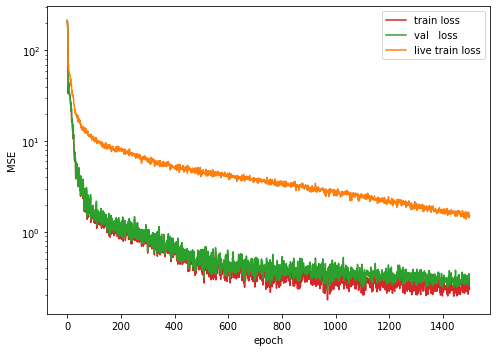

In [31]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

c1 = 'tab:red'
c2 = 'tab:green'
c3 = 'tab:orange'

axs.plot(trn_losses_dr, label="train loss", color=c1)
axs.plot(val_losses_dr, label="val   loss", color=c2)
axs.plot(trn_losses_live_dr, label="live train loss", color=c3)

axs.set_yscale('log')

axs.set_xlabel("epoch")
axs.set_ylabel("MSE")

axs.legend(loc='best')

fig.tight_layout()

Clearly, we can see that dropout has completely prevented over-training! We also see that the 'live' loss is higher do to the dropout used in training. 

### L2 regularisation

Similar to dropout L2 regularisation is a method which can be used to reduce overfitting.

It simply works by adding a term of the form: ~$\lambda|\omega|^2 $
to the loss function. In our case we get:

$$L = MSE + \lambda|\omega|^2$$

where $\lambda$ is an additional hyperparameter.

One possible interpretation of L2-regularisation is having a normal prior over weight space where $\lambda$ is related to the width of the prior and the central value is set to 0. This normal prior resctricts the model complexity by punishing models with a weight configuration far away from its central value of 0.

-----------------------------------




Let's just copy paste everything from before...

In [32]:
# a useful function to present things clearer
def seperator():
    print( "-----------------------------------------------" )

# define parameters
ipt_dim = 20
opt_dim = 1
hdn_dim = 50
batch_size = 64

trn_dataset = amp_dataset(trn_datfp.to(device), trn_amplp.unsqueeze(-1).to(device))
val_dataset = amp_dataset(val_datfp.to(device), val_amplp.unsqueeze(-1).to(device))
tst_dataset = amp_dataset(tst_datfp.to(device), tst_amplp.unsqueeze(-1).to(device))

trn_dataloader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
tst_dataloader = DataLoader(tst_dataset, batch_size=batch_size, shuffle=True)
epochs = 1500

# re-initialise the model and the optimizer
hdn_dim = 50
model = amp_net(hdn_dim=hdn_dim).to(device) # model without Dropout!
learning_rate = 5e-4

In pytorch L2 regularisation can be added via the argument 'weight_decay' of the optimizer.

In [33]:
weight_decay = 1e-1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

As a side note:

An alternative explicit implementation would be:

```
weight_decay = 1e-2
l2_norm = sum(torch.linalg.norm(p, 2) for p in model.parameters())

loss = loss + weight_decay * l2_norm
```

In [34]:
seperator()
print("model architecture")
seperator()
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")


# track train and val losses
trn_losses_live_l2 = []
trn_losses_l2 = []
val_losses_l2 = []

for t in range(epochs):
    seperator()
    print(f"Epoch {t+1}")
    seperator()
    trn_loss_live = train_epoch(trn_dataloader, model, loss_fn, optimizer)
    trn_losses_live_l2.append(trn_loss_live)
    seperator()
    trn_loss = trn_pass(trn_dataloader, model, loss_fn)
    trn_losses_l2.append(trn_loss)
    seperator()
    val_loss = val_pass(val_dataloader, model, loss_fn)
    val_losses_l2.append(val_loss)
    seperator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture
-----------------------------------------------
amp_net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)
Model has 8751 trainable parameters
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 215.510025  [    0/ 1000]
avg train loss per batch in training: 213.827185
-----------------------------------------------
avg trn loss per batch: 210.149334
-----------------------------------------------
avg val loss per batch: 211.982016
-----------------------------------------------
|
---------------------

avg val loss per batch: 5.378506
-----------------------------------------------
|
-----------------------------------------------
Epoch 20
-----------------------------------------------
current batch loss: 5.309978  [    0/ 1000]
avg train loss per batch in training: 4.025351
-----------------------------------------------
avg trn loss per batch: 3.247159
-----------------------------------------------
avg val loss per batch: 3.780132
-----------------------------------------------
|
-----------------------------------------------
Epoch 21
-----------------------------------------------
current batch loss: 2.548410  [    0/ 1000]
avg train loss per batch in training: 2.385393
-----------------------------------------------
avg trn loss per batch: 1.648482
-----------------------------------------------
avg val loss per batch: 2.024832
-----------------------------------------------
|
-----------------------------------------------
Epoch 22
--------------------------------------------

avg val loss per batch: 0.462446
-----------------------------------------------
|
-----------------------------------------------
Epoch 41
-----------------------------------------------
current batch loss: 0.305370  [    0/ 1000]
avg train loss per batch in training: 0.359075
-----------------------------------------------
avg trn loss per batch: 0.342321
-----------------------------------------------
avg val loss per batch: 0.470621
-----------------------------------------------
|
-----------------------------------------------
Epoch 42
-----------------------------------------------
current batch loss: 0.332326  [    0/ 1000]
avg train loss per batch in training: 0.356364
-----------------------------------------------
avg trn loss per batch: 0.327203
-----------------------------------------------
avg val loss per batch: 0.447324
-----------------------------------------------
|
-----------------------------------------------
Epoch 43
--------------------------------------------

avg val loss per batch: 0.407339
-----------------------------------------------
|
-----------------------------------------------
Epoch 62
-----------------------------------------------
current batch loss: 0.311989  [    0/ 1000]
avg train loss per batch in training: 0.286635
-----------------------------------------------
avg trn loss per batch: 0.292257
-----------------------------------------------
avg val loss per batch: 0.402546
-----------------------------------------------
|
-----------------------------------------------
Epoch 63
-----------------------------------------------
current batch loss: 0.214071  [    0/ 1000]
avg train loss per batch in training: 0.293245
-----------------------------------------------
avg trn loss per batch: 0.279937
-----------------------------------------------
avg val loss per batch: 0.396050
-----------------------------------------------
|
-----------------------------------------------
Epoch 64
--------------------------------------------

avg val loss per batch: 0.376173
-----------------------------------------------
|
-----------------------------------------------
Epoch 83
-----------------------------------------------
current batch loss: 0.349528  [    0/ 1000]
avg train loss per batch in training: 0.269079
-----------------------------------------------
avg trn loss per batch: 0.271435
-----------------------------------------------
avg val loss per batch: 0.402099
-----------------------------------------------
|
-----------------------------------------------
Epoch 84
-----------------------------------------------
current batch loss: 0.321051  [    0/ 1000]
avg train loss per batch in training: 0.271765
-----------------------------------------------
avg trn loss per batch: 0.267969
-----------------------------------------------
avg val loss per batch: 0.377597
-----------------------------------------------
|
-----------------------------------------------
Epoch 85
--------------------------------------------

avg val loss per batch: 0.372693
-----------------------------------------------
|
-----------------------------------------------
Epoch 104
-----------------------------------------------
current batch loss: 0.190364  [    0/ 1000]
avg train loss per batch in training: 0.256134
-----------------------------------------------
avg trn loss per batch: 0.262991
-----------------------------------------------
avg val loss per batch: 0.368258
-----------------------------------------------
|
-----------------------------------------------
Epoch 105
-----------------------------------------------
current batch loss: 0.245096  [    0/ 1000]
avg train loss per batch in training: 0.256076
-----------------------------------------------
avg trn loss per batch: 0.252139
-----------------------------------------------
avg val loss per batch: 0.378520
-----------------------------------------------
|
-----------------------------------------------
Epoch 106
-----------------------------------------

avg val loss per batch: 0.351050
-----------------------------------------------
|
-----------------------------------------------
Epoch 125
-----------------------------------------------
current batch loss: 0.227989  [    0/ 1000]
avg train loss per batch in training: 0.254712
-----------------------------------------------
avg trn loss per batch: 0.250040
-----------------------------------------------
avg val loss per batch: 0.355837
-----------------------------------------------
|
-----------------------------------------------
Epoch 126
-----------------------------------------------
current batch loss: 0.175461  [    0/ 1000]
avg train loss per batch in training: 0.275710
-----------------------------------------------
avg trn loss per batch: 0.243950
-----------------------------------------------
avg val loss per batch: 0.355881
-----------------------------------------------
|
-----------------------------------------------
Epoch 127
-----------------------------------------

avg val loss per batch: 0.419699
-----------------------------------------------
|
-----------------------------------------------
Epoch 146
-----------------------------------------------
current batch loss: 0.349704  [    0/ 1000]
avg train loss per batch in training: 0.268966
-----------------------------------------------
avg trn loss per batch: 0.256857
-----------------------------------------------
avg val loss per batch: 0.352886
-----------------------------------------------
|
-----------------------------------------------
Epoch 147
-----------------------------------------------
current batch loss: 0.301529  [    0/ 1000]
avg train loss per batch in training: 0.271723
-----------------------------------------------
avg trn loss per batch: 0.247050
-----------------------------------------------
avg val loss per batch: 0.344617
-----------------------------------------------
|
-----------------------------------------------
Epoch 148
-----------------------------------------

avg val loss per batch: 0.331126
-----------------------------------------------
|
-----------------------------------------------
Epoch 167
-----------------------------------------------
current batch loss: 0.232249  [    0/ 1000]
avg train loss per batch in training: 0.229841
-----------------------------------------------
avg trn loss per batch: 0.257013
-----------------------------------------------
avg val loss per batch: 0.385745
-----------------------------------------------
|
-----------------------------------------------
Epoch 168
-----------------------------------------------
current batch loss: 0.232940  [    0/ 1000]
avg train loss per batch in training: 0.232071
-----------------------------------------------
avg trn loss per batch: 0.210044
-----------------------------------------------
avg val loss per batch: 0.313667
-----------------------------------------------
|
-----------------------------------------------
Epoch 169
-----------------------------------------

avg val loss per batch: 0.355712
-----------------------------------------------
|
-----------------------------------------------
Epoch 188
-----------------------------------------------
current batch loss: 0.317405  [    0/ 1000]
avg train loss per batch in training: 0.219097
-----------------------------------------------
avg trn loss per batch: 0.205376
-----------------------------------------------
avg val loss per batch: 0.301731
-----------------------------------------------
|
-----------------------------------------------
Epoch 189
-----------------------------------------------
current batch loss: 0.203517  [    0/ 1000]
avg train loss per batch in training: 0.213506
-----------------------------------------------
avg trn loss per batch: 0.204809
-----------------------------------------------
avg val loss per batch: 0.312110
-----------------------------------------------
|
-----------------------------------------------
Epoch 190
-----------------------------------------

avg val loss per batch: 0.290858
-----------------------------------------------
|
-----------------------------------------------
Epoch 209
-----------------------------------------------
current batch loss: 0.164151  [    0/ 1000]
avg train loss per batch in training: 0.199794
-----------------------------------------------
avg trn loss per batch: 0.206635
-----------------------------------------------
avg val loss per batch: 0.299027
-----------------------------------------------
|
-----------------------------------------------
Epoch 210
-----------------------------------------------
current batch loss: 0.208563  [    0/ 1000]
avg train loss per batch in training: 0.218356
-----------------------------------------------
avg trn loss per batch: 0.209527
-----------------------------------------------
avg val loss per batch: 0.294947
-----------------------------------------------
|
-----------------------------------------------
Epoch 211
-----------------------------------------

avg val loss per batch: 0.282326
-----------------------------------------------
|
-----------------------------------------------
Epoch 230
-----------------------------------------------
current batch loss: 0.199344  [    0/ 1000]
avg train loss per batch in training: 0.199891
-----------------------------------------------
avg trn loss per batch: 0.186580
-----------------------------------------------
avg val loss per batch: 0.286204
-----------------------------------------------
|
-----------------------------------------------
Epoch 231
-----------------------------------------------
current batch loss: 0.205577  [    0/ 1000]
avg train loss per batch in training: 0.191366
-----------------------------------------------
avg trn loss per batch: 0.192553
-----------------------------------------------
avg val loss per batch: 0.298856
-----------------------------------------------
|
-----------------------------------------------
Epoch 232
-----------------------------------------

avg val loss per batch: 0.307061
-----------------------------------------------
|
-----------------------------------------------
Epoch 251
-----------------------------------------------
current batch loss: 0.173775  [    0/ 1000]
avg train loss per batch in training: 0.190943
-----------------------------------------------
avg trn loss per batch: 0.186387
-----------------------------------------------
avg val loss per batch: 0.282604
-----------------------------------------------
|
-----------------------------------------------
Epoch 252
-----------------------------------------------
current batch loss: 0.232398  [    0/ 1000]
avg train loss per batch in training: 0.198642
-----------------------------------------------
avg trn loss per batch: 0.180259
-----------------------------------------------
avg val loss per batch: 0.288336
-----------------------------------------------
|
-----------------------------------------------
Epoch 253
-----------------------------------------

avg val loss per batch: 0.287022
-----------------------------------------------
|
-----------------------------------------------
Epoch 272
-----------------------------------------------
current batch loss: 0.169384  [    0/ 1000]
avg train loss per batch in training: 0.177612
-----------------------------------------------
avg trn loss per batch: 0.178458
-----------------------------------------------
avg val loss per batch: 0.267420
-----------------------------------------------
|
-----------------------------------------------
Epoch 273
-----------------------------------------------
current batch loss: 0.187920  [    0/ 1000]
avg train loss per batch in training: 0.182332
-----------------------------------------------
avg trn loss per batch: 0.209788
-----------------------------------------------
avg val loss per batch: 0.285180
-----------------------------------------------
|
-----------------------------------------------
Epoch 274
-----------------------------------------

avg val loss per batch: 0.285221
-----------------------------------------------
|
-----------------------------------------------
Epoch 293
-----------------------------------------------
current batch loss: 0.173904  [    0/ 1000]
avg train loss per batch in training: 0.187118
-----------------------------------------------
avg trn loss per batch: 0.182208
-----------------------------------------------
avg val loss per batch: 0.265611
-----------------------------------------------
|
-----------------------------------------------
Epoch 294
-----------------------------------------------
current batch loss: 0.174201  [    0/ 1000]
avg train loss per batch in training: 0.224636
-----------------------------------------------
avg trn loss per batch: 0.276808
-----------------------------------------------
avg val loss per batch: 0.343309
-----------------------------------------------
|
-----------------------------------------------
Epoch 295
-----------------------------------------

avg val loss per batch: 0.278878
-----------------------------------------------
|
-----------------------------------------------
Epoch 314
-----------------------------------------------
current batch loss: 0.190220  [    0/ 1000]
avg train loss per batch in training: 0.177352
-----------------------------------------------
avg trn loss per batch: 0.162460
-----------------------------------------------
avg val loss per batch: 0.249668
-----------------------------------------------
|
-----------------------------------------------
Epoch 315
-----------------------------------------------
current batch loss: 0.184266  [    0/ 1000]
avg train loss per batch in training: 0.176579
-----------------------------------------------
avg trn loss per batch: 0.207112
-----------------------------------------------
avg val loss per batch: 0.323372
-----------------------------------------------
|
-----------------------------------------------
Epoch 316
-----------------------------------------

avg val loss per batch: 0.274724
-----------------------------------------------
|
-----------------------------------------------
Epoch 335
-----------------------------------------------
current batch loss: 0.224486  [    0/ 1000]
avg train loss per batch in training: 0.189148
-----------------------------------------------
avg trn loss per batch: 0.205367
-----------------------------------------------
avg val loss per batch: 0.276925
-----------------------------------------------
|
-----------------------------------------------
Epoch 336
-----------------------------------------------
current batch loss: 0.167831  [    0/ 1000]
avg train loss per batch in training: 0.189827
-----------------------------------------------
avg trn loss per batch: 0.174271
-----------------------------------------------
avg val loss per batch: 0.257123
-----------------------------------------------
|
-----------------------------------------------
Epoch 337
-----------------------------------------

avg val loss per batch: 0.246099
-----------------------------------------------
|
-----------------------------------------------
Epoch 356
-----------------------------------------------
current batch loss: 0.142732  [    0/ 1000]
avg train loss per batch in training: 0.165503
-----------------------------------------------
avg trn loss per batch: 0.159987
-----------------------------------------------
avg val loss per batch: 0.248890
-----------------------------------------------
|
-----------------------------------------------
Epoch 357
-----------------------------------------------
current batch loss: 0.207779  [    0/ 1000]
avg train loss per batch in training: 0.162163
-----------------------------------------------
avg trn loss per batch: 0.171764
-----------------------------------------------
avg val loss per batch: 0.273408
-----------------------------------------------
|
-----------------------------------------------
Epoch 358
-----------------------------------------

avg val loss per batch: 0.276893
-----------------------------------------------
|
-----------------------------------------------
Epoch 377
-----------------------------------------------
current batch loss: 0.146141  [    0/ 1000]
avg train loss per batch in training: 0.198571
-----------------------------------------------
avg trn loss per batch: 0.217997
-----------------------------------------------
avg val loss per batch: 0.288132
-----------------------------------------------
|
-----------------------------------------------
Epoch 378
-----------------------------------------------
current batch loss: 0.196290  [    0/ 1000]
avg train loss per batch in training: 0.171896
-----------------------------------------------
avg trn loss per batch: 0.153325
-----------------------------------------------
avg val loss per batch: 0.238567
-----------------------------------------------
|
-----------------------------------------------
Epoch 379
-----------------------------------------

avg val loss per batch: 0.243062
-----------------------------------------------
|
-----------------------------------------------
Epoch 398
-----------------------------------------------
current batch loss: 0.194989  [    0/ 1000]
avg train loss per batch in training: 0.160009
-----------------------------------------------
avg trn loss per batch: 0.165453
-----------------------------------------------
avg val loss per batch: 0.268950
-----------------------------------------------
|
-----------------------------------------------
Epoch 399
-----------------------------------------------
current batch loss: 0.122454  [    0/ 1000]
avg train loss per batch in training: 0.173893
-----------------------------------------------
avg trn loss per batch: 0.188455
-----------------------------------------------
avg val loss per batch: 0.289865
-----------------------------------------------
|
-----------------------------------------------
Epoch 400
-----------------------------------------

avg val loss per batch: 0.251242
-----------------------------------------------
|
-----------------------------------------------
Epoch 419
-----------------------------------------------
current batch loss: 0.203041  [    0/ 1000]
avg train loss per batch in training: 0.163159
-----------------------------------------------
avg trn loss per batch: 0.159515
-----------------------------------------------
avg val loss per batch: 0.239184
-----------------------------------------------
|
-----------------------------------------------
Epoch 420
-----------------------------------------------
current batch loss: 0.184569  [    0/ 1000]
avg train loss per batch in training: 0.158634
-----------------------------------------------
avg trn loss per batch: 0.154782
-----------------------------------------------
avg val loss per batch: 0.245733
-----------------------------------------------
|
-----------------------------------------------
Epoch 421
-----------------------------------------

avg val loss per batch: 0.232680
-----------------------------------------------
|
-----------------------------------------------
Epoch 440
-----------------------------------------------
current batch loss: 0.152706  [    0/ 1000]
avg train loss per batch in training: 0.154524
-----------------------------------------------
avg trn loss per batch: 0.143561
-----------------------------------------------
avg val loss per batch: 0.231529
-----------------------------------------------
|
-----------------------------------------------
Epoch 441
-----------------------------------------------
current batch loss: 0.169637  [    0/ 1000]
avg train loss per batch in training: 0.160118
-----------------------------------------------
avg trn loss per batch: 0.160222
-----------------------------------------------
avg val loss per batch: 0.238204
-----------------------------------------------
|
-----------------------------------------------
Epoch 442
-----------------------------------------

avg val loss per batch: 0.240681
-----------------------------------------------
|
-----------------------------------------------
Epoch 461
-----------------------------------------------
current batch loss: 0.125658  [    0/ 1000]
avg train loss per batch in training: 0.163303
-----------------------------------------------
avg trn loss per batch: 0.140801
-----------------------------------------------
avg val loss per batch: 0.225470
-----------------------------------------------
|
-----------------------------------------------
Epoch 462
-----------------------------------------------
current batch loss: 0.115082  [    0/ 1000]
avg train loss per batch in training: 0.159887
-----------------------------------------------
avg trn loss per batch: 0.140977
-----------------------------------------------
avg val loss per batch: 0.223285
-----------------------------------------------
|
-----------------------------------------------
Epoch 463
-----------------------------------------

avg val loss per batch: 0.237240
-----------------------------------------------
|
-----------------------------------------------
Epoch 482
-----------------------------------------------
current batch loss: 0.221900  [    0/ 1000]
avg train loss per batch in training: 0.153019
-----------------------------------------------
avg trn loss per batch: 0.169351
-----------------------------------------------
avg val loss per batch: 0.246787
-----------------------------------------------
|
-----------------------------------------------
Epoch 483
-----------------------------------------------
current batch loss: 0.146100  [    0/ 1000]
avg train loss per batch in training: 0.159132
-----------------------------------------------
avg trn loss per batch: 0.144365
-----------------------------------------------
avg val loss per batch: 0.215026
-----------------------------------------------
|
-----------------------------------------------
Epoch 484
-----------------------------------------

avg val loss per batch: 0.219819
-----------------------------------------------
|
-----------------------------------------------
Epoch 503
-----------------------------------------------
current batch loss: 0.196031  [    0/ 1000]
avg train loss per batch in training: 0.158859
-----------------------------------------------
avg trn loss per batch: 0.183879
-----------------------------------------------
avg val loss per batch: 0.276579
-----------------------------------------------
|
-----------------------------------------------
Epoch 504
-----------------------------------------------
current batch loss: 0.155683  [    0/ 1000]
avg train loss per batch in training: 0.156830
-----------------------------------------------
avg trn loss per batch: 0.171542
-----------------------------------------------
avg val loss per batch: 0.241121
-----------------------------------------------
|
-----------------------------------------------
Epoch 505
-----------------------------------------

avg val loss per batch: 0.230906
-----------------------------------------------
|
-----------------------------------------------
Epoch 524
-----------------------------------------------
current batch loss: 0.180805  [    0/ 1000]
avg train loss per batch in training: 0.175015
-----------------------------------------------
avg trn loss per batch: 0.194115
-----------------------------------------------
avg val loss per batch: 0.255094
-----------------------------------------------
|
-----------------------------------------------
Epoch 525
-----------------------------------------------
current batch loss: 0.221335  [    0/ 1000]
avg train loss per batch in training: 0.182228
-----------------------------------------------
avg trn loss per batch: 0.184450
-----------------------------------------------
avg val loss per batch: 0.280036
-----------------------------------------------
|
-----------------------------------------------
Epoch 526
-----------------------------------------

avg val loss per batch: 0.206278
-----------------------------------------------
|
-----------------------------------------------
Epoch 545
-----------------------------------------------
current batch loss: 0.140915  [    0/ 1000]
avg train loss per batch in training: 0.145145
-----------------------------------------------
avg trn loss per batch: 0.132197
-----------------------------------------------
avg val loss per batch: 0.212274
-----------------------------------------------
|
-----------------------------------------------
Epoch 546
-----------------------------------------------
current batch loss: 0.136362  [    0/ 1000]
avg train loss per batch in training: 0.139524
-----------------------------------------------
avg trn loss per batch: 0.135513
-----------------------------------------------
avg val loss per batch: 0.219865
-----------------------------------------------
|
-----------------------------------------------
Epoch 547
-----------------------------------------

avg val loss per batch: 0.215343
-----------------------------------------------
|
-----------------------------------------------
Epoch 566
-----------------------------------------------
current batch loss: 0.197910  [    0/ 1000]
avg train loss per batch in training: 0.143977
-----------------------------------------------
avg trn loss per batch: 0.138945
-----------------------------------------------
avg val loss per batch: 0.221130
-----------------------------------------------
|
-----------------------------------------------
Epoch 567
-----------------------------------------------
current batch loss: 0.119011  [    0/ 1000]
avg train loss per batch in training: 0.140019
-----------------------------------------------
avg trn loss per batch: 0.178672
-----------------------------------------------
avg val loss per batch: 0.276863
-----------------------------------------------
|
-----------------------------------------------
Epoch 568
-----------------------------------------

avg val loss per batch: 0.206430
-----------------------------------------------
|
-----------------------------------------------
Epoch 587
-----------------------------------------------
current batch loss: 0.120692  [    0/ 1000]
avg train loss per batch in training: 0.133194
-----------------------------------------------
avg trn loss per batch: 0.143610
-----------------------------------------------
avg val loss per batch: 0.224924
-----------------------------------------------
|
-----------------------------------------------
Epoch 588
-----------------------------------------------
current batch loss: 0.131416  [    0/ 1000]
avg train loss per batch in training: 0.150869
-----------------------------------------------
avg trn loss per batch: 0.163953
-----------------------------------------------
avg val loss per batch: 0.257059
-----------------------------------------------
|
-----------------------------------------------
Epoch 589
-----------------------------------------

avg val loss per batch: 0.198747
-----------------------------------------------
|
-----------------------------------------------
Epoch 608
-----------------------------------------------
current batch loss: 0.122351  [    0/ 1000]
avg train loss per batch in training: 0.135017
-----------------------------------------------
avg trn loss per batch: 0.138597
-----------------------------------------------
avg val loss per batch: 0.219990
-----------------------------------------------
|
-----------------------------------------------
Epoch 609
-----------------------------------------------
current batch loss: 0.154070  [    0/ 1000]
avg train loss per batch in training: 0.132208
-----------------------------------------------
avg trn loss per batch: 0.164646
-----------------------------------------------
avg val loss per batch: 0.260982
-----------------------------------------------
|
-----------------------------------------------
Epoch 610
-----------------------------------------

avg val loss per batch: 0.200865
-----------------------------------------------
|
-----------------------------------------------
Epoch 629
-----------------------------------------------
current batch loss: 0.109561  [    0/ 1000]
avg train loss per batch in training: 0.133210
-----------------------------------------------
avg trn loss per batch: 0.128269
-----------------------------------------------
avg val loss per batch: 0.196289
-----------------------------------------------
|
-----------------------------------------------
Epoch 630
-----------------------------------------------
current batch loss: 0.130470  [    0/ 1000]
avg train loss per batch in training: 0.128022
-----------------------------------------------
avg trn loss per batch: 0.127735
-----------------------------------------------
avg val loss per batch: 0.196980
-----------------------------------------------
|
-----------------------------------------------
Epoch 631
-----------------------------------------

avg val loss per batch: 0.227246
-----------------------------------------------
|
-----------------------------------------------
Epoch 650
-----------------------------------------------
current batch loss: 0.119881  [    0/ 1000]
avg train loss per batch in training: 0.164718
-----------------------------------------------
avg trn loss per batch: 0.194989
-----------------------------------------------
avg val loss per batch: 0.254929
-----------------------------------------------
|
-----------------------------------------------
Epoch 651
-----------------------------------------------
current batch loss: 0.188498  [    0/ 1000]
avg train loss per batch in training: 0.159931
-----------------------------------------------
avg trn loss per batch: 0.175174
-----------------------------------------------
avg val loss per batch: 0.244006
-----------------------------------------------
|
-----------------------------------------------
Epoch 652
-----------------------------------------

avg val loss per batch: 0.195926
-----------------------------------------------
|
-----------------------------------------------
Epoch 671
-----------------------------------------------
current batch loss: 0.081677  [    0/ 1000]
avg train loss per batch in training: 0.131908
-----------------------------------------------
avg trn loss per batch: 0.116496
-----------------------------------------------
avg val loss per batch: 0.188692
-----------------------------------------------
|
-----------------------------------------------
Epoch 672
-----------------------------------------------
current batch loss: 0.096072  [    0/ 1000]
avg train loss per batch in training: 0.122289
-----------------------------------------------
avg trn loss per batch: 0.122217
-----------------------------------------------
avg val loss per batch: 0.193469
-----------------------------------------------
|
-----------------------------------------------
Epoch 673
-----------------------------------------

avg val loss per batch: 0.192219
-----------------------------------------------
|
-----------------------------------------------
Epoch 692
-----------------------------------------------
current batch loss: 0.085412  [    0/ 1000]
avg train loss per batch in training: 0.121784
-----------------------------------------------
avg trn loss per batch: 0.154120
-----------------------------------------------
avg val loss per batch: 0.211881
-----------------------------------------------
|
-----------------------------------------------
Epoch 693
-----------------------------------------------
current batch loss: 0.137818  [    0/ 1000]
avg train loss per batch in training: 0.138789
-----------------------------------------------
avg trn loss per batch: 0.126820
-----------------------------------------------
avg val loss per batch: 0.208218
-----------------------------------------------
|
-----------------------------------------------
Epoch 694
-----------------------------------------

avg val loss per batch: 0.266881
-----------------------------------------------
|
-----------------------------------------------
Epoch 713
-----------------------------------------------
current batch loss: 0.133076  [    0/ 1000]
avg train loss per batch in training: 0.132642
-----------------------------------------------
avg trn loss per batch: 0.121203
-----------------------------------------------
avg val loss per batch: 0.197437
-----------------------------------------------
|
-----------------------------------------------
Epoch 714
-----------------------------------------------
current batch loss: 0.087139  [    0/ 1000]
avg train loss per batch in training: 0.120597
-----------------------------------------------
avg trn loss per batch: 0.129388
-----------------------------------------------
avg val loss per batch: 0.193048
-----------------------------------------------
|
-----------------------------------------------
Epoch 715
-----------------------------------------

avg val loss per batch: 0.182591
-----------------------------------------------
|
-----------------------------------------------
Epoch 734
-----------------------------------------------
current batch loss: 0.092966  [    0/ 1000]
avg train loss per batch in training: 0.129544
-----------------------------------------------
avg trn loss per batch: 0.112723
-----------------------------------------------
avg val loss per batch: 0.183247
-----------------------------------------------
|
-----------------------------------------------
Epoch 735
-----------------------------------------------
current batch loss: 0.175503  [    0/ 1000]
avg train loss per batch in training: 0.132222
-----------------------------------------------
avg trn loss per batch: 0.139413
-----------------------------------------------
avg val loss per batch: 0.197451
-----------------------------------------------
|
-----------------------------------------------
Epoch 736
-----------------------------------------

avg val loss per batch: 0.203199
-----------------------------------------------
|
-----------------------------------------------
Epoch 755
-----------------------------------------------
current batch loss: 0.165470  [    0/ 1000]
avg train loss per batch in training: 0.126810
-----------------------------------------------
avg trn loss per batch: 0.138057
-----------------------------------------------
avg val loss per batch: 0.197278
-----------------------------------------------
|
-----------------------------------------------
Epoch 756
-----------------------------------------------
current batch loss: 0.129097  [    0/ 1000]
avg train loss per batch in training: 0.121814
-----------------------------------------------
avg trn loss per batch: 0.124065
-----------------------------------------------
avg val loss per batch: 0.187001
-----------------------------------------------
|
-----------------------------------------------
Epoch 757
-----------------------------------------

avg val loss per batch: 0.183620
-----------------------------------------------
|
-----------------------------------------------
Epoch 776
-----------------------------------------------
current batch loss: 0.149732  [    0/ 1000]
avg train loss per batch in training: 0.116072
-----------------------------------------------
avg trn loss per batch: 0.110353
-----------------------------------------------
avg val loss per batch: 0.183835
-----------------------------------------------
|
-----------------------------------------------
Epoch 777
-----------------------------------------------
current batch loss: 0.112481  [    0/ 1000]
avg train loss per batch in training: 0.120353
-----------------------------------------------
avg trn loss per batch: 0.110532
-----------------------------------------------
avg val loss per batch: 0.184298
-----------------------------------------------
|
-----------------------------------------------
Epoch 778
-----------------------------------------

avg val loss per batch: 0.179351
-----------------------------------------------
|
-----------------------------------------------
Epoch 797
-----------------------------------------------
current batch loss: 0.112738  [    0/ 1000]
avg train loss per batch in training: 0.118847
-----------------------------------------------
avg trn loss per batch: 0.115778
-----------------------------------------------
avg val loss per batch: 0.181665
-----------------------------------------------
|
-----------------------------------------------
Epoch 798
-----------------------------------------------
current batch loss: 0.100309  [    0/ 1000]
avg train loss per batch in training: 0.121602
-----------------------------------------------
avg trn loss per batch: 0.109282
-----------------------------------------------
avg val loss per batch: 0.172853
-----------------------------------------------
|
-----------------------------------------------
Epoch 799
-----------------------------------------

avg val loss per batch: 0.176298
-----------------------------------------------
|
-----------------------------------------------
Epoch 818
-----------------------------------------------
current batch loss: 0.135767  [    0/ 1000]
avg train loss per batch in training: 0.112346
-----------------------------------------------
avg trn loss per batch: 0.133265
-----------------------------------------------
avg val loss per batch: 0.211565
-----------------------------------------------
|
-----------------------------------------------
Epoch 819
-----------------------------------------------
current batch loss: 0.175090  [    0/ 1000]
avg train loss per batch in training: 0.134511
-----------------------------------------------
avg trn loss per batch: 0.113796
-----------------------------------------------
avg val loss per batch: 0.181388
-----------------------------------------------
|
-----------------------------------------------
Epoch 820
-----------------------------------------

avg val loss per batch: 0.194518
-----------------------------------------------
|
-----------------------------------------------
Epoch 839
-----------------------------------------------
current batch loss: 0.130463  [    0/ 1000]
avg train loss per batch in training: 0.126135
-----------------------------------------------
avg trn loss per batch: 0.114566
-----------------------------------------------
avg val loss per batch: 0.180300
-----------------------------------------------
|
-----------------------------------------------
Epoch 840
-----------------------------------------------
current batch loss: 0.118709  [    0/ 1000]
avg train loss per batch in training: 0.145737
-----------------------------------------------
avg trn loss per batch: 0.142954
-----------------------------------------------
avg val loss per batch: 0.198776
-----------------------------------------------
|
-----------------------------------------------
Epoch 841
-----------------------------------------

avg val loss per batch: 0.186122
-----------------------------------------------
|
-----------------------------------------------
Epoch 860
-----------------------------------------------
current batch loss: 0.118911  [    0/ 1000]
avg train loss per batch in training: 0.110799
-----------------------------------------------
avg trn loss per batch: 0.105657
-----------------------------------------------
avg val loss per batch: 0.177952
-----------------------------------------------
|
-----------------------------------------------
Epoch 861
-----------------------------------------------
current batch loss: 0.134353  [    0/ 1000]
avg train loss per batch in training: 0.113187
-----------------------------------------------
avg trn loss per batch: 0.104275
-----------------------------------------------
avg val loss per batch: 0.173952
-----------------------------------------------
|
-----------------------------------------------
Epoch 862
-----------------------------------------

avg val loss per batch: 0.171953
-----------------------------------------------
|
-----------------------------------------------
Epoch 881
-----------------------------------------------
current batch loss: 0.138190  [    0/ 1000]
avg train loss per batch in training: 0.124479
-----------------------------------------------
avg trn loss per batch: 0.118062
-----------------------------------------------
avg val loss per batch: 0.179525
-----------------------------------------------
|
-----------------------------------------------
Epoch 882
-----------------------------------------------
current batch loss: 0.107152  [    0/ 1000]
avg train loss per batch in training: 0.110846
-----------------------------------------------
avg trn loss per batch: 0.102404
-----------------------------------------------
avg val loss per batch: 0.166455
-----------------------------------------------
|
-----------------------------------------------
Epoch 883
-----------------------------------------

avg val loss per batch: 0.209768
-----------------------------------------------
|
-----------------------------------------------
Epoch 902
-----------------------------------------------
current batch loss: 0.126963  [    0/ 1000]
avg train loss per batch in training: 0.120037
-----------------------------------------------
avg trn loss per batch: 0.106402
-----------------------------------------------
avg val loss per batch: 0.170052
-----------------------------------------------
|
-----------------------------------------------
Epoch 903
-----------------------------------------------
current batch loss: 0.121618  [    0/ 1000]
avg train loss per batch in training: 0.109686
-----------------------------------------------
avg trn loss per batch: 0.117292
-----------------------------------------------
avg val loss per batch: 0.178924
-----------------------------------------------
|
-----------------------------------------------
Epoch 904
-----------------------------------------

avg val loss per batch: 0.168233
-----------------------------------------------
|
-----------------------------------------------
Epoch 923
-----------------------------------------------
current batch loss: 0.081349  [    0/ 1000]
avg train loss per batch in training: 0.108981
-----------------------------------------------
avg trn loss per batch: 0.112094
-----------------------------------------------
avg val loss per batch: 0.180810
-----------------------------------------------
|
-----------------------------------------------
Epoch 924
-----------------------------------------------
current batch loss: 0.079543  [    0/ 1000]
avg train loss per batch in training: 0.108064
-----------------------------------------------
avg trn loss per batch: 0.112138
-----------------------------------------------
avg val loss per batch: 0.172632
-----------------------------------------------
|
-----------------------------------------------
Epoch 925
-----------------------------------------

avg val loss per batch: 0.183595
-----------------------------------------------
|
-----------------------------------------------
Epoch 944
-----------------------------------------------
current batch loss: 0.086259  [    0/ 1000]
avg train loss per batch in training: 0.127652
-----------------------------------------------
avg trn loss per batch: 0.212922
-----------------------------------------------
avg val loss per batch: 0.302924
-----------------------------------------------
|
-----------------------------------------------
Epoch 945
-----------------------------------------------
current batch loss: 0.160357  [    0/ 1000]
avg train loss per batch in training: 0.136504
-----------------------------------------------
avg trn loss per batch: 0.141877
-----------------------------------------------
avg val loss per batch: 0.219004
-----------------------------------------------
|
-----------------------------------------------
Epoch 946
-----------------------------------------

avg val loss per batch: 0.167585
-----------------------------------------------
|
-----------------------------------------------
Epoch 965
-----------------------------------------------
current batch loss: 0.099643  [    0/ 1000]
avg train loss per batch in training: 0.104562
-----------------------------------------------
avg trn loss per batch: 0.099775
-----------------------------------------------
avg val loss per batch: 0.164743
-----------------------------------------------
|
-----------------------------------------------
Epoch 966
-----------------------------------------------
current batch loss: 0.091953  [    0/ 1000]
avg train loss per batch in training: 0.104036
-----------------------------------------------
avg trn loss per batch: 0.099693
-----------------------------------------------
avg val loss per batch: 0.165089
-----------------------------------------------
|
-----------------------------------------------
Epoch 967
-----------------------------------------

avg val loss per batch: 0.170348
-----------------------------------------------
|
-----------------------------------------------
Epoch 986
-----------------------------------------------
current batch loss: 0.159905  [    0/ 1000]
avg train loss per batch in training: 0.121594
-----------------------------------------------
avg trn loss per batch: 0.144229
-----------------------------------------------
avg val loss per batch: 0.198154
-----------------------------------------------
|
-----------------------------------------------
Epoch 987
-----------------------------------------------
current batch loss: 0.174399  [    0/ 1000]
avg train loss per batch in training: 0.133073
-----------------------------------------------
avg trn loss per batch: 0.104911
-----------------------------------------------
avg val loss per batch: 0.160947
-----------------------------------------------
|
-----------------------------------------------
Epoch 988
-----------------------------------------

avg val loss per batch: 0.158219
-----------------------------------------------
|
-----------------------------------------------
Epoch 1007
-----------------------------------------------
current batch loss: 0.072335  [    0/ 1000]
avg train loss per batch in training: 0.104766
-----------------------------------------------
avg trn loss per batch: 0.097685
-----------------------------------------------
avg val loss per batch: 0.165193
-----------------------------------------------
|
-----------------------------------------------
Epoch 1008
-----------------------------------------------
current batch loss: 0.097935  [    0/ 1000]
avg train loss per batch in training: 0.109403
-----------------------------------------------
avg trn loss per batch: 0.107701
-----------------------------------------------
avg val loss per batch: 0.170676
-----------------------------------------------
|
-----------------------------------------------
Epoch 1009
--------------------------------------

avg val loss per batch: 0.165081
-----------------------------------------------
|
-----------------------------------------------
Epoch 1027
-----------------------------------------------
current batch loss: 0.139685  [    0/ 1000]
avg train loss per batch in training: 0.120601
-----------------------------------------------
avg trn loss per batch: 0.122880
-----------------------------------------------
avg val loss per batch: 0.179613
-----------------------------------------------
|
-----------------------------------------------
Epoch 1028
-----------------------------------------------
current batch loss: 0.097953  [    0/ 1000]
avg train loss per batch in training: 0.104485
-----------------------------------------------
avg trn loss per batch: 0.107903
-----------------------------------------------
avg val loss per batch: 0.165305
-----------------------------------------------
|
-----------------------------------------------
Epoch 1029
--------------------------------------

avg val loss per batch: 0.163072
-----------------------------------------------
|
-----------------------------------------------
Epoch 1047
-----------------------------------------------
current batch loss: 0.138333  [    0/ 1000]
avg train loss per batch in training: 0.101511
-----------------------------------------------
avg trn loss per batch: 0.096323
-----------------------------------------------
avg val loss per batch: 0.163846
-----------------------------------------------
|
-----------------------------------------------
Epoch 1048
-----------------------------------------------
current batch loss: 0.120010  [    0/ 1000]
avg train loss per batch in training: 0.102193
-----------------------------------------------
avg trn loss per batch: 0.107255
-----------------------------------------------
avg val loss per batch: 0.172470
-----------------------------------------------
|
-----------------------------------------------
Epoch 1049
--------------------------------------

avg val loss per batch: 0.180936
-----------------------------------------------
|
-----------------------------------------------
Epoch 1067
-----------------------------------------------
current batch loss: 0.111596  [    0/ 1000]
avg train loss per batch in training: 0.103658
-----------------------------------------------
avg trn loss per batch: 0.097553
-----------------------------------------------
avg val loss per batch: 0.157547
-----------------------------------------------
|
-----------------------------------------------
Epoch 1068
-----------------------------------------------
current batch loss: 0.091498  [    0/ 1000]
avg train loss per batch in training: 0.104571
-----------------------------------------------
avg trn loss per batch: 0.114397
-----------------------------------------------
avg val loss per batch: 0.171708
-----------------------------------------------
|
-----------------------------------------------
Epoch 1069
--------------------------------------

avg val loss per batch: 0.162451
-----------------------------------------------
|
-----------------------------------------------
Epoch 1087
-----------------------------------------------
current batch loss: 0.097578  [    0/ 1000]
avg train loss per batch in training: 0.104498
-----------------------------------------------
avg trn loss per batch: 0.095013
-----------------------------------------------
avg val loss per batch: 0.154545
-----------------------------------------------
|
-----------------------------------------------
Epoch 1088
-----------------------------------------------
current batch loss: 0.131137  [    0/ 1000]
avg train loss per batch in training: 0.098099
-----------------------------------------------
avg trn loss per batch: 0.092815
-----------------------------------------------
avg val loss per batch: 0.156012
-----------------------------------------------
|
-----------------------------------------------
Epoch 1089
--------------------------------------

avg val loss per batch: 0.160330
-----------------------------------------------
|
-----------------------------------------------
Epoch 1107
-----------------------------------------------
current batch loss: 0.116403  [    0/ 1000]
avg train loss per batch in training: 0.098011
-----------------------------------------------
avg trn loss per batch: 0.102372
-----------------------------------------------
avg val loss per batch: 0.165958
-----------------------------------------------
|
-----------------------------------------------
Epoch 1108
-----------------------------------------------
current batch loss: 0.104928  [    0/ 1000]
avg train loss per batch in training: 0.101670
-----------------------------------------------
avg trn loss per batch: 0.101807
-----------------------------------------------
avg val loss per batch: 0.161624
-----------------------------------------------
|
-----------------------------------------------
Epoch 1109
--------------------------------------

avg val loss per batch: 0.185736
-----------------------------------------------
|
-----------------------------------------------
Epoch 1127
-----------------------------------------------
current batch loss: 0.122144  [    0/ 1000]
avg train loss per batch in training: 0.107073
-----------------------------------------------
avg trn loss per batch: 0.102243
-----------------------------------------------
avg val loss per batch: 0.166371
-----------------------------------------------
|
-----------------------------------------------
Epoch 1128
-----------------------------------------------
current batch loss: 0.100487  [    0/ 1000]
avg train loss per batch in training: 0.104466
-----------------------------------------------
avg trn loss per batch: 0.101964
-----------------------------------------------
avg val loss per batch: 0.171359
-----------------------------------------------
|
-----------------------------------------------
Epoch 1129
--------------------------------------

avg val loss per batch: 0.187169
-----------------------------------------------
|
-----------------------------------------------
Epoch 1147
-----------------------------------------------
current batch loss: 0.119941  [    0/ 1000]
avg train loss per batch in training: 0.100203
-----------------------------------------------
avg trn loss per batch: 0.094078
-----------------------------------------------
avg val loss per batch: 0.152919
-----------------------------------------------
|
-----------------------------------------------
Epoch 1148
-----------------------------------------------
current batch loss: 0.076285  [    0/ 1000]
avg train loss per batch in training: 0.096093
-----------------------------------------------
avg trn loss per batch: 0.096365
-----------------------------------------------
avg val loss per batch: 0.156190
-----------------------------------------------
|
-----------------------------------------------
Epoch 1149
--------------------------------------

avg val loss per batch: 0.207340
-----------------------------------------------
|
-----------------------------------------------
Epoch 1167
-----------------------------------------------
current batch loss: 0.155725  [    0/ 1000]
avg train loss per batch in training: 0.130108
-----------------------------------------------
avg trn loss per batch: 0.195122
-----------------------------------------------
avg val loss per batch: 0.247151
-----------------------------------------------
|
-----------------------------------------------
Epoch 1168
-----------------------------------------------
current batch loss: 0.251965  [    0/ 1000]
avg train loss per batch in training: 0.127739
-----------------------------------------------
avg trn loss per batch: 0.095014
-----------------------------------------------
avg val loss per batch: 0.158437
-----------------------------------------------
|
-----------------------------------------------
Epoch 1169
--------------------------------------

avg val loss per batch: 0.173589
-----------------------------------------------
|
-----------------------------------------------
Epoch 1187
-----------------------------------------------
current batch loss: 0.143382  [    0/ 1000]
avg train loss per batch in training: 0.102037
-----------------------------------------------
avg trn loss per batch: 0.093499
-----------------------------------------------
avg val loss per batch: 0.156465
-----------------------------------------------
|
-----------------------------------------------
Epoch 1188
-----------------------------------------------
current batch loss: 0.109952  [    0/ 1000]
avg train loss per batch in training: 0.096625
-----------------------------------------------
avg trn loss per batch: 0.096408
-----------------------------------------------
avg val loss per batch: 0.158910
-----------------------------------------------
|
-----------------------------------------------
Epoch 1189
--------------------------------------

avg val loss per batch: 0.163762
-----------------------------------------------
|
-----------------------------------------------
Epoch 1207
-----------------------------------------------
current batch loss: 0.136694  [    0/ 1000]
avg train loss per batch in training: 0.099234
-----------------------------------------------
avg trn loss per batch: 0.095642
-----------------------------------------------
avg val loss per batch: 0.151218
-----------------------------------------------
|
-----------------------------------------------
Epoch 1208
-----------------------------------------------
current batch loss: 0.088680  [    0/ 1000]
avg train loss per batch in training: 0.098097
-----------------------------------------------
avg trn loss per batch: 0.092998
-----------------------------------------------
avg val loss per batch: 0.153772
-----------------------------------------------
|
-----------------------------------------------
Epoch 1209
--------------------------------------

avg val loss per batch: 0.152564
-----------------------------------------------
|
-----------------------------------------------
Epoch 1227
-----------------------------------------------
current batch loss: 0.077128  [    0/ 1000]
avg train loss per batch in training: 0.098269
-----------------------------------------------
avg trn loss per batch: 0.093856
-----------------------------------------------
avg val loss per batch: 0.154982
-----------------------------------------------
|
-----------------------------------------------
Epoch 1228
-----------------------------------------------
current batch loss: 0.061155  [    0/ 1000]
avg train loss per batch in training: 0.095019
-----------------------------------------------
avg trn loss per batch: 0.090391
-----------------------------------------------
avg val loss per batch: 0.149581
-----------------------------------------------
|
-----------------------------------------------
Epoch 1229
--------------------------------------

avg val loss per batch: 0.158003
-----------------------------------------------
|
-----------------------------------------------
Epoch 1247
-----------------------------------------------
current batch loss: 0.069109  [    0/ 1000]
avg train loss per batch in training: 0.096829
-----------------------------------------------
avg trn loss per batch: 0.089929
-----------------------------------------------
avg val loss per batch: 0.147769
-----------------------------------------------
|
-----------------------------------------------
Epoch 1248
-----------------------------------------------
current batch loss: 0.109309  [    0/ 1000]
avg train loss per batch in training: 0.098158
-----------------------------------------------
avg trn loss per batch: 0.093594
-----------------------------------------------
avg val loss per batch: 0.155178
-----------------------------------------------
|
-----------------------------------------------
Epoch 1249
--------------------------------------

avg val loss per batch: 0.150809
-----------------------------------------------
|
-----------------------------------------------
Epoch 1267
-----------------------------------------------
current batch loss: 0.079265  [    0/ 1000]
avg train loss per batch in training: 0.094986
-----------------------------------------------
avg trn loss per batch: 0.167808
-----------------------------------------------
avg val loss per batch: 0.220402
-----------------------------------------------
|
-----------------------------------------------
Epoch 1268
-----------------------------------------------
current batch loss: 0.128514  [    0/ 1000]
avg train loss per batch in training: 0.107526
-----------------------------------------------
avg trn loss per batch: 0.091057
-----------------------------------------------
avg val loss per batch: 0.156392
-----------------------------------------------
|
-----------------------------------------------
Epoch 1269
--------------------------------------

avg val loss per batch: 0.150947
-----------------------------------------------
|
-----------------------------------------------
Epoch 1287
-----------------------------------------------
current batch loss: 0.099844  [    0/ 1000]
avg train loss per batch in training: 0.093969
-----------------------------------------------
avg trn loss per batch: 0.097077
-----------------------------------------------
avg val loss per batch: 0.156384
-----------------------------------------------
|
-----------------------------------------------
Epoch 1288
-----------------------------------------------
current batch loss: 0.104845  [    0/ 1000]
avg train loss per batch in training: 0.097811
-----------------------------------------------
avg trn loss per batch: 0.088647
-----------------------------------------------
avg val loss per batch: 0.149067
-----------------------------------------------
|
-----------------------------------------------
Epoch 1289
--------------------------------------

avg val loss per batch: 0.158547
-----------------------------------------------
|
-----------------------------------------------
Epoch 1307
-----------------------------------------------
current batch loss: 0.097255  [    0/ 1000]
avg train loss per batch in training: 0.106495
-----------------------------------------------
avg trn loss per batch: 0.113395
-----------------------------------------------
avg val loss per batch: 0.181556
-----------------------------------------------
|
-----------------------------------------------
Epoch 1308
-----------------------------------------------
current batch loss: 0.127029  [    0/ 1000]
avg train loss per batch in training: 0.103699
-----------------------------------------------
avg trn loss per batch: 0.102289
-----------------------------------------------
avg val loss per batch: 0.162923
-----------------------------------------------
|
-----------------------------------------------
Epoch 1309
--------------------------------------

avg val loss per batch: 0.151211
-----------------------------------------------
|
-----------------------------------------------
Epoch 1327
-----------------------------------------------
current batch loss: 0.054066  [    0/ 1000]
avg train loss per batch in training: 0.099315
-----------------------------------------------
avg trn loss per batch: 0.095340
-----------------------------------------------
avg val loss per batch: 0.158516
-----------------------------------------------
|
-----------------------------------------------
Epoch 1328
-----------------------------------------------
current batch loss: 0.093701  [    0/ 1000]
avg train loss per batch in training: 0.098329
-----------------------------------------------
avg trn loss per batch: 0.091222
-----------------------------------------------
avg val loss per batch: 0.149794
-----------------------------------------------
|
-----------------------------------------------
Epoch 1329
--------------------------------------

avg val loss per batch: 0.157178
-----------------------------------------------
|
-----------------------------------------------
Epoch 1347
-----------------------------------------------
current batch loss: 0.076285  [    0/ 1000]
avg train loss per batch in training: 0.092803
-----------------------------------------------
avg trn loss per batch: 0.103159
-----------------------------------------------
avg val loss per batch: 0.167867
-----------------------------------------------
|
-----------------------------------------------
Epoch 1348
-----------------------------------------------
current batch loss: 0.112480  [    0/ 1000]
avg train loss per batch in training: 0.103012
-----------------------------------------------
avg trn loss per batch: 0.108529
-----------------------------------------------
avg val loss per batch: 0.174440
-----------------------------------------------
|
-----------------------------------------------
Epoch 1349
--------------------------------------

avg val loss per batch: 0.148216
-----------------------------------------------
|
-----------------------------------------------
Epoch 1367
-----------------------------------------------
current batch loss: 0.087774  [    0/ 1000]
avg train loss per batch in training: 0.094507
-----------------------------------------------
avg trn loss per batch: 0.088949
-----------------------------------------------
avg val loss per batch: 0.151023
-----------------------------------------------
|
-----------------------------------------------
Epoch 1368
-----------------------------------------------
current batch loss: 0.049491  [    0/ 1000]
avg train loss per batch in training: 0.099250
-----------------------------------------------
avg trn loss per batch: 0.112092
-----------------------------------------------
avg val loss per batch: 0.167567
-----------------------------------------------
|
-----------------------------------------------
Epoch 1369
--------------------------------------

avg val loss per batch: 0.149964
-----------------------------------------------
|
-----------------------------------------------
Epoch 1387
-----------------------------------------------
current batch loss: 0.107223  [    0/ 1000]
avg train loss per batch in training: 0.097193
-----------------------------------------------
avg trn loss per batch: 0.095741
-----------------------------------------------
avg val loss per batch: 0.153078
-----------------------------------------------
|
-----------------------------------------------
Epoch 1388
-----------------------------------------------
current batch loss: 0.082485  [    0/ 1000]
avg train loss per batch in training: 0.103226
-----------------------------------------------
avg trn loss per batch: 0.113067
-----------------------------------------------
avg val loss per batch: 0.167842
-----------------------------------------------
|
-----------------------------------------------
Epoch 1389
--------------------------------------

avg val loss per batch: 0.149561
-----------------------------------------------
|
-----------------------------------------------
Epoch 1407
-----------------------------------------------
current batch loss: 0.095311  [    0/ 1000]
avg train loss per batch in training: 0.092385
-----------------------------------------------
avg trn loss per batch: 0.091023
-----------------------------------------------
avg val loss per batch: 0.155275
-----------------------------------------------
|
-----------------------------------------------
Epoch 1408
-----------------------------------------------
current batch loss: 0.073469  [    0/ 1000]
avg train loss per batch in training: 0.105634
-----------------------------------------------
avg trn loss per batch: 0.088211
-----------------------------------------------
avg val loss per batch: 0.149716
-----------------------------------------------
|
-----------------------------------------------
Epoch 1409
--------------------------------------

avg val loss per batch: 0.147737
-----------------------------------------------
|
-----------------------------------------------
Epoch 1427
-----------------------------------------------
current batch loss: 0.071932  [    0/ 1000]
avg train loss per batch in training: 0.110009
-----------------------------------------------
avg trn loss per batch: 0.095667
-----------------------------------------------
avg val loss per batch: 0.156410
-----------------------------------------------
|
-----------------------------------------------
Epoch 1428
-----------------------------------------------
current batch loss: 0.116877  [    0/ 1000]
avg train loss per batch in training: 0.098889
-----------------------------------------------
avg trn loss per batch: 0.091952
-----------------------------------------------
avg val loss per batch: 0.152081
-----------------------------------------------
|
-----------------------------------------------
Epoch 1429
--------------------------------------

avg val loss per batch: 0.161117
-----------------------------------------------
|
-----------------------------------------------
Epoch 1447
-----------------------------------------------
current batch loss: 0.102175  [    0/ 1000]
avg train loss per batch in training: 0.101197
-----------------------------------------------
avg trn loss per batch: 0.100779
-----------------------------------------------
avg val loss per batch: 0.164793
-----------------------------------------------
|
-----------------------------------------------
Epoch 1448
-----------------------------------------------
current batch loss: 0.097670  [    0/ 1000]
avg train loss per batch in training: 0.101409
-----------------------------------------------
avg trn loss per batch: 0.097319
-----------------------------------------------
avg val loss per batch: 0.163265
-----------------------------------------------
|
-----------------------------------------------
Epoch 1449
--------------------------------------

avg val loss per batch: 0.166387
-----------------------------------------------
|
-----------------------------------------------
Epoch 1467
-----------------------------------------------
current batch loss: 0.126960  [    0/ 1000]
avg train loss per batch in training: 0.096942
-----------------------------------------------
avg trn loss per batch: 0.098177
-----------------------------------------------
avg val loss per batch: 0.164183
-----------------------------------------------
|
-----------------------------------------------
Epoch 1468
-----------------------------------------------
current batch loss: 0.067571  [    0/ 1000]
avg train loss per batch in training: 0.105720
-----------------------------------------------
avg trn loss per batch: 0.096179
-----------------------------------------------
avg val loss per batch: 0.161278
-----------------------------------------------
|
-----------------------------------------------
Epoch 1469
--------------------------------------

avg val loss per batch: 0.184869
-----------------------------------------------
|
-----------------------------------------------
Epoch 1487
-----------------------------------------------
current batch loss: 0.117942  [    0/ 1000]
avg train loss per batch in training: 0.108301
-----------------------------------------------
avg trn loss per batch: 0.092798
-----------------------------------------------
avg val loss per batch: 0.149307
-----------------------------------------------
|
-----------------------------------------------
Epoch 1488
-----------------------------------------------
current batch loss: 0.082356  [    0/ 1000]
avg train loss per batch in training: 0.093092
-----------------------------------------------
avg trn loss per batch: 0.103862
-----------------------------------------------
avg val loss per batch: 0.161447
-----------------------------------------------
|
-----------------------------------------------
Epoch 1489
--------------------------------------

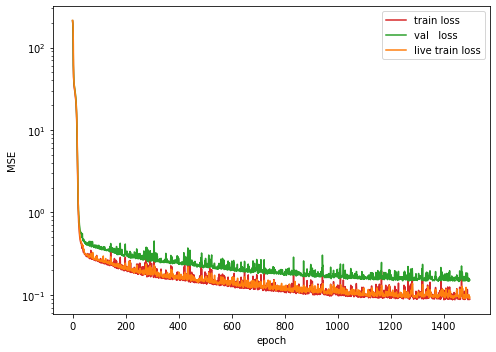

In [35]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

c1 = 'tab:red'
c2 = 'tab:green'
c3 = 'tab:orange'

axs.plot(trn_losses_l2, label="train loss", color=c1)
axs.plot(val_losses_l2, label="val   loss", color=c2)
axs.plot(trn_losses_live_l2, label="live train loss", color=c3)

axs.set_yscale('log')

axs.set_xlabel("epoch")
axs.set_ylabel("MSE")

axs.legend(loc='best')

fig.tight_layout()
    

Clearly the L2 regularisation has worked in reducing the over-fitting!

L1 regularisation should have a similar effect, try it out!

### Early stopping

As we saw in one of the previous plots in a training without any regularization the validation loss typically stops decreasing after a while (or in the worst case even starts increasing) while the training loss keeps on decreasining. The idea of Early Stopping is to simply stop the training when this happens.

------------
Copy paste again..

In [36]:
# a useful function to present things clearer
def seperator():
    print( "-----------------------------------------------" )

# define parameters
ipt_dim = 20
opt_dim = 1
hdn_dim = 50
batch_size = 64

trn_dataset = amp_dataset(trn_datfp.to(device), trn_amplp.unsqueeze(-1).to(device))
val_dataset = amp_dataset(val_datfp.to(device), val_amplp.unsqueeze(-1).to(device))
tst_dataset = amp_dataset(tst_datfp.to(device), tst_amplp.unsqueeze(-1).to(device))

trn_dataloader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
tst_dataloader = DataLoader(tst_dataset, batch_size=batch_size, shuffle=True)

epochs = 1500

# re-initialise the model and the optimizer
hdn_dim = 50
model = amp_net(hdn_dim=hdn_dim).to(device) # model without Dropout!
learning_rate = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

The trigger condition can be arbitrarily complicated but in its simpliest version we just compare the current value of the validation loss with the previous value. However, because the validation dataset is typically small and the validation loss therefore prone to statistical fluctuations, we should not immediately stop the training the first time the breaking condition is triggered. Instead, we introduce the new hyperparameter 'patience' which tells us how many epochs we want to wait before stopping the training.

In [37]:
seperator()
print("model architecture")
seperator()
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")


# track train and val losses
trn_losses_live_es = []
trn_losses_es = []
val_losses_es = []

# patience of EarlyStopping in number of epochs
patience = 4

# set counter to 0 for early stopping
trigger_counter = 0
val_loss_last = 1e10

for t in range(epochs):
    seperator()
    print(f"Epoch {t+1}")
    seperator()
    trn_loss_live = train_epoch(trn_dataloader, model, loss_fn, optimizer)
    trn_losses_live_es.append(trn_loss_live)
    seperator()
    trn_loss = trn_pass(trn_dataloader, model, loss_fn)
    trn_losses_es.append(trn_loss)
    seperator()
    val_loss = val_pass(val_dataloader, model, loss_fn)
    val_losses_es.append(val_loss)
    
    #######################
    # early stopping
    if val_loss > val_loss_last:
        trigger_counter += 1
    else:
        trigger_counter = 0
        
    if trigger_counter >= patience:
        print("EarlyStopping got triggered! Stop training!")
        break
    
    val_loss_last = val_loss
    #######################
    
    seperator()
    print( "|" )
    
    
print("Done!")

-----------------------------------------------
model architecture
-----------------------------------------------
amp_net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)
Model has 8751 trainable parameters
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 215.709625  [    0/ 1000]
avg train loss per batch in training: 215.415174
-----------------------------------------------
avg trn loss per batch: 213.748549
-----------------------------------------------
avg val loss per batch: 215.699629
-----------------------------------------------
|
---------------------

avg val loss per batch: 14.352424
-----------------------------------------------
|
-----------------------------------------------
Epoch 20
-----------------------------------------------
current batch loss: 9.037001  [    0/ 1000]
avg train loss per batch in training: 12.038972
-----------------------------------------------
avg trn loss per batch: 10.952696
-----------------------------------------------
avg val loss per batch: 11.907240
-----------------------------------------------
|
-----------------------------------------------
Epoch 21
-----------------------------------------------
current batch loss: 16.831869  [    0/ 1000]
avg train loss per batch in training: 9.777106
-----------------------------------------------
avg trn loss per batch: 8.443712
-----------------------------------------------
avg val loss per batch: 9.380938
-----------------------------------------------
|
-----------------------------------------------
Epoch 22
---------------------------------------

avg val loss per batch: 0.689518
-----------------------------------------------
|
-----------------------------------------------
Epoch 41
-----------------------------------------------
current batch loss: 0.965675  [    0/ 1000]
avg train loss per batch in training: 0.541159
-----------------------------------------------
avg trn loss per batch: 0.493169
-----------------------------------------------
avg val loss per batch: 0.660178
-----------------------------------------------
|
-----------------------------------------------
Epoch 42
-----------------------------------------------
current batch loss: 0.552223  [    0/ 1000]
avg train loss per batch in training: 0.514829
-----------------------------------------------
avg trn loss per batch: 0.477960
-----------------------------------------------
avg val loss per batch: 0.667571
-----------------------------------------------
|
-----------------------------------------------
Epoch 43
--------------------------------------------

avg val loss per batch: 0.562667
-----------------------------------------------
|
-----------------------------------------------
Epoch 62
-----------------------------------------------
current batch loss: 0.403430  [    0/ 1000]
avg train loss per batch in training: 0.372850
-----------------------------------------------
avg trn loss per batch: 0.358225
-----------------------------------------------
avg val loss per batch: 0.549484
-----------------------------------------------
|
-----------------------------------------------
Epoch 63
-----------------------------------------------
current batch loss: 0.439587  [    0/ 1000]
avg train loss per batch in training: 0.363843
-----------------------------------------------
avg trn loss per batch: 0.356998
-----------------------------------------------
avg val loss per batch: 0.588485
-----------------------------------------------
|
-----------------------------------------------
Epoch 64
--------------------------------------------

avg val loss per batch: 0.508461
-----------------------------------------------
|
-----------------------------------------------
Epoch 83
-----------------------------------------------
current batch loss: 0.333167  [    0/ 1000]
avg train loss per batch in training: 0.319992
-----------------------------------------------
avg trn loss per batch: 0.304882
-----------------------------------------------
avg val loss per batch: 0.554421
-----------------------------------------------
|
-----------------------------------------------
Epoch 84
-----------------------------------------------
current batch loss: 0.263034  [    0/ 1000]
avg train loss per batch in training: 0.310157
-----------------------------------------------
avg trn loss per batch: 0.298930
-----------------------------------------------
avg val loss per batch: 0.511463
-----------------------------------------------
|
-----------------------------------------------
Epoch 85
--------------------------------------------

avg val loss per batch: 0.485997
-----------------------------------------------
|
-----------------------------------------------
Epoch 104
-----------------------------------------------
current batch loss: 0.346981  [    0/ 1000]
avg train loss per batch in training: 0.282323
-----------------------------------------------
avg trn loss per batch: 0.262432
-----------------------------------------------
avg val loss per batch: 0.492152
-----------------------------------------------
|
-----------------------------------------------
Epoch 105
-----------------------------------------------
current batch loss: 0.284109  [    0/ 1000]
avg train loss per batch in training: 0.273240
-----------------------------------------------
avg trn loss per batch: 0.287139
-----------------------------------------------
avg val loss per batch: 0.556702
-----------------------------------------------
|
-----------------------------------------------
Epoch 106
-----------------------------------------

avg val loss per batch: 0.488620
-----------------------------------------------
|
-----------------------------------------------
Epoch 125
-----------------------------------------------
current batch loss: 0.247492  [    0/ 1000]
avg train loss per batch in training: 0.242249
-----------------------------------------------
avg trn loss per batch: 0.240181
-----------------------------------------------
avg val loss per batch: 0.474793
-----------------------------------------------
|
-----------------------------------------------
Epoch 126
-----------------------------------------------
current batch loss: 0.209977  [    0/ 1000]
avg train loss per batch in training: 0.252850
-----------------------------------------------
avg trn loss per batch: 0.236948
-----------------------------------------------
avg val loss per batch: 0.488256
-----------------------------------------------
|
-----------------------------------------------
Epoch 127
-----------------------------------------

avg val loss per batch: 0.458768
-----------------------------------------------
|
-----------------------------------------------
Epoch 146
-----------------------------------------------
current batch loss: 0.244481  [    0/ 1000]
avg train loss per batch in training: 0.226263
-----------------------------------------------
avg trn loss per batch: 0.210909
-----------------------------------------------
avg val loss per batch: 0.454514
-----------------------------------------------
|
-----------------------------------------------
Epoch 147
-----------------------------------------------
current batch loss: 0.226909  [    0/ 1000]
avg train loss per batch in training: 0.217749
-----------------------------------------------
avg trn loss per batch: 0.208703
-----------------------------------------------
avg val loss per batch: 0.461902
-----------------------------------------------
|
-----------------------------------------------
Epoch 148
-----------------------------------------

avg val loss per batch: 0.445974
-----------------------------------------------
|
-----------------------------------------------
Epoch 167
-----------------------------------------------
current batch loss: 0.164998  [    0/ 1000]
avg train loss per batch in training: 0.197544
-----------------------------------------------
avg trn loss per batch: 0.189226
-----------------------------------------------
avg val loss per batch: 0.428591
-----------------------------------------------
|
-----------------------------------------------
Epoch 168
-----------------------------------------------
current batch loss: 0.197019  [    0/ 1000]
avg train loss per batch in training: 0.196351
-----------------------------------------------
avg trn loss per batch: 0.188063
-----------------------------------------------
avg val loss per batch: 0.447556
-----------------------------------------------
|
-----------------------------------------------
Epoch 169
-----------------------------------------

avg val loss per batch: 0.421500
-----------------------------------------------
|
-----------------------------------------------
Epoch 188
-----------------------------------------------
current batch loss: 0.174061  [    0/ 1000]
avg train loss per batch in training: 0.183701
-----------------------------------------------
avg trn loss per batch: 0.170460
-----------------------------------------------
avg val loss per batch: 0.433837
-----------------------------------------------
|
-----------------------------------------------
Epoch 189
-----------------------------------------------
current batch loss: 0.128552  [    0/ 1000]
avg train loss per batch in training: 0.170125
-----------------------------------------------
avg trn loss per batch: 0.178917
-----------------------------------------------
avg val loss per batch: 0.450055
EarlyStopping got triggered! Stop training!
Done!


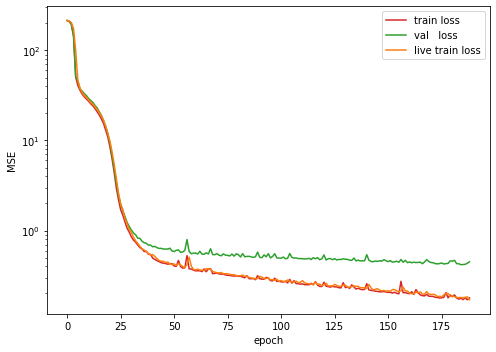

In [38]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

c1 = 'tab:red'
c2 = 'tab:green'
c3 = 'tab:orange'

axs.plot(trn_losses_es, label="train loss", color=c1)
axs.plot(val_losses_es, label="val   loss", color=c2)
axs.plot(trn_losses_live_es, label="live train loss", color=c3)

axs.set_yscale('log')

axs.set_xlabel("epoch")
axs.set_ylabel("MSE")

axs.legend(loc='best')

fig.tight_layout()

We can see here that the network has stopped training before the training loss diverges too far from the validation loss.

### Batch normalisation

Batch normalisation is not a method to prevent over-fitting, so we do not expect it to do that.  The point of batch normalisation is to make the training more efficient.  It's difficult to see the benefits of this regularisation method with the dataset we're using here, although it is still useful to learn how to implement it.  It works by normalising the data as it passes between the layers, keeping the distribution (i.e. mean and variance) of the data constant throughout training.  This means that the weights in a network layer do not have to adapt to simple changes in the distribution of the data in a previous layer of the network.

In [39]:
class amp_net_bn(nn.Module):

    # default hdn_dim is 30, but can be changed upon initialisation
    def __init__(self, hdn_dim=30):

        super(amp_net_bn, self).__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(ipt_dim, hdn_dim),
            nn.BatchNorm1d(hdn_dim),
            nn.ReLU(),
            nn.Linear(hdn_dim, hdn_dim),
            nn.BatchNorm1d(hdn_dim),
            nn.ReLU(),
            nn.Linear(hdn_dim, hdn_dim),
            nn.BatchNorm1d(hdn_dim),
            nn.ReLU(),
            nn.Linear(hdn_dim, hdn_dim),
            nn.BatchNorm1d(hdn_dim),
            nn.ReLU(),
            nn.Linear(hdn_dim, opt_dim),
        )

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out

In [40]:
# a useful function to present things clearer
def seperator():
    print( "-----------------------------------------------" )

# define parameters
ipt_dim = 20
opt_dim = 1
hdn_dim = 50
batch_size = 64

trn_dataset = amp_dataset(trn_datfp.to(device), trn_amplp.unsqueeze(-1).to(device))
val_dataset = amp_dataset(val_datfp.to(device), val_amplp.unsqueeze(-1).to(device))
tst_dataset = amp_dataset(tst_datfp.to(device), tst_amplp.unsqueeze(-1).to(device))

trn_dataloader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
tst_dataloader = DataLoader(tst_dataset, batch_size=batch_size, shuffle=True)
epochs = 1500

# re-initialise the model and the optimizer
hdn_dim = 50
model_bn = amp_net_bn(hdn_dim=hdn_dim).to(device)
learning_rate = 5e-4

optimizer = torch.optim.Adam(model_bn.parameters(), lr=learning_rate)

In [41]:
seperator()
print("model architecture")
seperator()
print(model_bn)
total_parameters = sum(p.numel() for p in model_bn.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")


# track train and val losses
trn_losses_live_bn = []
trn_losses_bn = []
val_losses_bn = []

# set counter to 0 for early stopping
trigger_counter = 0
val_loss_last = 1e10
for t in range(epochs):
    seperator()
    print(f"Epoch {t+1}")
    seperator()
    trn_loss_live = train_epoch(trn_dataloader, model_bn, loss_fn, optimizer)
    trn_losses_live_es.append(trn_loss_live)
    seperator()
    model_bn.eval()
    trn_loss = trn_pass(trn_dataloader, model_bn, loss_fn)
    trn_losses_bn.append(trn_loss)
    seperator()
    val_loss = val_pass(val_dataloader, model_bn, loss_fn)
    val_losses_bn.append(val_loss)
    model_bn.train()
    
    seperator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
model architecture
-----------------------------------------------
amp_net_bn(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=50, bias=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=50, out_features=50, bias=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=1, bias=True)
  )
)
Model has 9151 trainable parameters
-----------------------------------------------
Epoch 1
------------------

avg val loss per batch: 105.630210
-----------------------------------------------
|
-----------------------------------------------
Epoch 19
-----------------------------------------------
current batch loss: 107.316338  [    0/ 1000]
avg train loss per batch in training: 99.966396
-----------------------------------------------
avg trn loss per batch: 97.524246
-----------------------------------------------
avg val loss per batch: 99.481631
-----------------------------------------------
|
-----------------------------------------------
Epoch 20
-----------------------------------------------
current batch loss: 99.696457  [    0/ 1000]
avg train loss per batch in training: 93.581184
-----------------------------------------------
avg trn loss per batch: 90.606887
-----------------------------------------------
avg val loss per batch: 92.452055
-----------------------------------------------
|
-----------------------------------------------
Epoch 21
---------------------------------

avg val loss per batch: 14.291013
-----------------------------------------------
|
-----------------------------------------------
Epoch 39
-----------------------------------------------
current batch loss: 12.206768  [    0/ 1000]
avg train loss per batch in training: 11.624485
-----------------------------------------------
avg trn loss per batch: 11.068156
-----------------------------------------------
avg val loss per batch: 11.876040
-----------------------------------------------
|
-----------------------------------------------
Epoch 40
-----------------------------------------------
current batch loss: 10.274746  [    0/ 1000]
avg train loss per batch in training: 9.762814
-----------------------------------------------
avg trn loss per batch: 9.633220
-----------------------------------------------
avg val loss per batch: 10.444033
-----------------------------------------------
|
-----------------------------------------------
Epoch 41
-------------------------------------

avg val loss per batch: 0.748343
-----------------------------------------------
|
-----------------------------------------------
Epoch 60
-----------------------------------------------
current batch loss: 0.656488  [    0/ 1000]
avg train loss per batch in training: 0.663489
-----------------------------------------------
avg trn loss per batch: 0.473078
-----------------------------------------------
avg val loss per batch: 0.688467
-----------------------------------------------
|
-----------------------------------------------
Epoch 61
-----------------------------------------------
current batch loss: 0.603215  [    0/ 1000]
avg train loss per batch in training: 0.758721
-----------------------------------------------
avg trn loss per batch: 0.448212
-----------------------------------------------
avg val loss per batch: 0.678170
-----------------------------------------------
|
-----------------------------------------------
Epoch 62
--------------------------------------------

avg val loss per batch: 0.438629
-----------------------------------------------
|
-----------------------------------------------
Epoch 81
-----------------------------------------------
current batch loss: 0.260974  [    0/ 1000]
avg train loss per batch in training: 0.505199
-----------------------------------------------
avg trn loss per batch: 0.261721
-----------------------------------------------
avg val loss per batch: 0.453511
-----------------------------------------------
|
-----------------------------------------------
Epoch 82
-----------------------------------------------
current batch loss: 0.264705  [    0/ 1000]
avg train loss per batch in training: 0.463022
-----------------------------------------------
avg trn loss per batch: 0.234574
-----------------------------------------------
avg val loss per batch: 0.441141
-----------------------------------------------
|
-----------------------------------------------
Epoch 83
--------------------------------------------

avg val loss per batch: 0.395730
-----------------------------------------------
|
-----------------------------------------------
Epoch 102
-----------------------------------------------
current batch loss: 0.411018  [    0/ 1000]
avg train loss per batch in training: 0.328201
-----------------------------------------------
avg trn loss per batch: 0.148288
-----------------------------------------------
avg val loss per batch: 0.345884
-----------------------------------------------
|
-----------------------------------------------
Epoch 103
-----------------------------------------------
current batch loss: 0.340256  [    0/ 1000]
avg train loss per batch in training: 0.322380
-----------------------------------------------
avg trn loss per batch: 0.176710
-----------------------------------------------
avg val loss per batch: 0.389402
-----------------------------------------------
|
-----------------------------------------------
Epoch 104
-----------------------------------------

avg val loss per batch: 0.336246
-----------------------------------------------
|
-----------------------------------------------
Epoch 123
-----------------------------------------------
current batch loss: 0.229425  [    0/ 1000]
avg train loss per batch in training: 0.264959
-----------------------------------------------
avg trn loss per batch: 0.146130
-----------------------------------------------
avg val loss per batch: 0.356674
-----------------------------------------------
|
-----------------------------------------------
Epoch 124
-----------------------------------------------
current batch loss: 0.281217  [    0/ 1000]
avg train loss per batch in training: 0.254659
-----------------------------------------------
avg trn loss per batch: 0.124503
-----------------------------------------------
avg val loss per batch: 0.322984
-----------------------------------------------
|
-----------------------------------------------
Epoch 125
-----------------------------------------

avg val loss per batch: 0.294186
-----------------------------------------------
|
-----------------------------------------------
Epoch 144
-----------------------------------------------
current batch loss: 0.609196  [    0/ 1000]
avg train loss per batch in training: 0.269492
-----------------------------------------------
avg trn loss per batch: 0.140774
-----------------------------------------------
avg val loss per batch: 0.343789
-----------------------------------------------
|
-----------------------------------------------
Epoch 145
-----------------------------------------------
current batch loss: 0.102202  [    0/ 1000]
avg train loss per batch in training: 0.204036
-----------------------------------------------
avg trn loss per batch: 0.110216
-----------------------------------------------
avg val loss per batch: 0.299775
-----------------------------------------------
|
-----------------------------------------------
Epoch 146
-----------------------------------------

avg val loss per batch: 0.301324
-----------------------------------------------
|
-----------------------------------------------
Epoch 165
-----------------------------------------------
current batch loss: 0.305640  [    0/ 1000]
avg train loss per batch in training: 0.247354
-----------------------------------------------
avg trn loss per batch: 0.133674
-----------------------------------------------
avg val loss per batch: 0.317169
-----------------------------------------------
|
-----------------------------------------------
Epoch 166
-----------------------------------------------
current batch loss: 0.218891  [    0/ 1000]
avg train loss per batch in training: 0.195042
-----------------------------------------------
avg trn loss per batch: 0.096164
-----------------------------------------------
avg val loss per batch: 0.270130
-----------------------------------------------
|
-----------------------------------------------
Epoch 167
-----------------------------------------

avg val loss per batch: 0.263735
-----------------------------------------------
|
-----------------------------------------------
Epoch 186
-----------------------------------------------
current batch loss: 0.169376  [    0/ 1000]
avg train loss per batch in training: 0.198115
-----------------------------------------------
avg trn loss per batch: 0.090496
-----------------------------------------------
avg val loss per batch: 0.258606
-----------------------------------------------
|
-----------------------------------------------
Epoch 187
-----------------------------------------------
current batch loss: 0.221282  [    0/ 1000]
avg train loss per batch in training: 0.212114
-----------------------------------------------
avg trn loss per batch: 0.087033
-----------------------------------------------
avg val loss per batch: 0.253784
-----------------------------------------------
|
-----------------------------------------------
Epoch 188
-----------------------------------------

avg val loss per batch: 0.243443
-----------------------------------------------
|
-----------------------------------------------
Epoch 207
-----------------------------------------------
current batch loss: 0.182668  [    0/ 1000]
avg train loss per batch in training: 0.209814
-----------------------------------------------
avg trn loss per batch: 0.086632
-----------------------------------------------
avg val loss per batch: 0.259064
-----------------------------------------------
|
-----------------------------------------------
Epoch 208
-----------------------------------------------
current batch loss: 0.117650  [    0/ 1000]
avg train loss per batch in training: 0.190895
-----------------------------------------------
avg trn loss per batch: 0.086832
-----------------------------------------------
avg val loss per batch: 0.261638
-----------------------------------------------
|
-----------------------------------------------
Epoch 209
-----------------------------------------

avg val loss per batch: 0.251833
-----------------------------------------------
|
-----------------------------------------------
Epoch 228
-----------------------------------------------
current batch loss: 0.119471  [    0/ 1000]
avg train loss per batch in training: 0.186347
-----------------------------------------------
avg trn loss per batch: 0.083650
-----------------------------------------------
avg val loss per batch: 0.241149
-----------------------------------------------
|
-----------------------------------------------
Epoch 229
-----------------------------------------------
current batch loss: 0.118117  [    0/ 1000]
avg train loss per batch in training: 0.171522
-----------------------------------------------
avg trn loss per batch: 0.082106
-----------------------------------------------
avg val loss per batch: 0.241024
-----------------------------------------------
|
-----------------------------------------------
Epoch 230
-----------------------------------------

avg val loss per batch: 0.242074
-----------------------------------------------
|
-----------------------------------------------
Epoch 249
-----------------------------------------------
current batch loss: 0.158271  [    0/ 1000]
avg train loss per batch in training: 0.189950
-----------------------------------------------
avg trn loss per batch: 0.075485
-----------------------------------------------
avg val loss per batch: 0.227541
-----------------------------------------------
|
-----------------------------------------------
Epoch 250
-----------------------------------------------
current batch loss: 0.149880  [    0/ 1000]
avg train loss per batch in training: 0.147545
-----------------------------------------------
avg trn loss per batch: 0.068203
-----------------------------------------------
avg val loss per batch: 0.220608
-----------------------------------------------
|
-----------------------------------------------
Epoch 251
-----------------------------------------

avg val loss per batch: 0.230732
-----------------------------------------------
|
-----------------------------------------------
Epoch 270
-----------------------------------------------
current batch loss: 0.181405  [    0/ 1000]
avg train loss per batch in training: 0.182836
-----------------------------------------------
avg trn loss per batch: 0.066966
-----------------------------------------------
avg val loss per batch: 0.215685
-----------------------------------------------
|
-----------------------------------------------
Epoch 271
-----------------------------------------------
current batch loss: 0.172197  [    0/ 1000]
avg train loss per batch in training: 0.144175
-----------------------------------------------
avg trn loss per batch: 0.070276
-----------------------------------------------
avg val loss per batch: 0.227178
-----------------------------------------------
|
-----------------------------------------------
Epoch 272
-----------------------------------------

avg val loss per batch: 0.214432
-----------------------------------------------
|
-----------------------------------------------
Epoch 291
-----------------------------------------------
current batch loss: 0.110456  [    0/ 1000]
avg train loss per batch in training: 0.154260
-----------------------------------------------
avg trn loss per batch: 0.072192
-----------------------------------------------
avg val loss per batch: 0.224123
-----------------------------------------------
|
-----------------------------------------------
Epoch 292
-----------------------------------------------
current batch loss: 0.069594  [    0/ 1000]
avg train loss per batch in training: 0.146760
-----------------------------------------------
avg trn loss per batch: 0.058011
-----------------------------------------------
avg val loss per batch: 0.201556
-----------------------------------------------
|
-----------------------------------------------
Epoch 293
-----------------------------------------

avg val loss per batch: 0.230221
-----------------------------------------------
|
-----------------------------------------------
Epoch 312
-----------------------------------------------
current batch loss: 0.106388  [    0/ 1000]
avg train loss per batch in training: 0.131331
-----------------------------------------------
avg trn loss per batch: 0.063971
-----------------------------------------------
avg val loss per batch: 0.208432
-----------------------------------------------
|
-----------------------------------------------
Epoch 313
-----------------------------------------------
current batch loss: 0.150910  [    0/ 1000]
avg train loss per batch in training: 0.130506
-----------------------------------------------
avg trn loss per batch: 0.046627
-----------------------------------------------
avg val loss per batch: 0.189512
-----------------------------------------------
|
-----------------------------------------------
Epoch 314
-----------------------------------------

avg val loss per batch: 0.202193
-----------------------------------------------
|
-----------------------------------------------
Epoch 333
-----------------------------------------------
current batch loss: 0.117971  [    0/ 1000]
avg train loss per batch in training: 0.129409
-----------------------------------------------
avg trn loss per batch: 0.055141
-----------------------------------------------
avg val loss per batch: 0.190812
-----------------------------------------------
|
-----------------------------------------------
Epoch 334
-----------------------------------------------
current batch loss: 0.080634  [    0/ 1000]
avg train loss per batch in training: 0.150314
-----------------------------------------------
avg trn loss per batch: 0.057643
-----------------------------------------------
avg val loss per batch: 0.184056
-----------------------------------------------
|
-----------------------------------------------
Epoch 335
-----------------------------------------

avg val loss per batch: 0.185086
-----------------------------------------------
|
-----------------------------------------------
Epoch 354
-----------------------------------------------
current batch loss: 0.074776  [    0/ 1000]
avg train loss per batch in training: 0.141220
-----------------------------------------------
avg trn loss per batch: 0.051576
-----------------------------------------------
avg val loss per batch: 0.190842
-----------------------------------------------
|
-----------------------------------------------
Epoch 355
-----------------------------------------------
current batch loss: 0.070433  [    0/ 1000]
avg train loss per batch in training: 0.116571
-----------------------------------------------
avg trn loss per batch: 0.059134
-----------------------------------------------
avg val loss per batch: 0.202614
-----------------------------------------------
|
-----------------------------------------------
Epoch 356
-----------------------------------------

avg val loss per batch: 0.185863
-----------------------------------------------
|
-----------------------------------------------
Epoch 375
-----------------------------------------------
current batch loss: 0.102993  [    0/ 1000]
avg train loss per batch in training: 0.112241
-----------------------------------------------
avg trn loss per batch: 0.042707
-----------------------------------------------
avg val loss per batch: 0.182355
-----------------------------------------------
|
-----------------------------------------------
Epoch 376
-----------------------------------------------
current batch loss: 0.103590  [    0/ 1000]
avg train loss per batch in training: 0.118565
-----------------------------------------------
avg trn loss per batch: 0.042587
-----------------------------------------------
avg val loss per batch: 0.188211
-----------------------------------------------
|
-----------------------------------------------
Epoch 377
-----------------------------------------

avg val loss per batch: 0.183039
-----------------------------------------------
|
-----------------------------------------------
Epoch 396
-----------------------------------------------
current batch loss: 0.091142  [    0/ 1000]
avg train loss per batch in training: 0.100907
-----------------------------------------------
avg trn loss per batch: 0.037617
-----------------------------------------------
avg val loss per batch: 0.176477
-----------------------------------------------
|
-----------------------------------------------
Epoch 397
-----------------------------------------------
current batch loss: 0.091078  [    0/ 1000]
avg train loss per batch in training: 0.131853
-----------------------------------------------
avg trn loss per batch: 0.051628
-----------------------------------------------
avg val loss per batch: 0.186466
-----------------------------------------------
|
-----------------------------------------------
Epoch 398
-----------------------------------------

avg val loss per batch: 0.212549
-----------------------------------------------
|
-----------------------------------------------
Epoch 417
-----------------------------------------------
current batch loss: 0.093044  [    0/ 1000]
avg train loss per batch in training: 0.110210
-----------------------------------------------
avg trn loss per batch: 0.050542
-----------------------------------------------
avg val loss per batch: 0.194697
-----------------------------------------------
|
-----------------------------------------------
Epoch 418
-----------------------------------------------
current batch loss: 0.071666  [    0/ 1000]
avg train loss per batch in training: 0.105142
-----------------------------------------------
avg trn loss per batch: 0.047439
-----------------------------------------------
avg val loss per batch: 0.187692
-----------------------------------------------
|
-----------------------------------------------
Epoch 419
-----------------------------------------

avg val loss per batch: 0.169872
-----------------------------------------------
|
-----------------------------------------------
Epoch 438
-----------------------------------------------
current batch loss: 0.102430  [    0/ 1000]
avg train loss per batch in training: 0.096331
-----------------------------------------------
avg trn loss per batch: 0.060126
-----------------------------------------------
avg val loss per batch: 0.196243
-----------------------------------------------
|
-----------------------------------------------
Epoch 439
-----------------------------------------------
current batch loss: 0.061875  [    0/ 1000]
avg train loss per batch in training: 0.090037
-----------------------------------------------
avg trn loss per batch: 0.044378
-----------------------------------------------
avg val loss per batch: 0.177323
-----------------------------------------------
|
-----------------------------------------------
Epoch 440
-----------------------------------------

avg val loss per batch: 0.207208
-----------------------------------------------
|
-----------------------------------------------
Epoch 459
-----------------------------------------------
current batch loss: 0.144902  [    0/ 1000]
avg train loss per batch in training: 0.121465
-----------------------------------------------
avg trn loss per batch: 0.060181
-----------------------------------------------
avg val loss per batch: 0.204338
-----------------------------------------------
|
-----------------------------------------------
Epoch 460
-----------------------------------------------
current batch loss: 0.065860  [    0/ 1000]
avg train loss per batch in training: 0.108990
-----------------------------------------------
avg trn loss per batch: 0.042114
-----------------------------------------------
avg val loss per batch: 0.181761
-----------------------------------------------
|
-----------------------------------------------
Epoch 461
-----------------------------------------

avg val loss per batch: 0.174123
-----------------------------------------------
|
-----------------------------------------------
Epoch 480
-----------------------------------------------
current batch loss: 0.108954  [    0/ 1000]
avg train loss per batch in training: 0.104294
-----------------------------------------------
avg trn loss per batch: 0.042324
-----------------------------------------------
avg val loss per batch: 0.181198
-----------------------------------------------
|
-----------------------------------------------
Epoch 481
-----------------------------------------------
current batch loss: 0.134487  [    0/ 1000]
avg train loss per batch in training: 0.116181
-----------------------------------------------
avg trn loss per batch: 0.052870
-----------------------------------------------
avg val loss per batch: 0.193225
-----------------------------------------------
|
-----------------------------------------------
Epoch 482
-----------------------------------------

avg val loss per batch: 0.177323
-----------------------------------------------
|
-----------------------------------------------
Epoch 501
-----------------------------------------------
current batch loss: 0.120182  [    0/ 1000]
avg train loss per batch in training: 0.091293
-----------------------------------------------
avg trn loss per batch: 0.030534
-----------------------------------------------
avg val loss per batch: 0.163852
-----------------------------------------------
|
-----------------------------------------------
Epoch 502
-----------------------------------------------
current batch loss: 0.090229  [    0/ 1000]
avg train loss per batch in training: 0.090372
-----------------------------------------------
avg trn loss per batch: 0.046451
-----------------------------------------------
avg val loss per batch: 0.178605
-----------------------------------------------
|
-----------------------------------------------
Epoch 503
-----------------------------------------

avg val loss per batch: 0.175505
-----------------------------------------------
|
-----------------------------------------------
Epoch 522
-----------------------------------------------
current batch loss: 0.151272  [    0/ 1000]
avg train loss per batch in training: 0.099811
-----------------------------------------------
avg trn loss per batch: 0.032281
-----------------------------------------------
avg val loss per batch: 0.159609
-----------------------------------------------
|
-----------------------------------------------
Epoch 523
-----------------------------------------------
current batch loss: 0.144298  [    0/ 1000]
avg train loss per batch in training: 0.102015
-----------------------------------------------
avg trn loss per batch: 0.049713
-----------------------------------------------
avg val loss per batch: 0.188938
-----------------------------------------------
|
-----------------------------------------------
Epoch 524
-----------------------------------------

avg val loss per batch: 0.170768
-----------------------------------------------
|
-----------------------------------------------
Epoch 543
-----------------------------------------------
current batch loss: 0.111868  [    0/ 1000]
avg train loss per batch in training: 0.112022
-----------------------------------------------
avg trn loss per batch: 0.048838
-----------------------------------------------
avg val loss per batch: 0.184037
-----------------------------------------------
|
-----------------------------------------------
Epoch 544
-----------------------------------------------
current batch loss: 0.143451  [    0/ 1000]
avg train loss per batch in training: 0.092898
-----------------------------------------------
avg trn loss per batch: 0.043008
-----------------------------------------------
avg val loss per batch: 0.172428
-----------------------------------------------
|
-----------------------------------------------
Epoch 545
-----------------------------------------

avg val loss per batch: 0.179028
-----------------------------------------------
|
-----------------------------------------------
Epoch 564
-----------------------------------------------
current batch loss: 0.076404  [    0/ 1000]
avg train loss per batch in training: 0.090533
-----------------------------------------------
avg trn loss per batch: 0.043083
-----------------------------------------------
avg val loss per batch: 0.174098
-----------------------------------------------
|
-----------------------------------------------
Epoch 565
-----------------------------------------------
current batch loss: 0.062086  [    0/ 1000]
avg train loss per batch in training: 0.083377
-----------------------------------------------
avg trn loss per batch: 0.043310
-----------------------------------------------
avg val loss per batch: 0.181781
-----------------------------------------------
|
-----------------------------------------------
Epoch 566
-----------------------------------------

avg val loss per batch: 0.176201
-----------------------------------------------
|
-----------------------------------------------
Epoch 585
-----------------------------------------------
current batch loss: 0.089949  [    0/ 1000]
avg train loss per batch in training: 0.097212
-----------------------------------------------
avg trn loss per batch: 0.057440
-----------------------------------------------
avg val loss per batch: 0.189014
-----------------------------------------------
|
-----------------------------------------------
Epoch 586
-----------------------------------------------
current batch loss: 0.075003  [    0/ 1000]
avg train loss per batch in training: 0.080799
-----------------------------------------------
avg trn loss per batch: 0.041190
-----------------------------------------------
avg val loss per batch: 0.177780
-----------------------------------------------
|
-----------------------------------------------
Epoch 587
-----------------------------------------

avg val loss per batch: 0.164594
-----------------------------------------------
|
-----------------------------------------------
Epoch 606
-----------------------------------------------
current batch loss: 0.058290  [    0/ 1000]
avg train loss per batch in training: 0.084025
-----------------------------------------------
avg trn loss per batch: 0.029793
-----------------------------------------------
avg val loss per batch: 0.161180
-----------------------------------------------
|
-----------------------------------------------
Epoch 607
-----------------------------------------------
current batch loss: 0.070875  [    0/ 1000]
avg train loss per batch in training: 0.085045
-----------------------------------------------
avg trn loss per batch: 0.042525
-----------------------------------------------
avg val loss per batch: 0.175028
-----------------------------------------------
|
-----------------------------------------------
Epoch 608
-----------------------------------------

avg val loss per batch: 0.176276
-----------------------------------------------
|
-----------------------------------------------
Epoch 627
-----------------------------------------------
current batch loss: 0.041433  [    0/ 1000]
avg train loss per batch in training: 0.095827
-----------------------------------------------
avg trn loss per batch: 0.036262
-----------------------------------------------
avg val loss per batch: 0.171800
-----------------------------------------------
|
-----------------------------------------------
Epoch 628
-----------------------------------------------
current batch loss: 0.073160  [    0/ 1000]
avg train loss per batch in training: 0.076940
-----------------------------------------------
avg trn loss per batch: 0.033264
-----------------------------------------------
avg val loss per batch: 0.171343
-----------------------------------------------
|
-----------------------------------------------
Epoch 629
-----------------------------------------

avg val loss per batch: 0.175660
-----------------------------------------------
|
-----------------------------------------------
Epoch 648
-----------------------------------------------
current batch loss: 0.054753  [    0/ 1000]
avg train loss per batch in training: 0.076314
-----------------------------------------------
avg trn loss per batch: 0.046817
-----------------------------------------------
avg val loss per batch: 0.177693
-----------------------------------------------
|
-----------------------------------------------
Epoch 649
-----------------------------------------------
current batch loss: 0.064370  [    0/ 1000]
avg train loss per batch in training: 0.074043
-----------------------------------------------
avg trn loss per batch: 0.036612
-----------------------------------------------
avg val loss per batch: 0.165560
-----------------------------------------------
|
-----------------------------------------------
Epoch 650
-----------------------------------------

avg val loss per batch: 0.172061
-----------------------------------------------
|
-----------------------------------------------
Epoch 669
-----------------------------------------------
current batch loss: 0.154115  [    0/ 1000]
avg train loss per batch in training: 0.104557
-----------------------------------------------
avg trn loss per batch: 0.062603
-----------------------------------------------
avg val loss per batch: 0.205214
-----------------------------------------------
|
-----------------------------------------------
Epoch 670
-----------------------------------------------
current batch loss: 0.091386  [    0/ 1000]
avg train loss per batch in training: 0.076405
-----------------------------------------------
avg trn loss per batch: 0.044144
-----------------------------------------------
avg val loss per batch: 0.184270
-----------------------------------------------
|
-----------------------------------------------
Epoch 671
-----------------------------------------

avg val loss per batch: 0.164180
-----------------------------------------------
|
-----------------------------------------------
Epoch 690
-----------------------------------------------
current batch loss: 0.074179  [    0/ 1000]
avg train loss per batch in training: 0.071099
-----------------------------------------------
avg trn loss per batch: 0.027158
-----------------------------------------------
avg val loss per batch: 0.158675
-----------------------------------------------
|
-----------------------------------------------
Epoch 691
-----------------------------------------------
current batch loss: 0.058691  [    0/ 1000]
avg train loss per batch in training: 0.071489
-----------------------------------------------
avg trn loss per batch: 0.031474
-----------------------------------------------
avg val loss per batch: 0.160466
-----------------------------------------------
|
-----------------------------------------------
Epoch 692
-----------------------------------------

avg val loss per batch: 0.161613
-----------------------------------------------
|
-----------------------------------------------
Epoch 711
-----------------------------------------------
current batch loss: 0.067783  [    0/ 1000]
avg train loss per batch in training: 0.076361
-----------------------------------------------
avg trn loss per batch: 0.041337
-----------------------------------------------
avg val loss per batch: 0.173434
-----------------------------------------------
|
-----------------------------------------------
Epoch 712
-----------------------------------------------
current batch loss: 0.070763  [    0/ 1000]
avg train loss per batch in training: 0.083961
-----------------------------------------------
avg trn loss per batch: 0.027853
-----------------------------------------------
avg val loss per batch: 0.156876
-----------------------------------------------
|
-----------------------------------------------
Epoch 713
-----------------------------------------

avg val loss per batch: 0.156885
-----------------------------------------------
|
-----------------------------------------------
Epoch 732
-----------------------------------------------
current batch loss: 0.095112  [    0/ 1000]
avg train loss per batch in training: 0.085371
-----------------------------------------------
avg trn loss per batch: 0.028486
-----------------------------------------------
avg val loss per batch: 0.158984
-----------------------------------------------
|
-----------------------------------------------
Epoch 733
-----------------------------------------------
current batch loss: 0.112148  [    0/ 1000]
avg train loss per batch in training: 0.087026
-----------------------------------------------
avg trn loss per batch: 0.040584
-----------------------------------------------
avg val loss per batch: 0.167626
-----------------------------------------------
|
-----------------------------------------------
Epoch 734
-----------------------------------------

avg val loss per batch: 0.169255
-----------------------------------------------
|
-----------------------------------------------
Epoch 753
-----------------------------------------------
current batch loss: 0.050601  [    0/ 1000]
avg train loss per batch in training: 0.065897
-----------------------------------------------
avg trn loss per batch: 0.035730
-----------------------------------------------
avg val loss per batch: 0.161515
-----------------------------------------------
|
-----------------------------------------------
Epoch 754
-----------------------------------------------
current batch loss: 0.060716  [    0/ 1000]
avg train loss per batch in training: 0.071433
-----------------------------------------------
avg trn loss per batch: 0.046197
-----------------------------------------------
avg val loss per batch: 0.173201
-----------------------------------------------
|
-----------------------------------------------
Epoch 755
-----------------------------------------

avg val loss per batch: 0.183951
-----------------------------------------------
|
-----------------------------------------------
Epoch 774
-----------------------------------------------
current batch loss: 0.058356  [    0/ 1000]
avg train loss per batch in training: 0.063592
-----------------------------------------------
avg trn loss per batch: 0.034664
-----------------------------------------------
avg val loss per batch: 0.169669
-----------------------------------------------
|
-----------------------------------------------
Epoch 775
-----------------------------------------------
current batch loss: 0.041658  [    0/ 1000]
avg train loss per batch in training: 0.064083
-----------------------------------------------
avg trn loss per batch: 0.035180
-----------------------------------------------
avg val loss per batch: 0.166240
-----------------------------------------------
|
-----------------------------------------------
Epoch 776
-----------------------------------------

avg val loss per batch: 0.165838
-----------------------------------------------
|
-----------------------------------------------
Epoch 795
-----------------------------------------------
current batch loss: 0.111305  [    0/ 1000]
avg train loss per batch in training: 0.078737
-----------------------------------------------
avg trn loss per batch: 0.029150
-----------------------------------------------
avg val loss per batch: 0.156855
-----------------------------------------------
|
-----------------------------------------------
Epoch 796
-----------------------------------------------
current batch loss: 0.085667  [    0/ 1000]
avg train loss per batch in training: 0.083301
-----------------------------------------------
avg trn loss per batch: 0.024668
-----------------------------------------------
avg val loss per batch: 0.154981
-----------------------------------------------
|
-----------------------------------------------
Epoch 797
-----------------------------------------

avg val loss per batch: 0.182230
-----------------------------------------------
|
-----------------------------------------------
Epoch 816
-----------------------------------------------
current batch loss: 0.059101  [    0/ 1000]
avg train loss per batch in training: 0.073237
-----------------------------------------------
avg trn loss per batch: 0.053084
-----------------------------------------------
avg val loss per batch: 0.198267
-----------------------------------------------
|
-----------------------------------------------
Epoch 817
-----------------------------------------------
current batch loss: 0.045074  [    0/ 1000]
avg train loss per batch in training: 0.083868
-----------------------------------------------
avg trn loss per batch: 0.042982
-----------------------------------------------
avg val loss per batch: 0.182614
-----------------------------------------------
|
-----------------------------------------------
Epoch 818
-----------------------------------------

avg val loss per batch: 0.157995
-----------------------------------------------
|
-----------------------------------------------
Epoch 837
-----------------------------------------------
current batch loss: 0.087710  [    0/ 1000]
avg train loss per batch in training: 0.079601
-----------------------------------------------
avg trn loss per batch: 0.033948
-----------------------------------------------
avg val loss per batch: 0.162068
-----------------------------------------------
|
-----------------------------------------------
Epoch 838
-----------------------------------------------
current batch loss: 0.054156  [    0/ 1000]
avg train loss per batch in training: 0.076827
-----------------------------------------------
avg trn loss per batch: 0.024477
-----------------------------------------------
avg val loss per batch: 0.151416
-----------------------------------------------
|
-----------------------------------------------
Epoch 839
-----------------------------------------

avg val loss per batch: 0.162091
-----------------------------------------------
|
-----------------------------------------------
Epoch 858
-----------------------------------------------
current batch loss: 0.118752  [    0/ 1000]
avg train loss per batch in training: 0.078142
-----------------------------------------------
avg trn loss per batch: 0.042185
-----------------------------------------------
avg val loss per batch: 0.163654
-----------------------------------------------
|
-----------------------------------------------
Epoch 859
-----------------------------------------------
current batch loss: 0.082483  [    0/ 1000]
avg train loss per batch in training: 0.060283
-----------------------------------------------
avg trn loss per batch: 0.032162
-----------------------------------------------
avg val loss per batch: 0.160154
-----------------------------------------------
|
-----------------------------------------------
Epoch 860
-----------------------------------------

avg val loss per batch: 0.187873
-----------------------------------------------
|
-----------------------------------------------
Epoch 879
-----------------------------------------------
current batch loss: 0.035936  [    0/ 1000]
avg train loss per batch in training: 0.074681
-----------------------------------------------
avg trn loss per batch: 0.030981
-----------------------------------------------
avg val loss per batch: 0.172507
-----------------------------------------------
|
-----------------------------------------------
Epoch 880
-----------------------------------------------
current batch loss: 0.128118  [    0/ 1000]
avg train loss per batch in training: 0.062860
-----------------------------------------------
avg trn loss per batch: 0.023051
-----------------------------------------------
avg val loss per batch: 0.154791
-----------------------------------------------
|
-----------------------------------------------
Epoch 881
-----------------------------------------

avg val loss per batch: 0.180880
-----------------------------------------------
|
-----------------------------------------------
Epoch 900
-----------------------------------------------
current batch loss: 0.119033  [    0/ 1000]
avg train loss per batch in training: 0.070729
-----------------------------------------------
avg trn loss per batch: 0.030540
-----------------------------------------------
avg val loss per batch: 0.162873
-----------------------------------------------
|
-----------------------------------------------
Epoch 901
-----------------------------------------------
current batch loss: 0.035571  [    0/ 1000]
avg train loss per batch in training: 0.086545
-----------------------------------------------
avg trn loss per batch: 0.025908
-----------------------------------------------
avg val loss per batch: 0.146688
-----------------------------------------------
|
-----------------------------------------------
Epoch 902
-----------------------------------------

avg val loss per batch: 0.174548
-----------------------------------------------
|
-----------------------------------------------
Epoch 921
-----------------------------------------------
current batch loss: 0.077223  [    0/ 1000]
avg train loss per batch in training: 0.076973
-----------------------------------------------
avg trn loss per batch: 0.034278
-----------------------------------------------
avg val loss per batch: 0.158503
-----------------------------------------------
|
-----------------------------------------------
Epoch 922
-----------------------------------------------
current batch loss: 0.051038  [    0/ 1000]
avg train loss per batch in training: 0.071497
-----------------------------------------------
avg trn loss per batch: 0.032917
-----------------------------------------------
avg val loss per batch: 0.167631
-----------------------------------------------
|
-----------------------------------------------
Epoch 923
-----------------------------------------

avg val loss per batch: 0.172757
-----------------------------------------------
|
-----------------------------------------------
Epoch 942
-----------------------------------------------
current batch loss: 0.041966  [    0/ 1000]
avg train loss per batch in training: 0.061723
-----------------------------------------------
avg trn loss per batch: 0.050783
-----------------------------------------------
avg val loss per batch: 0.181082
-----------------------------------------------
|
-----------------------------------------------
Epoch 943
-----------------------------------------------
current batch loss: 0.034709  [    0/ 1000]
avg train loss per batch in training: 0.070742
-----------------------------------------------
avg trn loss per batch: 0.029486
-----------------------------------------------
avg val loss per batch: 0.162642
-----------------------------------------------
|
-----------------------------------------------
Epoch 944
-----------------------------------------

avg val loss per batch: 0.167513
-----------------------------------------------
|
-----------------------------------------------
Epoch 963
-----------------------------------------------
current batch loss: 0.133123  [    0/ 1000]
avg train loss per batch in training: 0.076792
-----------------------------------------------
avg trn loss per batch: 0.043737
-----------------------------------------------
avg val loss per batch: 0.166147
-----------------------------------------------
|
-----------------------------------------------
Epoch 964
-----------------------------------------------
current batch loss: 0.066187  [    0/ 1000]
avg train loss per batch in training: 0.060191
-----------------------------------------------
avg trn loss per batch: 0.026118
-----------------------------------------------
avg val loss per batch: 0.151164
-----------------------------------------------
|
-----------------------------------------------
Epoch 965
-----------------------------------------

avg val loss per batch: 0.157706
-----------------------------------------------
|
-----------------------------------------------
Epoch 984
-----------------------------------------------
current batch loss: 0.063901  [    0/ 1000]
avg train loss per batch in training: 0.065963
-----------------------------------------------
avg trn loss per batch: 0.048050
-----------------------------------------------
avg val loss per batch: 0.175819
-----------------------------------------------
|
-----------------------------------------------
Epoch 985
-----------------------------------------------
current batch loss: 0.041048  [    0/ 1000]
avg train loss per batch in training: 0.066225
-----------------------------------------------
avg trn loss per batch: 0.054762
-----------------------------------------------
avg val loss per batch: 0.182039
-----------------------------------------------
|
-----------------------------------------------
Epoch 986
-----------------------------------------

avg val loss per batch: 0.154254
-----------------------------------------------
|
-----------------------------------------------
Epoch 1005
-----------------------------------------------
current batch loss: 0.089784  [    0/ 1000]
avg train loss per batch in training: 0.063850
-----------------------------------------------
avg trn loss per batch: 0.022536
-----------------------------------------------
avg val loss per batch: 0.147441
-----------------------------------------------
|
-----------------------------------------------
Epoch 1006
-----------------------------------------------
current batch loss: 0.046540  [    0/ 1000]
avg train loss per batch in training: 0.069619
-----------------------------------------------
avg trn loss per batch: 0.033025
-----------------------------------------------
avg val loss per batch: 0.153414
-----------------------------------------------
|
-----------------------------------------------
Epoch 1007
--------------------------------------

avg val loss per batch: 0.182869
-----------------------------------------------
|
-----------------------------------------------
Epoch 1025
-----------------------------------------------
current batch loss: 0.044351  [    0/ 1000]
avg train loss per batch in training: 0.060206
-----------------------------------------------
avg trn loss per batch: 0.039217
-----------------------------------------------
avg val loss per batch: 0.166589
-----------------------------------------------
|
-----------------------------------------------
Epoch 1026
-----------------------------------------------
current batch loss: 0.060689  [    0/ 1000]
avg train loss per batch in training: 0.055786
-----------------------------------------------
avg trn loss per batch: 0.043543
-----------------------------------------------
avg val loss per batch: 0.174710
-----------------------------------------------
|
-----------------------------------------------
Epoch 1027
--------------------------------------

avg val loss per batch: 0.149604
-----------------------------------------------
|
-----------------------------------------------
Epoch 1045
-----------------------------------------------
current batch loss: 0.044256  [    0/ 1000]
avg train loss per batch in training: 0.069761
-----------------------------------------------
avg trn loss per batch: 0.028833
-----------------------------------------------
avg val loss per batch: 0.160192
-----------------------------------------------
|
-----------------------------------------------
Epoch 1046
-----------------------------------------------
current batch loss: 0.032838  [    0/ 1000]
avg train loss per batch in training: 0.053098
-----------------------------------------------
avg trn loss per batch: 0.029486
-----------------------------------------------
avg val loss per batch: 0.160362
-----------------------------------------------
|
-----------------------------------------------
Epoch 1047
--------------------------------------

avg val loss per batch: 0.163001
-----------------------------------------------
|
-----------------------------------------------
Epoch 1065
-----------------------------------------------
current batch loss: 0.076260  [    0/ 1000]
avg train loss per batch in training: 0.059658
-----------------------------------------------
avg trn loss per batch: 0.059010
-----------------------------------------------
avg val loss per batch: 0.186310
-----------------------------------------------
|
-----------------------------------------------
Epoch 1066
-----------------------------------------------
current batch loss: 0.064028  [    0/ 1000]
avg train loss per batch in training: 0.057639
-----------------------------------------------
avg trn loss per batch: 0.031396
-----------------------------------------------
avg val loss per batch: 0.148838
-----------------------------------------------
|
-----------------------------------------------
Epoch 1067
--------------------------------------

avg val loss per batch: 0.196923
-----------------------------------------------
|
-----------------------------------------------
Epoch 1085
-----------------------------------------------
current batch loss: 0.045960  [    0/ 1000]
avg train loss per batch in training: 0.050984
-----------------------------------------------
avg trn loss per batch: 0.039296
-----------------------------------------------
avg val loss per batch: 0.183307
-----------------------------------------------
|
-----------------------------------------------
Epoch 1086
-----------------------------------------------
current batch loss: 0.051834  [    0/ 1000]
avg train loss per batch in training: 0.064235
-----------------------------------------------
avg trn loss per batch: 0.030908
-----------------------------------------------
avg val loss per batch: 0.163621
-----------------------------------------------
|
-----------------------------------------------
Epoch 1087
--------------------------------------

avg val loss per batch: 0.169567
-----------------------------------------------
|
-----------------------------------------------
Epoch 1105
-----------------------------------------------
current batch loss: 0.051075  [    0/ 1000]
avg train loss per batch in training: 0.049744
-----------------------------------------------
avg trn loss per batch: 0.043205
-----------------------------------------------
avg val loss per batch: 0.181464
-----------------------------------------------
|
-----------------------------------------------
Epoch 1106
-----------------------------------------------
current batch loss: 0.043942  [    0/ 1000]
avg train loss per batch in training: 0.059714
-----------------------------------------------
avg trn loss per batch: 0.030013
-----------------------------------------------
avg val loss per batch: 0.150639
-----------------------------------------------
|
-----------------------------------------------
Epoch 1107
--------------------------------------

avg val loss per batch: 0.149467
-----------------------------------------------
|
-----------------------------------------------
Epoch 1125
-----------------------------------------------
current batch loss: 0.043624  [    0/ 1000]
avg train loss per batch in training: 0.057136
-----------------------------------------------
avg trn loss per batch: 0.023985
-----------------------------------------------
avg val loss per batch: 0.148941
-----------------------------------------------
|
-----------------------------------------------
Epoch 1126
-----------------------------------------------
current batch loss: 0.080930  [    0/ 1000]
avg train loss per batch in training: 0.053331
-----------------------------------------------
avg trn loss per batch: 0.019010
-----------------------------------------------
avg val loss per batch: 0.135955
-----------------------------------------------
|
-----------------------------------------------
Epoch 1127
--------------------------------------

avg val loss per batch: 0.153619
-----------------------------------------------
|
-----------------------------------------------
Epoch 1145
-----------------------------------------------
current batch loss: 0.034675  [    0/ 1000]
avg train loss per batch in training: 0.069001
-----------------------------------------------
avg trn loss per batch: 0.026570
-----------------------------------------------
avg val loss per batch: 0.149506
-----------------------------------------------
|
-----------------------------------------------
Epoch 1146
-----------------------------------------------
current batch loss: 0.029674  [    0/ 1000]
avg train loss per batch in training: 0.060497
-----------------------------------------------
avg trn loss per batch: 0.051464
-----------------------------------------------
avg val loss per batch: 0.169685
-----------------------------------------------
|
-----------------------------------------------
Epoch 1147
--------------------------------------

avg val loss per batch: 0.156439
-----------------------------------------------
|
-----------------------------------------------
Epoch 1165
-----------------------------------------------
current batch loss: 0.077382  [    0/ 1000]
avg train loss per batch in training: 0.069028
-----------------------------------------------
avg trn loss per batch: 0.029419
-----------------------------------------------
avg val loss per batch: 0.146282
-----------------------------------------------
|
-----------------------------------------------
Epoch 1166
-----------------------------------------------
current batch loss: 0.044926  [    0/ 1000]
avg train loss per batch in training: 0.047628
-----------------------------------------------
avg trn loss per batch: 0.036370
-----------------------------------------------
avg val loss per batch: 0.168165
-----------------------------------------------
|
-----------------------------------------------
Epoch 1167
--------------------------------------

avg val loss per batch: 0.185219
-----------------------------------------------
|
-----------------------------------------------
Epoch 1185
-----------------------------------------------
current batch loss: 0.062160  [    0/ 1000]
avg train loss per batch in training: 0.051116
-----------------------------------------------
avg trn loss per batch: 0.037249
-----------------------------------------------
avg val loss per batch: 0.166522
-----------------------------------------------
|
-----------------------------------------------
Epoch 1186
-----------------------------------------------
current batch loss: 0.062456  [    0/ 1000]
avg train loss per batch in training: 0.052304
-----------------------------------------------
avg trn loss per batch: 0.030978
-----------------------------------------------
avg val loss per batch: 0.154930
-----------------------------------------------
|
-----------------------------------------------
Epoch 1187
--------------------------------------

avg val loss per batch: 0.163597
-----------------------------------------------
|
-----------------------------------------------
Epoch 1205
-----------------------------------------------
current batch loss: 0.028556  [    0/ 1000]
avg train loss per batch in training: 0.043395
-----------------------------------------------
avg trn loss per batch: 0.028846
-----------------------------------------------
avg val loss per batch: 0.148142
-----------------------------------------------
|
-----------------------------------------------
Epoch 1206
-----------------------------------------------
current batch loss: 0.048190  [    0/ 1000]
avg train loss per batch in training: 0.047731
-----------------------------------------------
avg trn loss per batch: 0.042088
-----------------------------------------------
avg val loss per batch: 0.166841
-----------------------------------------------
|
-----------------------------------------------
Epoch 1207
--------------------------------------

avg val loss per batch: 0.160728
-----------------------------------------------
|
-----------------------------------------------
Epoch 1225
-----------------------------------------------
current batch loss: 0.035740  [    0/ 1000]
avg train loss per batch in training: 0.055284
-----------------------------------------------
avg trn loss per batch: 0.033932
-----------------------------------------------
avg val loss per batch: 0.162709
-----------------------------------------------
|
-----------------------------------------------
Epoch 1226
-----------------------------------------------
current batch loss: 0.080318  [    0/ 1000]
avg train loss per batch in training: 0.061733
-----------------------------------------------
avg trn loss per batch: 0.026730
-----------------------------------------------
avg val loss per batch: 0.151388
-----------------------------------------------
|
-----------------------------------------------
Epoch 1227
--------------------------------------

avg val loss per batch: 0.170115
-----------------------------------------------
|
-----------------------------------------------
Epoch 1245
-----------------------------------------------
current batch loss: 0.042086  [    0/ 1000]
avg train loss per batch in training: 0.044366
-----------------------------------------------
avg trn loss per batch: 0.040802
-----------------------------------------------
avg val loss per batch: 0.165523
-----------------------------------------------
|
-----------------------------------------------
Epoch 1246
-----------------------------------------------
current batch loss: 0.079014  [    0/ 1000]
avg train loss per batch in training: 0.055396
-----------------------------------------------
avg trn loss per batch: 0.036705
-----------------------------------------------
avg val loss per batch: 0.164506
-----------------------------------------------
|
-----------------------------------------------
Epoch 1247
--------------------------------------

avg val loss per batch: 0.175121
-----------------------------------------------
|
-----------------------------------------------
Epoch 1265
-----------------------------------------------
current batch loss: 0.038045  [    0/ 1000]
avg train loss per batch in training: 0.059831
-----------------------------------------------
avg trn loss per batch: 0.034770
-----------------------------------------------
avg val loss per batch: 0.161950
-----------------------------------------------
|
-----------------------------------------------
Epoch 1266
-----------------------------------------------
current batch loss: 0.030397  [    0/ 1000]
avg train loss per batch in training: 0.057020
-----------------------------------------------
avg trn loss per batch: 0.049419
-----------------------------------------------
avg val loss per batch: 0.171016
-----------------------------------------------
|
-----------------------------------------------
Epoch 1267
--------------------------------------

avg val loss per batch: 0.176257
-----------------------------------------------
|
-----------------------------------------------
Epoch 1285
-----------------------------------------------
current batch loss: 0.044876  [    0/ 1000]
avg train loss per batch in training: 0.046457
-----------------------------------------------
avg trn loss per batch: 0.030250
-----------------------------------------------
avg val loss per batch: 0.164251
-----------------------------------------------
|
-----------------------------------------------
Epoch 1286
-----------------------------------------------
current batch loss: 0.036679  [    0/ 1000]
avg train loss per batch in training: 0.053571
-----------------------------------------------
avg trn loss per batch: 0.032644
-----------------------------------------------
avg val loss per batch: 0.163373
-----------------------------------------------
|
-----------------------------------------------
Epoch 1287
--------------------------------------

avg val loss per batch: 0.163621
-----------------------------------------------
|
-----------------------------------------------
Epoch 1305
-----------------------------------------------
current batch loss: 0.041425  [    0/ 1000]
avg train loss per batch in training: 0.045906
-----------------------------------------------
avg trn loss per batch: 0.046291
-----------------------------------------------
avg val loss per batch: 0.172446
-----------------------------------------------
|
-----------------------------------------------
Epoch 1306
-----------------------------------------------
current batch loss: 0.127875  [    0/ 1000]
avg train loss per batch in training: 0.057429
-----------------------------------------------
avg trn loss per batch: 0.023033
-----------------------------------------------
avg val loss per batch: 0.140212
-----------------------------------------------
|
-----------------------------------------------
Epoch 1307
--------------------------------------

avg val loss per batch: 0.165070
-----------------------------------------------
|
-----------------------------------------------
Epoch 1325
-----------------------------------------------
current batch loss: 0.019695  [    0/ 1000]
avg train loss per batch in training: 0.058717
-----------------------------------------------
avg trn loss per batch: 0.030971
-----------------------------------------------
avg val loss per batch: 0.157951
-----------------------------------------------
|
-----------------------------------------------
Epoch 1326
-----------------------------------------------
current batch loss: 0.069658  [    0/ 1000]
avg train loss per batch in training: 0.051117
-----------------------------------------------
avg trn loss per batch: 0.023246
-----------------------------------------------
avg val loss per batch: 0.144964
-----------------------------------------------
|
-----------------------------------------------
Epoch 1327
--------------------------------------

avg val loss per batch: 0.157935
-----------------------------------------------
|
-----------------------------------------------
Epoch 1345
-----------------------------------------------
current batch loss: 0.048728  [    0/ 1000]
avg train loss per batch in training: 0.050729
-----------------------------------------------
avg trn loss per batch: 0.036299
-----------------------------------------------
avg val loss per batch: 0.163171
-----------------------------------------------
|
-----------------------------------------------
Epoch 1346
-----------------------------------------------
current batch loss: 0.052319  [    0/ 1000]
avg train loss per batch in training: 0.058909
-----------------------------------------------
avg trn loss per batch: 0.043582
-----------------------------------------------
avg val loss per batch: 0.170648
-----------------------------------------------
|
-----------------------------------------------
Epoch 1347
--------------------------------------

avg val loss per batch: 0.160790
-----------------------------------------------
|
-----------------------------------------------
Epoch 1365
-----------------------------------------------
current batch loss: 0.031691  [    0/ 1000]
avg train loss per batch in training: 0.045904
-----------------------------------------------
avg trn loss per batch: 0.042730
-----------------------------------------------
avg val loss per batch: 0.163714
-----------------------------------------------
|
-----------------------------------------------
Epoch 1366
-----------------------------------------------
current batch loss: 0.036038  [    0/ 1000]
avg train loss per batch in training: 0.048657
-----------------------------------------------
avg trn loss per batch: 0.038362
-----------------------------------------------
avg val loss per batch: 0.162144
-----------------------------------------------
|
-----------------------------------------------
Epoch 1367
--------------------------------------

avg val loss per batch: 0.172180
-----------------------------------------------
|
-----------------------------------------------
Epoch 1385
-----------------------------------------------
current batch loss: 0.058903  [    0/ 1000]
avg train loss per batch in training: 0.055179
-----------------------------------------------
avg trn loss per batch: 0.034824
-----------------------------------------------
avg val loss per batch: 0.149062
-----------------------------------------------
|
-----------------------------------------------
Epoch 1386
-----------------------------------------------
current batch loss: 0.040317  [    0/ 1000]
avg train loss per batch in training: 0.052186
-----------------------------------------------
avg trn loss per batch: 0.026559
-----------------------------------------------
avg val loss per batch: 0.143641
-----------------------------------------------
|
-----------------------------------------------
Epoch 1387
--------------------------------------

avg val loss per batch: 0.141779
-----------------------------------------------
|
-----------------------------------------------
Epoch 1405
-----------------------------------------------
current batch loss: 0.038565  [    0/ 1000]
avg train loss per batch in training: 0.043105
-----------------------------------------------
avg trn loss per batch: 0.046690
-----------------------------------------------
avg val loss per batch: 0.171636
-----------------------------------------------
|
-----------------------------------------------
Epoch 1406
-----------------------------------------------
current batch loss: 0.045918  [    0/ 1000]
avg train loss per batch in training: 0.044083
-----------------------------------------------
avg trn loss per batch: 0.040242
-----------------------------------------------
avg val loss per batch: 0.161091
-----------------------------------------------
|
-----------------------------------------------
Epoch 1407
--------------------------------------

avg val loss per batch: 0.182582
-----------------------------------------------
|
-----------------------------------------------
Epoch 1425
-----------------------------------------------
current batch loss: 0.049278  [    0/ 1000]
avg train loss per batch in training: 0.057400
-----------------------------------------------
avg trn loss per batch: 0.027851
-----------------------------------------------
avg val loss per batch: 0.147923
-----------------------------------------------
|
-----------------------------------------------
Epoch 1426
-----------------------------------------------
current batch loss: 0.039793  [    0/ 1000]
avg train loss per batch in training: 0.045058
-----------------------------------------------
avg trn loss per batch: 0.028346
-----------------------------------------------
avg val loss per batch: 0.149452
-----------------------------------------------
|
-----------------------------------------------
Epoch 1427
--------------------------------------

avg val loss per batch: 0.161456
-----------------------------------------------
|
-----------------------------------------------
Epoch 1445
-----------------------------------------------
current batch loss: 0.053082  [    0/ 1000]
avg train loss per batch in training: 0.046530
-----------------------------------------------
avg trn loss per batch: 0.030466
-----------------------------------------------
avg val loss per batch: 0.156953
-----------------------------------------------
|
-----------------------------------------------
Epoch 1446
-----------------------------------------------
current batch loss: 0.032779  [    0/ 1000]
avg train loss per batch in training: 0.047492
-----------------------------------------------
avg trn loss per batch: 0.023392
-----------------------------------------------
avg val loss per batch: 0.140544
-----------------------------------------------
|
-----------------------------------------------
Epoch 1447
--------------------------------------

avg val loss per batch: 0.173808
-----------------------------------------------
|
-----------------------------------------------
Epoch 1465
-----------------------------------------------
current batch loss: 0.029702  [    0/ 1000]
avg train loss per batch in training: 0.075342
-----------------------------------------------
avg trn loss per batch: 0.062611
-----------------------------------------------
avg val loss per batch: 0.181146
-----------------------------------------------
|
-----------------------------------------------
Epoch 1466
-----------------------------------------------
current batch loss: 0.035671  [    0/ 1000]
avg train loss per batch in training: 0.047611
-----------------------------------------------
avg trn loss per batch: 0.027781
-----------------------------------------------
avg val loss per batch: 0.147515
-----------------------------------------------
|
-----------------------------------------------
Epoch 1467
--------------------------------------

avg val loss per batch: 0.156341
-----------------------------------------------
|
-----------------------------------------------
Epoch 1485
-----------------------------------------------
current batch loss: 0.057667  [    0/ 1000]
avg train loss per batch in training: 0.054102
-----------------------------------------------
avg trn loss per batch: 0.052743
-----------------------------------------------
avg val loss per batch: 0.175306
-----------------------------------------------
|
-----------------------------------------------
Epoch 1486
-----------------------------------------------
current batch loss: 0.025642  [    0/ 1000]
avg train loss per batch in training: 0.041427
-----------------------------------------------
avg trn loss per batch: 0.025411
-----------------------------------------------
avg val loss per batch: 0.142164
-----------------------------------------------
|
-----------------------------------------------
Epoch 1487
--------------------------------------

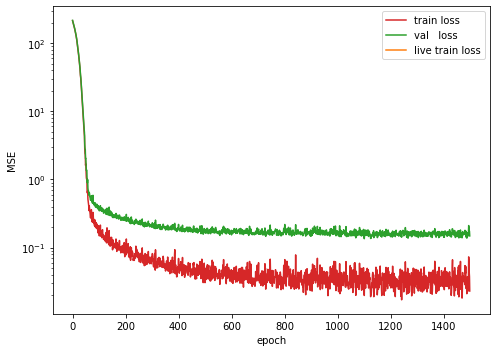

In [42]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

c1 = 'tab:red'
c2 = 'tab:green'
c3 = 'tab:orange'

axs.plot(trn_losses_bn, label="train loss", color=c1)
axs.plot(val_losses_bn, label="val   loss", color=c2)
axs.plot(trn_losses_live_bn, label="live train loss", color=c3)

axs.set_yscale('log')

axs.set_xlabel("epoch")
axs.set_ylabel("MSE")

axs.legend(loc='best')

fig.tight_layout()

As expected, this has not solved the over-fitting problem, but at least you now know how to implement batch norm!

### Using combinations of these methods

Here we have looked at each of these regularisation methods individually, however they work best when used together.  For example you could use either dropout or L2 regularisation to stop your network overfitting, then use early stopping to stop the training when the loss has converged.  This way we do not waste computational resources after our network has converged.  We could then make even better use of our computational resources by introducing batch normalisation.

We note that often to get these methods working as you want them to, some research has to be done to find the best hyper-parameters, e.g. the $p$ parameter in dropout, the weight-decay in L2 regularisation, or the patience in early stopping.